In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive/')\n\n#!pip install -q condacolab\n#import condacolab\n#condacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision\n"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/z/home/sgal/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=100, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/BLAT500_gaps.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/BLAT500_alignment.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization')
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=1750, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=1750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=60, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] 
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_23_preprint_22feb2024.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)


'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=100)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


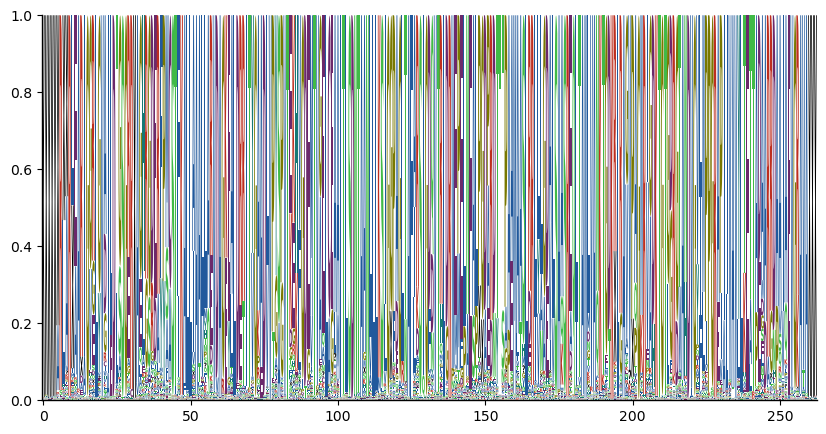

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")

else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )


deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)

In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])

    #fig.tight_layout()


def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize) #; fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet]
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)

        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)

    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')

    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]


                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS
                optimizer.step()


                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())

                # Save to tensorboard
                iteration = epoch*len(trainloader) + i

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_23_preprint_23feb2024_batchsize_100.pth'
pretrained_density = logdir_density + "/" + outmodel_name_density
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-575,575])#[-175,175] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-5)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'


if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=400, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)




Number of training points:  500


Epoch 1/400:   0%|          | 0/500 [00:00<?, ?samples/s]

/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/net/ged.nzcorp.net/z/home/sgal/ML_Projects/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s]

Epoch 1/400:  20%|██        | 100/500 [00:16<01:06,  6.04samples/s, loss=80957.4453125]

Epoch 1/400:  40%|████      | 200/500 [00:30<00:45,  6.64samples/s, loss=80957.4453125]

Epoch 1/400:  40%|████      | 200/500 [00:30<00:45,  6.64samples/s, loss=80976.0234375]

Epoch 1/400:  60%|██████    | 300/500 [00:44<00:28,  6.91samples/s, loss=80976.0234375]

Epoch 1/400:  60%|██████    | 300/500 [00:44<00:28,  6.91samples/s, loss=81057.4609375]

Epoch 1/400:  80%|████████  | 400/500 [00:58<00:14,  7.04samples/s, loss=81057.4609375]

Epoch 1/400:  80%|████████  | 400/500 [00:58<00:14,  7.04samples/s, loss=81170.578125] 

Epoch 1/400: 100%|██████████| 500/500 [01:11<00:00,  7.13samples/s, loss=81170.578125]

Epoch 1/400: 100%|██████████| 500/500 [01:11<00:00,  7.13samples/s, loss=81146.4375]  

Epoch 1/400: 100%|██████████| 500/500 [01:12<00:00,  6.92samples/s, loss=81146.4375]

Epoch 2/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 2/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 2/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=80779.703125]

Epoch 2/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80779.703125]

Epoch 2/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80939.5234375]

Epoch 2/400:  60%|██████    | 300/500 [00:41<00:27,  7.22samples/s, loss=80939.5234375]

Epoch 2/400:  60%|██████    | 300/500 [00:41<00:27,  7.22samples/s, loss=81019.078125] 

Epoch 2/400:  80%|████████  | 400/500 [00:54<00:13,  7.23samples/s, loss=81019.078125]

Epoch 2/400:  80%|████████  | 400/500 [00:55<00:13,  7.23samples/s, loss=81152.8984375]

Epoch 2/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=81152.8984375]

Epoch 2/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=81092.0546875]

Epoch 2/400: 100%|██████████| 500/500 [01:09<00:00,  7.23samples/s, loss=81092.0546875]

Epoch 3/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 3/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 3/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=80691.921875]

Epoch 3/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80691.921875]

Epoch 3/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80896.03125] 

Epoch 3/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=80896.03125]

Epoch 3/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=80911.4296875]

Epoch 3/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=80911.4296875]

Epoch 3/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=81027.46875]  

Epoch 3/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=81027.46875]

Epoch 3/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=80750.375]  

Epoch 3/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=80750.375]

Epoch 4/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 4/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 4/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=80599.1953125]

Epoch 4/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80599.1953125]

Epoch 4/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=80746.8828125]

Epoch 4/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=80746.8828125]

Epoch 4/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=80762.5703125]

Epoch 4/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=80762.5703125]

Epoch 4/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=80726.7890625]

Epoch 4/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=80726.7890625]

Epoch 4/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=80330.0859375]

Epoch 4/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=80330.0859375]

Epoch 5/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 5/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 5/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=80484.1171875]

Epoch 5/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80484.1171875]

Epoch 5/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80418.6640625]

Epoch 5/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=80418.6640625]

Epoch 5/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=78869.0703125]

Epoch 5/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=78869.0703125]

Epoch 5/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=79365.84375]  

Epoch 5/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=79365.84375]

Epoch 5/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=78776.59375]

Epoch 5/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=78776.59375]

Epoch 6/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 6/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 6/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=80373.2421875]

Epoch 6/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=80373.2421875]

Epoch 6/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=78813.4140625]

Epoch 6/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=78813.4140625]

Epoch 6/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=77742.34375]  

Epoch 6/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=77742.34375]

Epoch 6/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=76222.21875]

Epoch 6/400: 100%|██████████| 500/500 [01:07<00:00,  7.33samples/s, loss=76222.21875]

Epoch 6/400: 100%|██████████| 500/500 [01:07<00:00,  7.33samples/s, loss=76021.0078125]

Epoch 6/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=76021.0078125]

Epoch 7/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 7/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 7/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79905.2890625]

Epoch 7/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=79905.2890625]

Epoch 7/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=77412.703125] 

Epoch 7/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=77412.703125]

Epoch 7/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=76043.21875] 

Epoch 7/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=76043.21875]

Epoch 7/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=75045.1875] 

Epoch 7/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=75045.1875]

Epoch 7/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=75450.140625]

Epoch 7/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=75450.140625]

Epoch 8/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 8/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 8/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=78932.34375]

Epoch 8/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=78932.34375]

Epoch 8/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=76582.0]    

Epoch 8/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=76582.0]

Epoch 8/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=75852.671875]

Epoch 8/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=75852.671875]

Epoch 8/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=74243.1015625]

Epoch 8/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=74243.1015625]

Epoch 8/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=74955.5703125]

Epoch 8/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=74955.5703125]

Epoch 9/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 9/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 9/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=78275.859375]

Epoch 9/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=78275.859375]

Epoch 9/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=76685.59375] 

Epoch 9/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=76685.59375]

Epoch 9/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=76284.9453125]

Epoch 9/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=76284.9453125]

Epoch 9/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=75222.6015625]

Epoch 9/400: 100%|██████████| 500/500 [01:06<00:00,  7.41samples/s, loss=75222.6015625]

Epoch 9/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=75922.5703125]

Epoch 9/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=75922.5703125]

Epoch 10/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 10/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 10/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=77923.8984375]

Epoch 10/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=77923.8984375]

Epoch 10/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=76564.171875] 

Epoch 10/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=76564.171875]

Epoch 10/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=76188.3203125]

Epoch 10/400:  80%|████████  | 400/500 [00:53<00:13,  7.39samples/s, loss=76188.3203125]

Epoch 10/400:  80%|████████  | 400/500 [00:53<00:13,  7.39samples/s, loss=74862.1015625]

Epoch 10/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=74862.1015625]

Epoch 10/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=75666.9375]   

Epoch 10/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=75666.9375]

Epoch 11/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 11/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s]

Epoch 11/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s, loss=77460.8125]

Epoch 11/400:  40%|████      | 200/500 [00:27<00:41,  7.14samples/s, loss=77460.8125]

Epoch 11/400:  40%|████      | 200/500 [00:27<00:41,  7.14samples/s, loss=76138.375] 

Epoch 11/400:  60%|██████    | 300/500 [00:41<00:27,  7.17samples/s, loss=76138.375]

Epoch 11/400:  60%|██████    | 300/500 [00:41<00:27,  7.17samples/s, loss=75308.0390625]

Epoch 11/400:  80%|████████  | 400/500 [00:55<00:13,  7.16samples/s, loss=75308.0390625]

Epoch 11/400:  80%|████████  | 400/500 [00:55<00:13,  7.16samples/s, loss=74305.8828125]

Epoch 11/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=74305.8828125]

Epoch 11/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=74514.734375] 

Epoch 11/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=74514.734375]

Epoch 12/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 12/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s]

Epoch 12/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s, loss=78471.9296875]

Epoch 12/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=78471.9296875]

Epoch 12/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=76013.578125] 

Epoch 12/400:  60%|██████    | 300/500 [00:40<00:27,  7.32samples/s, loss=76013.578125]

Epoch 12/400:  60%|██████    | 300/500 [00:41<00:27,  7.32samples/s, loss=75177.6328125]

Epoch 12/400:  80%|████████  | 400/500 [00:54<00:13,  7.24samples/s, loss=75177.6328125]

Epoch 12/400:  80%|████████  | 400/500 [00:55<00:13,  7.24samples/s, loss=73913.8125]   

Epoch 12/400: 100%|██████████| 500/500 [01:08<00:00,  7.20samples/s, loss=73913.8125]

Epoch 12/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=74190.4453125]

Epoch 12/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=74190.4453125]

Epoch 13/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 13/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 13/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79264.9609375]

Epoch 13/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=79264.9609375]

Epoch 13/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=76794.2890625]

Epoch 13/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=76794.2890625]

Epoch 13/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=74679.6953125]

Epoch 13/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=74679.6953125]

Epoch 13/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=73219.3046875]

Epoch 13/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=73219.3046875]

Epoch 13/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=74313.9609375]

Epoch 13/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=74313.9609375]

Epoch 14/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 14/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 14/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=78955.546875]

Epoch 14/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=78955.546875]

Epoch 14/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=76176.7421875]

Epoch 14/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=76176.7421875]

Epoch 14/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=74298.3125]   

Epoch 14/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=74298.3125]

Epoch 14/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=73119.0078125]

Epoch 14/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=73119.0078125]

Epoch 14/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=73239.3671875]

Epoch 14/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=73239.3671875]

Epoch 15/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 15/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 15/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=79289.5546875]

Epoch 15/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=79289.5546875]

Epoch 15/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=76458.234375] 

Epoch 15/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=76458.234375]

Epoch 15/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=73793.1640625]

Epoch 15/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=73793.1640625]

Epoch 15/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=72263.171875] 

Epoch 15/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=72263.171875]

Epoch 15/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=73407.8046875]

Epoch 15/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=73407.8046875]

Epoch 16/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 16/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 16/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=79002.328125]

Epoch 16/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=79002.328125]

Epoch 16/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=75953.921875]

Epoch 16/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=75953.921875]

Epoch 16/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=73998.28125] 

Epoch 16/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=73998.28125]

Epoch 16/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=71869.7890625]

Epoch 16/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=71869.7890625]

Epoch 16/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=73230.875]    

Epoch 16/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=73230.875]

Epoch 17/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 17/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 17/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79413.78125]

Epoch 17/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=79413.78125]

Epoch 17/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=74645.6796875]

Epoch 17/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=74645.6796875]

Epoch 17/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=73780.4140625]

Epoch 17/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=73780.4140625]

Epoch 17/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=70833.1953125]

Epoch 17/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=70833.1953125]

Epoch 17/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=72883.15625]  

Epoch 17/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=72883.15625]

Epoch 18/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 18/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 18/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=79201.6484375]

Epoch 18/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=79201.6484375]

Epoch 18/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=74748.078125] 

Epoch 18/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=74748.078125]

Epoch 18/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=73236.0390625]

Epoch 18/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=73236.0390625]

Epoch 18/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=71566.28125]  

Epoch 18/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=71566.28125]

Epoch 18/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=72416.5078125]

Epoch 18/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=72416.5078125]

Epoch 19/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 19/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 19/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=79733.0078125]

Epoch 19/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=79733.0078125]

Epoch 19/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=74821.0390625]

Epoch 19/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=74821.0390625]

Epoch 19/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=72772.28125]  

Epoch 19/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=72772.28125]

Epoch 19/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=71430.140625]

Epoch 19/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=71430.140625]

Epoch 19/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=71416.5390625]

Epoch 19/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=71416.5390625]

Epoch 20/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 20/400:  20%|██        | 100/500 [00:13<00:54,  7.37samples/s]

Epoch 20/400:  20%|██        | 100/500 [00:13<00:54,  7.37samples/s, loss=79518.2578125]

Epoch 20/400:  40%|████      | 200/500 [00:27<00:41,  7.24samples/s, loss=79518.2578125]

Epoch 20/400:  40%|████      | 200/500 [00:27<00:41,  7.24samples/s, loss=75095.4296875]

Epoch 20/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=75095.4296875]

Epoch 20/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=72558.453125] 

Epoch 20/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=72558.453125]

Epoch 20/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=71455.3828125]

Epoch 20/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=71455.3828125]

Epoch 20/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=73558.25]     

Epoch 20/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=73558.25]

Epoch 21/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 21/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s]

Epoch 21/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s, loss=79360.2109375]

Epoch 21/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=79360.2109375]

Epoch 21/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=75046.6171875]

Epoch 21/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=75046.6171875]

Epoch 21/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=73321.3671875]

Epoch 21/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=73321.3671875]

Epoch 21/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=70869.15625]  

Epoch 21/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=70869.15625]

Epoch 21/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=72642.546875]

Epoch 21/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=72642.546875]

Epoch 22/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 22/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 22/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79564.546875]

Epoch 22/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=79564.546875]

Epoch 22/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=74110.5625]  

Epoch 22/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=74110.5625]

Epoch 22/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=72374.9375]

Epoch 22/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=72374.9375]

Epoch 22/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=70789.890625]

Epoch 22/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=70789.890625]

Epoch 22/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=72114.6640625]

Epoch 22/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=72114.6640625]

Epoch 23/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 23/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s]

Epoch 23/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s, loss=79588.6953125]

Epoch 23/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=79588.6953125]

Epoch 23/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=75127.234375] 

Epoch 23/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=75127.234375]

Epoch 23/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=73230.0]     

Epoch 23/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=73230.0]

Epoch 23/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=70209.9140625]

Epoch 23/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=70209.9140625]

Epoch 23/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=72209.2890625]

Epoch 23/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=72209.2890625]

Epoch 24/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 24/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 24/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=79872.5625]

Epoch 24/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=79872.5625]

Epoch 24/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=74374.1015625]

Epoch 24/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=74374.1015625]

Epoch 24/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=71299.078125] 

Epoch 24/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=71299.078125]

Epoch 24/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=71187.4921875]

Epoch 24/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=71187.4921875]

Epoch 24/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=72722.5859375]

Epoch 24/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=72722.5859375]

Epoch 25/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 25/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 25/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=80042.5859375]

Epoch 25/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80042.5859375]

Epoch 25/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=74077.3046875]

Epoch 25/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=74077.3046875]

Epoch 25/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=72503.6171875]

Epoch 25/400:  80%|████████  | 400/500 [00:54<00:13,  7.21samples/s, loss=72503.6171875]

Epoch 25/400:  80%|████████  | 400/500 [00:54<00:13,  7.21samples/s, loss=70459.7109375]

Epoch 25/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=70459.7109375]

Epoch 25/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=71364.5234375]

Epoch 25/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=71364.5234375]

Epoch 26/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 26/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 26/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=79783.6484375]

Epoch 26/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=79783.6484375]

Epoch 26/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=75594.4609375]

Epoch 26/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=75594.4609375]

Epoch 26/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=71647.46875]  

Epoch 26/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=71647.46875]

Epoch 26/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=69653.9765625]

Epoch 26/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=69653.9765625]

Epoch 26/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=72560.8359375]

Epoch 26/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=72560.8359375]

Epoch 27/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 27/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 27/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=79872.6953125]

Epoch 27/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=79872.6953125]

Epoch 27/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=75196.609375] 

Epoch 27/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=75196.609375]

Epoch 27/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=71194.90625] 

Epoch 27/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=71194.90625]

Epoch 27/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=69436.0390625]

Epoch 27/400: 100%|██████████| 500/500 [01:08<00:00,  7.22samples/s, loss=69436.0390625]

Epoch 27/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=71658.515625] 

Epoch 27/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=71658.515625]

Epoch 28/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 28/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 28/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=80228.890625]

Epoch 28/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=80228.890625]

Epoch 28/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=73740.90625] 

Epoch 28/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=73740.90625]

Epoch 28/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=71432.2421875]

Epoch 28/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=71432.2421875]

Epoch 28/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=69566.71875]  

Epoch 28/400: 100%|██████████| 500/500 [01:09<00:00,  7.13samples/s, loss=69566.71875]

Epoch 28/400: 100%|██████████| 500/500 [01:09<00:00,  7.13samples/s, loss=70769.8671875]

Epoch 28/400: 100%|██████████| 500/500 [01:09<00:00,  7.15samples/s, loss=70769.8671875]

Epoch 29/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 29/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 29/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=79811.78125]

Epoch 29/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=79811.78125]

Epoch 29/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=74065.03125]

Epoch 29/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=74065.03125]

Epoch 29/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=71451.828125]

Epoch 29/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=71451.828125]

Epoch 29/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=69721.4140625]

Epoch 29/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=69721.4140625]

Epoch 29/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=71415.8046875]

Epoch 29/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=71415.8046875]

Epoch 30/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 30/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 30/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=80058.140625]

Epoch 30/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80058.140625]

Epoch 30/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=74060.5234375]

Epoch 30/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=74060.5234375]

Epoch 30/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=72030.5625]   

Epoch 30/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=72030.5625]

Epoch 30/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=69012.359375]

Epoch 30/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69012.359375]

Epoch 30/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=71039.96875] 

Epoch 30/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=71039.96875]

Epoch 31/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 31/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 31/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79898.828125]

Epoch 31/400:  40%|████      | 200/500 [00:26<00:40,  7.42samples/s, loss=79898.828125]

Epoch 31/400:  40%|████      | 200/500 [00:26<00:40,  7.42samples/s, loss=74622.6328125]

Epoch 31/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=74622.6328125]

Epoch 31/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=71191.9921875]

Epoch 31/400:  80%|████████  | 400/500 [00:53<00:13,  7.39samples/s, loss=71191.9921875]

Epoch 31/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=69874.3671875]

Epoch 31/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=69874.3671875]

Epoch 31/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=72326.7265625]

Epoch 31/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=72326.7265625]

Epoch 32/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 32/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s]

Epoch 32/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s, loss=79830.421875]

Epoch 32/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=79830.421875]

Epoch 32/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=74893.390625]

Epoch 32/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=74893.390625]

Epoch 32/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=71882.5]     

Epoch 32/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=71882.5]

Epoch 32/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=68945.65625]

Epoch 32/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68945.65625]

Epoch 32/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=70668.5703125]

Epoch 32/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=70668.5703125]

Epoch 33/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 33/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s]

Epoch 33/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s, loss=80144.21875]

Epoch 33/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=80144.21875]

Epoch 33/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=74521.84375]

Epoch 33/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=74521.84375]

Epoch 33/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=71061.234375]

Epoch 33/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=71061.234375]

Epoch 33/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=68810.8671875]

Epoch 33/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=68810.8671875]

Epoch 33/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=70817.3359375]

Epoch 33/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70817.3359375]

Epoch 34/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 34/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s]

Epoch 34/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s, loss=79995.6953125]

Epoch 34/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=79995.6953125]

Epoch 34/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=74195.90625]  

Epoch 34/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=74195.90625]

Epoch 34/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=71892.734375]

Epoch 34/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=71892.734375]

Epoch 34/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=68803.671875]

Epoch 34/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=68803.671875]

Epoch 34/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=71077.296875]

Epoch 34/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=71077.296875]

Epoch 35/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 35/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s]

Epoch 35/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s, loss=79742.4296875]

Epoch 35/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=79742.4296875]

Epoch 35/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=74171.4921875]

Epoch 35/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=74171.4921875]

Epoch 35/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=70802.5078125]

Epoch 35/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=70802.5078125]

Epoch 35/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=68772.1015625]

Epoch 35/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=68772.1015625]

Epoch 35/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=70869.34375]  

Epoch 35/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=70869.34375]

Epoch 36/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 36/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 36/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=79745.6953125]

Epoch 36/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=79745.6953125]

Epoch 36/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=74424.2421875]

Epoch 36/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=74424.2421875]

Epoch 36/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=71910.8359375]

Epoch 36/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=71910.8359375]

Epoch 36/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=69181.640625] 

Epoch 36/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69181.640625]

Epoch 36/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=70905.7734375]

Epoch 36/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=70905.7734375]

Epoch 37/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 37/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 37/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=79717.2421875]

Epoch 37/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=79717.2421875]

Epoch 37/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=74531.8671875]

Epoch 37/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=74531.8671875]

Epoch 37/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=70841.15625]  

Epoch 37/400:  80%|████████  | 400/500 [00:55<00:13,  7.19samples/s, loss=70841.15625]

Epoch 37/400:  80%|████████  | 400/500 [00:55<00:13,  7.19samples/s, loss=68442.90625]

Epoch 37/400: 100%|██████████| 500/500 [01:09<00:00,  7.14samples/s, loss=68442.90625]

Epoch 37/400: 100%|██████████| 500/500 [01:09<00:00,  7.14samples/s, loss=71585.21875]

Epoch 37/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=71585.21875]

Epoch 38/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 38/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 38/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=80076.5234375]

Epoch 38/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80076.5234375]

Epoch 38/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=74206.125]    

Epoch 38/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=74206.125]

Epoch 38/400:  60%|██████    | 300/500 [00:41<00:27,  7.31samples/s, loss=71142.1171875]

Epoch 38/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=71142.1171875]

Epoch 38/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=68682.84375]  

Epoch 38/400: 100%|██████████| 500/500 [01:08<00:00,  7.23samples/s, loss=68682.84375]

Epoch 38/400: 100%|██████████| 500/500 [01:08<00:00,  7.23samples/s, loss=71196.0234375]

Epoch 38/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=71196.0234375]

Epoch 39/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 39/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 39/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=79784.2265625]

Epoch 39/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=79784.2265625]

Epoch 39/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=74269.953125] 

Epoch 39/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=74269.953125]

Epoch 39/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=71009.734375]

Epoch 39/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=71009.734375]

Epoch 39/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=68367.6484375]

Epoch 39/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=68367.6484375]

Epoch 39/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=70720.1484375]

Epoch 39/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=70720.1484375]

Epoch 40/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 40/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s]

Epoch 40/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s, loss=79949.53125]

Epoch 40/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=79949.53125]

Epoch 40/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=74737.125]  

Epoch 40/400:  60%|██████    | 300/500 [00:41<00:27,  7.22samples/s, loss=74737.125]

Epoch 40/400:  60%|██████    | 300/500 [00:41<00:27,  7.22samples/s, loss=70336.0]  

Epoch 40/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=70336.0]

Epoch 40/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=69132.71875]

Epoch 40/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=69132.71875]

Epoch 40/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=71231.3828125]

Epoch 40/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=71231.3828125]

Epoch 41/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 41/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 41/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=79961.890625]

Epoch 41/400:  40%|████      | 200/500 [00:27<00:41,  7.23samples/s, loss=79961.890625]

Epoch 41/400:  40%|████      | 200/500 [00:27<00:41,  7.23samples/s, loss=74136.0859375]

Epoch 41/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=74136.0859375]

Epoch 41/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=70311.171875] 

Epoch 41/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=70311.171875]

Epoch 41/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=67491.3125]  

Epoch 41/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=67491.3125]

Epoch 41/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=71117.3671875]

Epoch 41/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=71117.3671875]

Epoch 42/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 42/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s]

Epoch 42/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s, loss=79691.34375]

Epoch 42/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=79691.34375]

Epoch 42/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=74238.5]    

Epoch 42/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=74238.5]

Epoch 42/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=70665.265625]

Epoch 42/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=70665.265625]

Epoch 42/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=68927.7265625]

Epoch 42/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=68927.7265625]

Epoch 42/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=70526.1875]   

Epoch 42/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=70526.1875]

Epoch 43/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 43/400:  20%|██        | 100/500 [00:13<00:54,  7.30samples/s]

Epoch 43/400:  20%|██        | 100/500 [00:13<00:54,  7.30samples/s, loss=79644.984375]

Epoch 43/400:  40%|████      | 200/500 [00:27<00:41,  7.21samples/s, loss=79644.984375]

Epoch 43/400:  40%|████      | 200/500 [00:27<00:41,  7.21samples/s, loss=74036.515625]

Epoch 43/400:  60%|██████    | 300/500 [00:41<00:27,  7.19samples/s, loss=74036.515625]

Epoch 43/400:  60%|██████    | 300/500 [00:41<00:27,  7.19samples/s, loss=70700.9921875]

Epoch 43/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=70700.9921875]

Epoch 43/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=68912.765625] 

Epoch 43/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=68912.765625]

Epoch 43/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=70619.3671875]

Epoch 43/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=70619.3671875]

Epoch 44/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 44/400:  20%|██        | 100/500 [00:13<00:55,  7.23samples/s]

Epoch 44/400:  20%|██        | 100/500 [00:13<00:55,  7.23samples/s, loss=79735.453125]

Epoch 44/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=79735.453125]

Epoch 44/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=73982.6328125]

Epoch 44/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=73982.6328125]

Epoch 44/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=71156.046875] 

Epoch 44/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=71156.046875]

Epoch 44/400:  80%|████████  | 400/500 [00:55<00:13,  7.29samples/s, loss=68685.25]    

Epoch 44/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=68685.25]

Epoch 44/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=70511.078125]

Epoch 44/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=70511.078125]

Epoch 45/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 45/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s]

Epoch 45/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s, loss=79995.296875]

Epoch 45/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=79995.296875]

Epoch 45/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=73948.453125]

Epoch 45/400:  60%|██████    | 300/500 [00:40<00:27,  7.32samples/s, loss=73948.453125]

Epoch 45/400:  60%|██████    | 300/500 [00:41<00:27,  7.32samples/s, loss=69978.8984375]

Epoch 45/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=69978.8984375]

Epoch 45/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=69056.0625]   

Epoch 45/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=69056.0625]

Epoch 45/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70794.5625]

Epoch 45/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=70794.5625]

Epoch 46/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 46/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 46/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=79833.2890625]

Epoch 46/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=79833.2890625]

Epoch 46/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=74868.6796875]

Epoch 46/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=74868.6796875]

Epoch 46/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=70654.7578125]

Epoch 46/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=70654.7578125]

Epoch 46/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=68510.421875] 

Epoch 46/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=68510.421875]

Epoch 46/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70602.8671875]

Epoch 46/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70602.8671875]

Epoch 47/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 47/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s]

Epoch 47/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s, loss=80426.4609375]

Epoch 47/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=80426.4609375]

Epoch 47/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=73725.3203125]

Epoch 47/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=73725.3203125]

Epoch 47/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=70633.015625] 

Epoch 47/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=70633.015625]

Epoch 47/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=68648.25]    

Epoch 47/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=68648.25]

Epoch 47/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=71409.7109375]

Epoch 47/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=71409.7109375]

Epoch 48/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 48/400:  20%|██        | 100/500 [00:13<00:53,  7.46samples/s]

Epoch 48/400:  20%|██        | 100/500 [00:13<00:53,  7.46samples/s, loss=79859.3671875]

Epoch 48/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=79859.3671875]

Epoch 48/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=74398.421875] 

Epoch 48/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=74398.421875]

Epoch 48/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=70417.0859375]

Epoch 48/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=70417.0859375]

Epoch 48/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=68253.234375] 

Epoch 48/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=68253.234375]

Epoch 48/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=70505.34375] 

Epoch 48/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=70505.34375]

Epoch 49/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 49/400:  20%|██        | 100/500 [00:14<00:56,  7.05samples/s]

Epoch 49/400:  20%|██        | 100/500 [00:14<00:56,  7.05samples/s, loss=80085.78125]

Epoch 49/400:  40%|████      | 200/500 [00:27<00:41,  7.17samples/s, loss=80085.78125]

Epoch 49/400:  40%|████      | 200/500 [00:28<00:41,  7.17samples/s, loss=73995.3203125]

Epoch 49/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=73995.3203125]

Epoch 49/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=70400.359375] 

Epoch 49/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=70400.359375]

Epoch 49/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=67551.28125] 

Epoch 49/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=67551.28125]

Epoch 49/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=70565.6171875]

Epoch 49/400: 100%|██████████| 500/500 [01:10<00:00,  7.14samples/s, loss=70565.6171875]

Epoch 50/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 50/400:  20%|██        | 100/500 [00:14<00:56,  7.13samples/s]

Epoch 50/400:  20%|██        | 100/500 [00:14<00:56,  7.13samples/s, loss=79719.875]

Epoch 50/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=79719.875]

Epoch 50/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=73729.2109375]

Epoch 50/400:  60%|██████    | 300/500 [00:41<00:28,  7.14samples/s, loss=73729.2109375]

Epoch 50/400:  60%|██████    | 300/500 [00:42<00:28,  7.14samples/s, loss=71808.1171875]

Epoch 50/400:  80%|████████  | 400/500 [00:56<00:14,  7.02samples/s, loss=71808.1171875]

Epoch 50/400:  80%|████████  | 400/500 [00:56<00:14,  7.02samples/s, loss=68899.359375] 

Epoch 50/400: 100%|██████████| 500/500 [01:10<00:00,  7.05samples/s, loss=68899.359375]

Epoch 50/400: 100%|██████████| 500/500 [01:10<00:00,  7.05samples/s, loss=71462.15625] 

Epoch 50/400: 100%|██████████| 500/500 [01:11<00:00,  7.04samples/s, loss=71462.15625]

Epoch 51/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 51/400:  20%|██        | 100/500 [00:13<00:54,  7.35samples/s]

Epoch 51/400:  20%|██        | 100/500 [00:13<00:54,  7.35samples/s, loss=79743.703125]

Epoch 51/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=79743.703125]

Epoch 51/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=73937.5703125]

Epoch 51/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=73937.5703125]

Epoch 51/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=70443.1484375]

Epoch 51/400:  80%|████████  | 400/500 [00:55<00:13,  7.24samples/s, loss=70443.1484375]

Epoch 51/400:  80%|████████  | 400/500 [00:55<00:13,  7.24samples/s, loss=68254.1796875]

Epoch 51/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=68254.1796875]

Epoch 51/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=69988.109375] 

Epoch 51/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=69988.109375]

Epoch 52/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 52/400:  20%|██        | 100/500 [00:13<00:55,  7.23samples/s]

Epoch 52/400:  20%|██        | 100/500 [00:13<00:55,  7.23samples/s, loss=80028.5234375]

Epoch 52/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=80028.5234375]

Epoch 52/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=74447.640625] 

Epoch 52/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=74447.640625]

Epoch 52/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=71253.78125] 

Epoch 52/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=71253.78125]

Epoch 52/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=68484.6875] 

Epoch 52/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=68484.6875]

Epoch 52/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=70455.1640625]

Epoch 52/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=70455.1640625]

Epoch 53/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 53/400:  20%|██        | 100/500 [00:13<00:55,  7.24samples/s]

Epoch 53/400:  20%|██        | 100/500 [00:13<00:55,  7.24samples/s, loss=80283.4375]

Epoch 53/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=80283.4375]

Epoch 53/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=73976.2734375]

Epoch 53/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=73976.2734375]

Epoch 53/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=69806.8046875]

Epoch 53/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=69806.8046875]

Epoch 53/400:  80%|████████  | 400/500 [00:55<00:13,  7.17samples/s, loss=68772.5390625]

Epoch 53/400: 100%|██████████| 500/500 [01:09<00:00,  7.13samples/s, loss=68772.5390625]

Epoch 53/400: 100%|██████████| 500/500 [01:09<00:00,  7.13samples/s, loss=69976.828125] 

Epoch 53/400: 100%|██████████| 500/500 [01:10<00:00,  7.12samples/s, loss=69976.828125]

Epoch 54/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 54/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 54/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=79809.5546875]

Epoch 54/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=79809.5546875]

Epoch 54/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=74057.2890625]

Epoch 54/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=74057.2890625]

Epoch 54/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=70787.3984375]

Epoch 54/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=70787.3984375]

Epoch 54/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=67450.828125] 

Epoch 54/400: 100%|██████████| 500/500 [01:09<00:00,  7.09samples/s, loss=67450.828125]

Epoch 54/400: 100%|██████████| 500/500 [01:09<00:00,  7.09samples/s, loss=70911.9140625]

Epoch 54/400: 100%|██████████| 500/500 [01:10<00:00,  7.14samples/s, loss=70911.9140625]

Epoch 55/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 55/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s]

Epoch 55/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s, loss=79955.65625]

Epoch 55/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=79955.65625]

Epoch 55/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=73816.703125]

Epoch 55/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=73816.703125]

Epoch 55/400:  60%|██████    | 300/500 [00:41<00:27,  7.31samples/s, loss=70795.6796875]

Epoch 55/400:  80%|████████  | 400/500 [00:54<00:13,  7.24samples/s, loss=70795.6796875]

Epoch 55/400:  80%|████████  | 400/500 [00:55<00:13,  7.24samples/s, loss=67750.7734375]

Epoch 55/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=67750.7734375]

Epoch 55/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=70082.09375]  

Epoch 55/400: 100%|██████████| 500/500 [01:09<00:00,  7.23samples/s, loss=70082.09375]

Epoch 56/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 56/400:  20%|██        | 100/500 [00:13<00:54,  7.32samples/s]

Epoch 56/400:  20%|██        | 100/500 [00:13<00:54,  7.32samples/s, loss=80163.8671875]

Epoch 56/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=80163.8671875]

Epoch 56/400:  40%|████      | 200/500 [00:27<00:41,  7.27samples/s, loss=74378.90625]  

Epoch 56/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=74378.90625]

Epoch 56/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=71001.6015625]

Epoch 56/400:  80%|████████  | 400/500 [00:55<00:13,  7.27samples/s, loss=71001.6015625]

Epoch 56/400:  80%|████████  | 400/500 [00:55<00:13,  7.27samples/s, loss=67794.2421875]

Epoch 56/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=67794.2421875]

Epoch 56/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70492.8671875]

Epoch 56/400: 100%|██████████| 500/500 [01:09<00:00,  7.23samples/s, loss=70492.8671875]

Epoch 57/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 57/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s]

Epoch 57/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s, loss=79960.953125]

Epoch 57/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=79960.953125]

Epoch 57/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=73827.1484375]

Epoch 57/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=73827.1484375]

Epoch 57/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=70107.578125] 

Epoch 57/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=70107.578125]

Epoch 57/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=67428.3359375]

Epoch 57/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=67428.3359375]

Epoch 57/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=70879.484375] 

Epoch 57/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=70879.484375]

Epoch 58/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 58/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 58/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=80079.546875]

Epoch 58/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=80079.546875]

Epoch 58/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=73574.0078125]

Epoch 58/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=73574.0078125]

Epoch 58/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=69906.5]      

Epoch 58/400:  80%|████████  | 400/500 [00:54<00:13,  7.26samples/s, loss=69906.5]

Epoch 58/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=67813.9609375]

Epoch 58/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=67813.9609375]

Epoch 58/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=70490.5390625]

Epoch 58/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=70490.5390625]

Epoch 59/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 59/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s]

Epoch 59/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s, loss=79770.640625]

Epoch 59/400:  40%|████      | 200/500 [00:27<00:42,  7.14samples/s, loss=79770.640625]

Epoch 59/400:  40%|████      | 200/500 [00:27<00:42,  7.14samples/s, loss=74111.640625]

Epoch 59/400:  60%|██████    | 300/500 [00:41<00:27,  7.17samples/s, loss=74111.640625]

Epoch 59/400:  60%|██████    | 300/500 [00:41<00:27,  7.17samples/s, loss=70707.09375] 

Epoch 59/400:  80%|████████  | 400/500 [00:55<00:13,  7.20samples/s, loss=70707.09375]

Epoch 59/400:  80%|████████  | 400/500 [00:55<00:13,  7.20samples/s, loss=68340.6640625]

Epoch 59/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=68340.6640625]

Epoch 59/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=70203.578125] 

Epoch 59/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=70203.578125]

Epoch 60/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 60/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s]

Epoch 60/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s, loss=80090.8046875]

Epoch 60/400:  40%|████      | 200/500 [00:27<00:41,  7.24samples/s, loss=80090.8046875]

Epoch 60/400:  40%|████      | 200/500 [00:27<00:41,  7.24samples/s, loss=74359.1875]   

Epoch 60/400:  60%|██████    | 300/500 [00:41<00:27,  7.15samples/s, loss=74359.1875]

Epoch 60/400:  60%|██████    | 300/500 [00:41<00:27,  7.15samples/s, loss=69666.421875]

Epoch 60/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=69666.421875]

Epoch 60/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=67415.1171875]

Epoch 60/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=67415.1171875]

Epoch 60/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=70938.5390625]

Epoch 60/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=70938.5390625]

Epoch 61/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 61/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 61/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=79774.6484375]

Epoch 61/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=79774.6484375]

Epoch 61/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=73642.03125]  

Epoch 61/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=73642.03125]

Epoch 61/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=70494.78125]

Epoch 61/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=70494.78125]

Epoch 61/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=68153.1796875]

Epoch 61/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=68153.1796875]

Epoch 61/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=70863.984375] 

Epoch 61/400: 100%|██████████| 500/500 [01:09<00:00,  7.23samples/s, loss=70863.984375]

Epoch 62/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 62/400:  20%|██        | 100/500 [00:13<00:55,  7.21samples/s]

Epoch 62/400:  20%|██        | 100/500 [00:13<00:55,  7.21samples/s, loss=80101.6328125]

Epoch 62/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=80101.6328125]

Epoch 62/400:  40%|████      | 200/500 [00:27<00:41,  7.18samples/s, loss=73741.9296875]

Epoch 62/400:  60%|██████    | 300/500 [00:41<00:27,  7.33samples/s, loss=73741.9296875]

Epoch 62/400:  60%|██████    | 300/500 [00:41<00:27,  7.33samples/s, loss=70385.1953125]

Epoch 62/400:  80%|████████  | 400/500 [00:54<00:13,  7.43samples/s, loss=70385.1953125]

Epoch 62/400:  80%|████████  | 400/500 [00:54<00:13,  7.43samples/s, loss=67825.953125] 

Epoch 62/400: 100%|██████████| 500/500 [01:07<00:00,  7.50samples/s, loss=67825.953125]

Epoch 62/400: 100%|██████████| 500/500 [01:07<00:00,  7.50samples/s, loss=69753.421875]

Epoch 62/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=69753.421875]

Epoch 63/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 63/400:  20%|██        | 100/500 [00:12<00:50,  7.85samples/s]

Epoch 63/400:  20%|██        | 100/500 [00:12<00:50,  7.85samples/s, loss=80000.3671875]

Epoch 63/400:  40%|████      | 200/500 [00:25<00:38,  7.71samples/s, loss=80000.3671875]

Epoch 63/400:  40%|████      | 200/500 [00:25<00:38,  7.71samples/s, loss=73388.046875] 

Epoch 63/400:  60%|██████    | 300/500 [00:39<00:26,  7.65samples/s, loss=73388.046875]

Epoch 63/400:  60%|██████    | 300/500 [00:39<00:26,  7.65samples/s, loss=70653.390625]

Epoch 63/400:  80%|████████  | 400/500 [00:52<00:13,  7.51samples/s, loss=70653.390625]

Epoch 63/400:  80%|████████  | 400/500 [00:52<00:13,  7.51samples/s, loss=67072.2109375]

Epoch 63/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=67072.2109375]

Epoch 63/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=69590.2578125]

Epoch 63/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69590.2578125]

Epoch 64/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 64/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 64/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=80008.3984375]

Epoch 64/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=80008.3984375]

Epoch 64/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=73507.125]    

Epoch 64/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=73507.125]

Epoch 64/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=69692.3984375]

Epoch 64/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=69692.3984375]

Epoch 64/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=68112.9765625]

Epoch 64/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=68112.9765625]

Epoch 64/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=70181.3984375]

Epoch 64/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=70181.3984375]

Epoch 65/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 65/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 65/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=79859.921875]

Epoch 65/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=79859.921875]

Epoch 65/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=74122.40625] 

Epoch 65/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=74122.40625]

Epoch 65/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=69763.4609375]

Epoch 65/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=69763.4609375]

Epoch 65/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=67221.421875] 

Epoch 65/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=67221.421875]

Epoch 65/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=70843.90625] 

Epoch 65/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=70843.90625]

Epoch 66/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 66/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 66/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=80077.5703125]

Epoch 66/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=80077.5703125]

Epoch 66/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=73391.34375]  

Epoch 66/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=73391.34375]

Epoch 66/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=70681.484375]

Epoch 66/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=70681.484375]

Epoch 66/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=66838.078125]

Epoch 66/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=66838.078125]

Epoch 66/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=70055.8359375]

Epoch 66/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=70055.8359375]

Epoch 67/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 67/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s]

Epoch 67/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s, loss=80133.34375]

Epoch 67/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=80133.34375]

Epoch 67/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=73928.921875]

Epoch 67/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=73928.921875]

Epoch 67/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=70099.0546875]

Epoch 67/400:  80%|████████  | 400/500 [00:52<00:13,  7.48samples/s, loss=70099.0546875]

Epoch 67/400:  80%|████████  | 400/500 [00:52<00:13,  7.48samples/s, loss=68172.4609375]

Epoch 67/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=68172.4609375]

Epoch 67/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=70010.8359375]

Epoch 67/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=70010.8359375]

Epoch 68/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 68/400:  20%|██        | 100/500 [00:13<00:54,  7.29samples/s]

Epoch 68/400:  20%|██        | 100/500 [00:13<00:54,  7.29samples/s, loss=79478.6640625]

Epoch 68/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=79478.6640625]

Epoch 68/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=74272.625]    

Epoch 68/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=74272.625]

Epoch 68/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=69771.8984375]

Epoch 68/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=69771.8984375]

Epoch 68/400:  80%|████████  | 400/500 [00:55<00:13,  7.27samples/s, loss=68360.328125] 

Epoch 68/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=68360.328125]

Epoch 68/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=69734.3203125]

Epoch 68/400: 100%|██████████| 500/500 [01:09<00:00,  7.25samples/s, loss=69734.3203125]

Epoch 69/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 69/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s]

Epoch 69/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s, loss=79885.6484375]

Epoch 69/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=79885.6484375]

Epoch 69/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=73713.25]     

Epoch 69/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=73713.25]

Epoch 69/400:  60%|██████    | 300/500 [00:41<00:27,  7.31samples/s, loss=70794.9140625]

Epoch 69/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=70794.9140625]

Epoch 69/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=67661.390625] 

Epoch 69/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67661.390625]

Epoch 69/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=70269.578125]

Epoch 69/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=70269.578125]

Epoch 70/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 70/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s]

Epoch 70/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s, loss=80095.4375]

Epoch 70/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=80095.4375]

Epoch 70/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=73821.5078125]

Epoch 70/400:  60%|██████    | 300/500 [00:40<00:27,  7.41samples/s, loss=73821.5078125]

Epoch 70/400:  60%|██████    | 300/500 [00:40<00:27,  7.41samples/s, loss=69721.0625]   

Epoch 70/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=69721.0625]

Epoch 70/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=66866.9609375]

Epoch 70/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=66866.9609375]

Epoch 70/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=70011.21875]  

Epoch 70/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=70011.21875]

Epoch 71/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 71/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s]

Epoch 71/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s, loss=80195.203125]

Epoch 71/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=80195.203125]

Epoch 71/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=73889.9765625]

Epoch 71/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=73889.9765625]

Epoch 71/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=69658.6015625]

Epoch 71/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=69658.6015625]

Epoch 71/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=66908.09375]  

Epoch 71/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=66908.09375]

Epoch 71/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=70304.15625]

Epoch 71/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=70304.15625]

Epoch 72/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 72/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s]

Epoch 72/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s, loss=80129.25]

Epoch 72/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=80129.25]

Epoch 72/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=73460.8046875]

Epoch 72/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=73460.8046875]

Epoch 72/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=69694.5625]   

Epoch 72/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=69694.5625]

Epoch 72/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=67740.7734375]

Epoch 72/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=67740.7734375]

Epoch 72/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=70107.6015625]

Epoch 72/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=70107.6015625]

Epoch 73/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 73/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 73/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=80226.15625]

Epoch 73/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=80226.15625]

Epoch 73/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=73556.65625]

Epoch 73/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=73556.65625]

Epoch 73/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=69687.046875]

Epoch 73/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=69687.046875]

Epoch 73/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=67873.5703125]

Epoch 73/400: 100%|██████████| 500/500 [01:09<00:00,  7.12samples/s, loss=67873.5703125]

Epoch 73/400: 100%|██████████| 500/500 [01:09<00:00,  7.12samples/s, loss=69470.3515625]

Epoch 73/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=69470.3515625]

Epoch 74/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 74/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s]

Epoch 74/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s, loss=79794.015625]

Epoch 74/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=79794.015625]

Epoch 74/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=73591.9140625]

Epoch 74/400:  60%|██████    | 300/500 [00:40<00:27,  7.32samples/s, loss=73591.9140625]

Epoch 74/400:  60%|██████    | 300/500 [00:41<00:27,  7.32samples/s, loss=70170.4375]   

Epoch 74/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=70170.4375]

Epoch 74/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=67351.96875]

Epoch 74/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=67351.96875]

Epoch 74/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=70017.9375] 

Epoch 74/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=70017.9375]

Epoch 75/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 75/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s]

Epoch 75/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s, loss=80009.46875]

Epoch 75/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=80009.46875]

Epoch 75/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=73896.1015625]

Epoch 75/400:  60%|██████    | 300/500 [00:41<00:27,  7.25samples/s, loss=73896.1015625]

Epoch 75/400:  60%|██████    | 300/500 [00:41<00:27,  7.25samples/s, loss=70044.9375]   

Epoch 75/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=70044.9375]

Epoch 75/400:  80%|████████  | 400/500 [00:55<00:13,  7.29samples/s, loss=67408.9921875]

Epoch 75/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=67408.9921875]

Epoch 75/400: 100%|██████████| 500/500 [01:08<00:00,  7.24samples/s, loss=70544.3203125]

Epoch 75/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=70544.3203125]

Epoch 76/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 76/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s]

Epoch 76/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s, loss=80226.234375]

Epoch 76/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=80226.234375]

Epoch 76/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=72962.78125] 

Epoch 76/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=72962.78125]

Epoch 76/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=70279.515625]

Epoch 76/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=70279.515625]

Epoch 76/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=67450.8203125]

Epoch 76/400: 100%|██████████| 500/500 [01:08<00:00,  7.19samples/s, loss=67450.8203125]

Epoch 76/400: 100%|██████████| 500/500 [01:08<00:00,  7.19samples/s, loss=69946.578125] 

Epoch 76/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=69946.578125]

Epoch 77/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 77/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 77/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=79869.453125]

Epoch 77/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=79869.453125]

Epoch 77/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=73786.828125]

Epoch 77/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=73786.828125]

Epoch 77/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=69840.2421875]

Epoch 77/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=69840.2421875]

Epoch 77/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=67393.0859375]

Epoch 77/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=67393.0859375]

Epoch 77/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=69183.9375]   

Epoch 77/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=69183.9375]

Epoch 78/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 78/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 78/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79856.578125]

Epoch 78/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=79856.578125]

Epoch 78/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=73039.65625] 

Epoch 78/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=73039.65625]

Epoch 78/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=69774.6484375]

Epoch 78/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=69774.6484375]

Epoch 78/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=66911.7734375]

Epoch 78/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=66911.7734375]

Epoch 78/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=69964.1015625]

Epoch 78/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=69964.1015625]

Epoch 79/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 79/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s]

Epoch 79/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s, loss=80095.328125]

Epoch 79/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=80095.328125]

Epoch 79/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=73768.5234375]

Epoch 79/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=73768.5234375]

Epoch 79/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=69452.078125] 

Epoch 79/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=69452.078125]

Epoch 79/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=66850.046875]

Epoch 79/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=66850.046875]

Epoch 79/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=69969.375]   

Epoch 79/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=69969.375]

Epoch 80/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 80/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 80/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=80022.5234375]

Epoch 80/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=80022.5234375]

Epoch 80/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=73727.15625]  

Epoch 80/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=73727.15625]

Epoch 80/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69860.6953125]

Epoch 80/400:  80%|████████  | 400/500 [00:53<00:13,  7.42samples/s, loss=69860.6953125]

Epoch 80/400:  80%|████████  | 400/500 [00:53<00:13,  7.42samples/s, loss=67382.359375] 

Epoch 80/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=67382.359375]

Epoch 80/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=69563.65625] 

Epoch 80/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=69563.65625]

Epoch 81/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 81/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s]

Epoch 81/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s, loss=79901.59375]

Epoch 81/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=79901.59375]

Epoch 81/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=73397.2265625]

Epoch 81/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=73397.2265625]

Epoch 81/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=69517.53125]  

Epoch 81/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=69517.53125]

Epoch 81/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=67067.28125]

Epoch 81/400: 100%|██████████| 500/500 [01:07<00:00,  7.47samples/s, loss=67067.28125]

Epoch 81/400: 100%|██████████| 500/500 [01:07<00:00,  7.47samples/s, loss=69343.6953125]

Epoch 81/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=69343.6953125]

Epoch 82/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 82/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 82/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=79780.8828125]

Epoch 82/400:  40%|████      | 200/500 [00:27<00:40,  7.38samples/s, loss=79780.8828125]

Epoch 82/400:  40%|████      | 200/500 [00:27<00:40,  7.38samples/s, loss=73681.390625] 

Epoch 82/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=73681.390625]

Epoch 82/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=69892.484375]

Epoch 82/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=69892.484375]

Epoch 82/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=67927.1796875]

Epoch 82/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=67927.1796875]

Epoch 82/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=69381.0546875]

Epoch 82/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=69381.0546875]

Epoch 83/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 83/400:  20%|██        | 100/500 [00:12<00:51,  7.74samples/s]

Epoch 83/400:  20%|██        | 100/500 [00:13<00:51,  7.74samples/s, loss=79780.0234375]

Epoch 83/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=79780.0234375]

Epoch 83/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=73108.109375] 

Epoch 83/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=73108.109375]

Epoch 83/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=69869.75]    

Epoch 83/400:  80%|████████  | 400/500 [00:52<00:13,  7.52samples/s, loss=69869.75]

Epoch 83/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=67088.9296875]

Epoch 83/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=67088.9296875]

Epoch 83/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=69613.2734375]

Epoch 83/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=69613.2734375]

Epoch 84/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 84/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 84/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=79963.3359375]

Epoch 84/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=79963.3359375]

Epoch 84/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=73646.8984375]

Epoch 84/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73646.8984375]

Epoch 84/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69495.8515625]

Epoch 84/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=69495.8515625]

Epoch 84/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=67666.265625] 

Epoch 84/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=67666.265625]

Epoch 84/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=69903.5390625]

Epoch 84/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=69903.5390625]

Epoch 85/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 85/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 85/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=79980.1640625]

Epoch 85/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=79980.1640625]

Epoch 85/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=73425.1328125]

Epoch 85/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73425.1328125]

Epoch 85/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69427.6796875]

Epoch 85/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=69427.6796875]

Epoch 85/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=66906.515625] 

Epoch 85/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=66906.515625]

Epoch 85/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=69131.6953125]

Epoch 85/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=69131.6953125]

Epoch 86/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 86/400:  20%|██        | 100/500 [00:12<00:51,  7.73samples/s]

Epoch 86/400:  20%|██        | 100/500 [00:13<00:51,  7.73samples/s, loss=79700.828125]

Epoch 86/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=79700.828125]

Epoch 86/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=72982.3671875]

Epoch 86/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=72982.3671875]

Epoch 86/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=69844.0390625]

Epoch 86/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=69844.0390625]

Epoch 86/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=67211.84375]  

Epoch 86/400: 100%|██████████| 500/500 [01:06<00:00,  7.42samples/s, loss=67211.84375]

Epoch 86/400: 100%|██████████| 500/500 [01:06<00:00,  7.42samples/s, loss=69643.640625]

Epoch 86/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=69643.640625]

Epoch 87/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 87/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 87/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=79963.8515625]

Epoch 87/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=79963.8515625]

Epoch 87/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=73685.046875] 

Epoch 87/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=73685.046875]

Epoch 87/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=69573.4140625]

Epoch 87/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=69573.4140625]

Epoch 87/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=66776.609375] 

Epoch 87/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66776.609375]

Epoch 87/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69357.25]    

Epoch 87/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=69357.25]

Epoch 88/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 88/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s]

Epoch 88/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s, loss=80143.1015625]

Epoch 88/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=80143.1015625]

Epoch 88/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=73355.7421875]

Epoch 88/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=73355.7421875]

Epoch 88/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=69533.8046875]

Epoch 88/400:  80%|████████  | 400/500 [00:52<00:13,  7.51samples/s, loss=69533.8046875]

Epoch 88/400:  80%|████████  | 400/500 [00:52<00:13,  7.51samples/s, loss=67070.2421875]

Epoch 88/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=67070.2421875]

Epoch 88/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=70156.953125] 

Epoch 88/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=70156.953125]

Epoch 89/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 89/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s]

Epoch 89/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s, loss=80013.671875]

Epoch 89/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=80013.671875]

Epoch 89/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=73017.5859375]

Epoch 89/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=73017.5859375]

Epoch 89/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=68953.234375] 

Epoch 89/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=68953.234375]

Epoch 89/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=67332.1484375]

Epoch 89/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=67332.1484375]

Epoch 89/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69471.4375]   

Epoch 89/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69471.4375]

Epoch 90/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 90/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 90/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=80157.1796875]

Epoch 90/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80157.1796875]

Epoch 90/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=73985.28125]  

Epoch 90/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=73985.28125]

Epoch 90/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=69459.5390625]

Epoch 90/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=69459.5390625]

Epoch 90/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=67771.390625] 

Epoch 90/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=67771.390625]

Epoch 90/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=69618.6640625]

Epoch 90/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=69618.6640625]

Epoch 91/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 91/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s]

Epoch 91/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s, loss=80189.984375]

Epoch 91/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=80189.984375]

Epoch 91/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=73911.40625] 

Epoch 91/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=73911.40625]

Epoch 91/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=70149.5546875]

Epoch 91/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=70149.5546875]

Epoch 91/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66502.375]    

Epoch 91/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66502.375]

Epoch 91/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69402.2578125]

Epoch 91/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=69402.2578125]

Epoch 92/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 92/400:  20%|██        | 100/500 [00:12<00:51,  7.75samples/s]

Epoch 92/400:  20%|██        | 100/500 [00:13<00:51,  7.75samples/s, loss=79915.21875]

Epoch 92/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=79915.21875]

Epoch 92/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=73273.625]  

Epoch 92/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=73273.625]

Epoch 92/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=69347.5703125]

Epoch 92/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=69347.5703125]

Epoch 92/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=66653.015625] 

Epoch 92/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=66653.015625]

Epoch 92/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=69578.0546875]

Epoch 92/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69578.0546875]

Epoch 93/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 93/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 93/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79910.109375]

Epoch 93/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=79910.109375]

Epoch 93/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=73514.9296875]

Epoch 93/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=73514.9296875]

Epoch 93/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=69509.640625] 

Epoch 93/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=69509.640625]

Epoch 93/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=67124.5]     

Epoch 93/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=67124.5]

Epoch 93/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=69452.3203125]

Epoch 93/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=69452.3203125]

Epoch 94/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 94/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 94/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=80074.0546875]

Epoch 94/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=80074.0546875]

Epoch 94/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=72802.46875]  

Epoch 94/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=72802.46875]

Epoch 94/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=69160.2578125]

Epoch 94/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=69160.2578125]

Epoch 94/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=66773.4609375]

Epoch 94/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=66773.4609375]

Epoch 94/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=69530.3984375]

Epoch 94/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=69530.3984375]

Epoch 95/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 95/400:  20%|██        | 100/500 [00:12<00:51,  7.74samples/s]

Epoch 95/400:  20%|██        | 100/500 [00:13<00:51,  7.74samples/s, loss=79943.7109375]

Epoch 95/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=79943.7109375]

Epoch 95/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=73709.4296875]

Epoch 95/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=73709.4296875]

Epoch 95/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=69276.015625] 

Epoch 95/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=69276.015625]

Epoch 95/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=66794.0859375]

Epoch 95/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66794.0859375]

Epoch 95/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69846.9609375]

Epoch 95/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=69846.9609375]

Epoch 96/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 96/400:  20%|██        | 100/500 [00:12<00:51,  7.69samples/s]

Epoch 96/400:  20%|██        | 100/500 [00:13<00:51,  7.69samples/s, loss=80192.7890625]

Epoch 96/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=80192.7890625]

Epoch 96/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=73782.0625]   

Epoch 96/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=73782.0625]

Epoch 96/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=69716.9765625]

Epoch 96/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=69716.9765625]

Epoch 96/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66458.7109375]

Epoch 96/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66458.7109375]

Epoch 96/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=69397.7578125]

Epoch 96/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69397.7578125]

Epoch 97/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 97/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 97/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=80119.828125]

Epoch 97/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=80119.828125]

Epoch 97/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=73346.734375]

Epoch 97/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73346.734375]

Epoch 97/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69805.2109375]

Epoch 97/400:  80%|████████  | 400/500 [00:52<00:13,  7.53samples/s, loss=69805.2109375]

Epoch 97/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=67110.984375] 

Epoch 97/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=67110.984375]

Epoch 97/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69343.7578125]

Epoch 97/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=69343.7578125]

Epoch 98/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 98/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 98/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=79914.9609375]

Epoch 98/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=79914.9609375]

Epoch 98/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=73363.0703125]

Epoch 98/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=73363.0703125]

Epoch 98/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=69413.1171875]

Epoch 98/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=69413.1171875]

Epoch 98/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=66996.859375] 

Epoch 98/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=66996.859375]

Epoch 98/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=69481.3671875]

Epoch 98/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=69481.3671875]

Epoch 99/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 99/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 99/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79903.53125]

Epoch 99/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=79903.53125]

Epoch 99/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=72953.46875]

Epoch 99/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=72953.46875]

Epoch 99/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=69271.4921875]

Epoch 99/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=69271.4921875]

Epoch 99/400:  80%|████████  | 400/500 [00:54<00:13,  7.40samples/s, loss=67134.7578125]

Epoch 99/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=67134.7578125]

Epoch 99/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69540.234375] 

Epoch 99/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=69540.234375]

Epoch 100/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 100/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 100/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=80019.1015625]

Epoch 100/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=80019.1015625]

Epoch 100/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=73055.8984375]

Epoch 100/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=73055.8984375]

Epoch 100/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=68689.1953125]

Epoch 100/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=68689.1953125]

Epoch 100/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=66798.15625]  

Epoch 100/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=66798.15625]

Epoch 100/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=69500.203125]

Epoch 100/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=69500.203125]

Epoch 101/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 101/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 101/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=79974.9140625]

Epoch 101/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=79974.9140625]

Epoch 101/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=72890.203125] 

Epoch 101/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=72890.203125]

Epoch 101/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68978.515625]

Epoch 101/400:  80%|████████  | 400/500 [00:53<00:13,  7.42samples/s, loss=68978.515625]

Epoch 101/400:  80%|████████  | 400/500 [00:53<00:13,  7.42samples/s, loss=66804.5546875]

Epoch 101/400: 100%|██████████| 500/500 [01:07<00:00,  7.31samples/s, loss=66804.5546875]

Epoch 101/400: 100%|██████████| 500/500 [01:07<00:00,  7.31samples/s, loss=69991.0859375]

Epoch 101/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=69991.0859375]

Epoch 102/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 102/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 102/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=80125.953125]

Epoch 102/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=80125.953125]

Epoch 102/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=73250.171875]

Epoch 102/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=73250.171875]

Epoch 102/400:  60%|██████    | 300/500 [00:40<00:26,  7.50samples/s, loss=70157.875]   

Epoch 102/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=70157.875]

Epoch 102/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=66266.6796875]

Epoch 102/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=66266.6796875]

Epoch 102/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=68691.7109375]

Epoch 102/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=68691.7109375]

Epoch 103/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 103/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 103/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80255.0390625]

Epoch 103/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80255.0390625]

Epoch 103/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=73025.6953125]

Epoch 103/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=73025.6953125]

Epoch 103/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=70032.6171875]

Epoch 103/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=70032.6171875]

Epoch 103/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=67015.75]     

Epoch 103/400: 100%|██████████| 500/500 [01:07<00:00,  7.31samples/s, loss=67015.75]

Epoch 103/400: 100%|██████████| 500/500 [01:07<00:00,  7.31samples/s, loss=69004.7734375]

Epoch 103/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=69004.7734375]

Epoch 104/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 104/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 104/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=80246.875]

Epoch 104/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=80246.875]

Epoch 104/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=73261.1640625]

Epoch 104/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=73261.1640625]

Epoch 104/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=69296.8046875]

Epoch 104/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=69296.8046875]

Epoch 104/400:  80%|████████  | 400/500 [00:54<00:13,  7.31samples/s, loss=66846.59375]  

Epoch 104/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=66846.59375]

Epoch 104/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=69593.4140625]

Epoch 104/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=69593.4140625]

Epoch 105/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 105/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s]

Epoch 105/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s, loss=80164.3515625]

Epoch 105/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=80164.3515625]

Epoch 105/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=73242.109375] 

Epoch 105/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=73242.109375]

Epoch 105/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69557.28125] 

Epoch 105/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=69557.28125]

Epoch 105/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=66772.703125]

Epoch 105/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66772.703125]

Epoch 105/400: 100%|██████████| 500/500 [01:07<00:00,  7.47samples/s, loss=68803.0703125]

Epoch 105/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=68803.0703125]

Epoch 106/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 106/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 106/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=80202.03125]

Epoch 106/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80202.03125]

Epoch 106/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=73236.8828125]

Epoch 106/400:  60%|██████    | 300/500 [00:39<00:26,  7.47samples/s, loss=73236.8828125]

Epoch 106/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69502.2109375]

Epoch 106/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=69502.2109375]

Epoch 106/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66337.6953125]

Epoch 106/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66337.6953125]

Epoch 106/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=68914.3515625]

Epoch 106/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=68914.3515625]

Epoch 107/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 107/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 107/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=80216.6015625]

Epoch 107/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=80216.6015625]

Epoch 107/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=73205.4453125]

Epoch 107/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=73205.4453125]

Epoch 107/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=69015.140625] 

Epoch 107/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=69015.140625]

Epoch 107/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=67661.15625] 

Epoch 107/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=67661.15625]

Epoch 107/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=69235.609375]

Epoch 107/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69235.609375]

Epoch 108/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 108/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s]

Epoch 108/400:  20%|██        | 100/500 [00:13<00:54,  7.40samples/s, loss=80172.5859375]

Epoch 108/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=80172.5859375]

Epoch 108/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=73214.7890625]

Epoch 108/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=73214.7890625]

Epoch 108/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=69603.4375]   

Epoch 108/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=69603.4375]

Epoch 108/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66725.6796875]

Epoch 108/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66725.6796875]

Epoch 108/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=69150.3359375]

Epoch 108/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=69150.3359375]

Epoch 109/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 109/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 109/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=79945.7734375]

Epoch 109/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=79945.7734375]

Epoch 109/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=73306.1015625]

Epoch 109/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73306.1015625]

Epoch 109/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69439.3515625]

Epoch 109/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=69439.3515625]

Epoch 109/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=67007.890625] 

Epoch 109/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=67007.890625]

Epoch 109/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=68640.484375]

Epoch 109/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=68640.484375]

Epoch 110/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 110/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 110/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=80086.4140625]

Epoch 110/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=80086.4140625]

Epoch 110/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=73458.1875]   

Epoch 110/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=73458.1875]

Epoch 110/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=69092.828125]

Epoch 110/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=69092.828125]

Epoch 110/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=66896.0625]  

Epoch 110/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=66896.0625]

Epoch 110/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=68529.796875]

Epoch 110/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=68529.796875]

Epoch 111/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 111/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s]

Epoch 111/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s, loss=79991.2578125]

Epoch 111/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=79991.2578125]

Epoch 111/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=73404.6796875]

Epoch 111/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=73404.6796875]

Epoch 111/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69254.1875]   

Epoch 111/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=69254.1875]

Epoch 111/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=66294.0234375]

Epoch 111/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66294.0234375]

Epoch 111/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69234.0859375]

Epoch 111/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=69234.0859375]

Epoch 112/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 112/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s]

Epoch 112/400:  20%|██        | 100/500 [00:13<00:54,  7.39samples/s, loss=80060.53125]

Epoch 112/400:  40%|████      | 200/500 [00:27<00:42,  7.12samples/s, loss=80060.53125]

Epoch 112/400:  40%|████      | 200/500 [00:28<00:42,  7.12samples/s, loss=73349.421875]

Epoch 112/400:  60%|██████    | 300/500 [00:41<00:28,  7.12samples/s, loss=73349.421875]

Epoch 112/400:  60%|██████    | 300/500 [00:42<00:28,  7.12samples/s, loss=68999.6484375]

Epoch 112/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=68999.6484375]

Epoch 112/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=66826.5234375]

Epoch 112/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=66826.5234375]

Epoch 112/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=68855.78125]  

Epoch 112/400: 100%|██████████| 500/500 [01:09<00:00,  7.24samples/s, loss=68855.78125]

Epoch 113/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 113/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 113/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=79851.1875]

Epoch 113/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=79851.1875]

Epoch 113/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=73124.9296875]

Epoch 113/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=73124.9296875]

Epoch 113/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=68982.09375]  

Epoch 113/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=68982.09375]

Epoch 113/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66407.7890625]

Epoch 113/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66407.7890625]

Epoch 113/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=68401.6640625]

Epoch 113/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=68401.6640625]

Epoch 114/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 114/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 114/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=79977.4921875]

Epoch 114/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=79977.4921875]

Epoch 114/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=73308.8828125]

Epoch 114/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=73308.8828125]

Epoch 114/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=68772.25]     

Epoch 114/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=68772.25]

Epoch 114/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=66713.6875]

Epoch 114/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=66713.6875]

Epoch 114/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69370.4296875]

Epoch 114/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=69370.4296875]

Epoch 115/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 115/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s]

Epoch 115/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s, loss=80137.0859375]

Epoch 115/400:  40%|████      | 200/500 [00:27<00:41,  7.30samples/s, loss=80137.0859375]

Epoch 115/400:  40%|████      | 200/500 [00:27<00:41,  7.30samples/s, loss=73271.734375] 

Epoch 115/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=73271.734375]

Epoch 115/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=68446.7578125]

Epoch 115/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=68446.7578125]

Epoch 115/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=66065.0625]   

Epoch 115/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=66065.0625]

Epoch 115/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=69493.1875]

Epoch 115/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=69493.1875]

Epoch 116/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 116/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 116/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=80006.515625]

Epoch 116/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80006.515625]

Epoch 116/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=73269.2734375]

Epoch 116/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=73269.2734375]

Epoch 116/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=68981.2578125]

Epoch 116/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=68981.2578125]

Epoch 116/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=66314.125]    

Epoch 116/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66314.125]

Epoch 116/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=68942.140625]

Epoch 116/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=68942.140625]

Epoch 117/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 117/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s]

Epoch 117/400:  20%|██        | 100/500 [00:13<00:53,  7.47samples/s, loss=80168.84375]

Epoch 117/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=80168.84375]

Epoch 117/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=72995.09375]

Epoch 117/400:  60%|██████    | 300/500 [00:40<00:26,  7.50samples/s, loss=72995.09375]

Epoch 117/400:  60%|██████    | 300/500 [00:40<00:26,  7.50samples/s, loss=69264.203125]

Epoch 117/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=69264.203125]

Epoch 117/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66828.75]    

Epoch 117/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66828.75]

Epoch 117/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69154.359375]

Epoch 117/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=69154.359375]

Epoch 118/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 118/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s]

Epoch 118/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s, loss=80046.0859375]

Epoch 118/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80046.0859375]

Epoch 118/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=73282.984375] 

Epoch 118/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=73282.984375]

Epoch 118/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=69064.0]     

Epoch 118/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=69064.0]

Epoch 118/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=66176.484375]

Epoch 118/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66176.484375]

Epoch 118/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=68954.53125] 

Epoch 118/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=68954.53125]

Epoch 119/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 119/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 119/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=80171.2578125]

Epoch 119/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=80171.2578125]

Epoch 119/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=73199.6875]   

Epoch 119/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=73199.6875]

Epoch 119/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=69409.5390625]

Epoch 119/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=69409.5390625]

Epoch 119/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66708.421875] 

Epoch 119/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66708.421875]

Epoch 119/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=69559.5859375]

Epoch 119/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=69559.5859375]

Epoch 120/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 120/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 120/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=79885.9375]

Epoch 120/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=79885.9375]

Epoch 120/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=73596.9375]

Epoch 120/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=73596.9375]

Epoch 120/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=68789.734375]

Epoch 120/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=68789.734375]

Epoch 120/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=66383.3828125]

Epoch 120/400: 100%|██████████| 500/500 [01:06<00:00,  7.43samples/s, loss=66383.3828125]

Epoch 120/400: 100%|██████████| 500/500 [01:06<00:00,  7.43samples/s, loss=69402.5546875]

Epoch 120/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=69402.5546875]

Epoch 121/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 121/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 121/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79906.859375]

Epoch 121/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=79906.859375]

Epoch 121/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=73171.65625] 

Epoch 121/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=73171.65625]

Epoch 121/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=68834.2578125]

Epoch 121/400:  80%|████████  | 400/500 [00:54<00:13,  7.40samples/s, loss=68834.2578125]

Epoch 121/400:  80%|████████  | 400/500 [00:54<00:13,  7.40samples/s, loss=66386.578125] 

Epoch 121/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=66386.578125]

Epoch 121/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=69259.4296875]

Epoch 121/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=69259.4296875]

Epoch 122/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 122/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 122/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79928.28125]

Epoch 122/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=79928.28125]

Epoch 122/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=73111.796875]

Epoch 122/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=73111.796875]

Epoch 122/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=68797.2890625]

Epoch 122/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=68797.2890625]

Epoch 122/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=66718.65625]  

Epoch 122/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=66718.65625]

Epoch 122/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=68634.0]    

Epoch 122/400: 100%|██████████| 500/500 [01:09<00:00,  7.24samples/s, loss=68634.0]

Epoch 123/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 123/400:  20%|██        | 100/500 [00:13<00:54,  7.35samples/s]

Epoch 123/400:  20%|██        | 100/500 [00:13<00:54,  7.35samples/s, loss=80192.40625]

Epoch 123/400:  40%|████      | 200/500 [00:26<00:40,  7.42samples/s, loss=80192.40625]

Epoch 123/400:  40%|████      | 200/500 [00:27<00:40,  7.42samples/s, loss=73848.4296875]

Epoch 123/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=73848.4296875]

Epoch 123/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=68521.9375]   

Epoch 123/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=68521.9375]

Epoch 123/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=66739.09375]

Epoch 123/400: 100%|██████████| 500/500 [01:07<00:00,  7.47samples/s, loss=66739.09375]

Epoch 123/400: 100%|██████████| 500/500 [01:07<00:00,  7.47samples/s, loss=69251.484375]

Epoch 123/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=69251.484375]

Epoch 124/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 124/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 124/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=80114.328125]

Epoch 124/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=80114.328125]

Epoch 124/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=73010.6640625]

Epoch 124/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=73010.6640625]

Epoch 124/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=69030.9609375]

Epoch 124/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=69030.9609375]

Epoch 124/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=66956.7265625]

Epoch 124/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=66956.7265625]

Epoch 124/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69113.8359375]

Epoch 124/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=69113.8359375]

Epoch 125/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 125/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 125/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79856.34375]

Epoch 125/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=79856.34375]

Epoch 125/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=72866.515625]

Epoch 125/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=72866.515625]

Epoch 125/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=69315.28125] 

Epoch 125/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=69315.28125]

Epoch 125/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=66205.2734375]

Epoch 125/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=66205.2734375]

Epoch 125/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69713.765625] 

Epoch 125/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69713.765625]

Epoch 126/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 126/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 126/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=80093.4296875]

Epoch 126/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=80093.4296875]

Epoch 126/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=73535.09375]  

Epoch 126/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=73535.09375]

Epoch 126/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69233.2734375]

Epoch 126/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=69233.2734375]

Epoch 126/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=66179.1328125]

Epoch 126/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=66179.1328125]

Epoch 126/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=68863.1796875]

Epoch 126/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=68863.1796875]

Epoch 127/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 127/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 127/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=79959.0078125]

Epoch 127/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=79959.0078125]

Epoch 127/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=73424.4921875]

Epoch 127/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=73424.4921875]

Epoch 127/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=68899.3828125]

Epoch 127/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=68899.3828125]

Epoch 127/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=66197.8125]   

Epoch 127/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=66197.8125]

Epoch 127/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=69219.5703125]

Epoch 127/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69219.5703125]

Epoch 128/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 128/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 128/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=79977.4375]

Epoch 128/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=79977.4375]

Epoch 128/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=72635.6015625]

Epoch 128/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=72635.6015625]

Epoch 128/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68863.953125] 

Epoch 128/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=68863.953125]

Epoch 128/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66214.3125]  

Epoch 128/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=66214.3125]

Epoch 128/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=68643.3671875]

Epoch 128/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=68643.3671875]

Epoch 129/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 129/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 129/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=80064.828125]

Epoch 129/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=80064.828125]

Epoch 129/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=73300.90625] 

Epoch 129/400:  60%|██████    | 300/500 [00:39<00:26,  7.46samples/s, loss=73300.90625]

Epoch 129/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=68798.75]   

Epoch 129/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=68798.75]

Epoch 129/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=66381.78125]

Epoch 129/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=66381.78125]

Epoch 129/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=68648.96875]

Epoch 129/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=68648.96875]

Epoch 130/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 130/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 130/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=79994.8203125]

Epoch 130/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=79994.8203125]

Epoch 130/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=73338.0703125]

Epoch 130/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=73338.0703125]

Epoch 130/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=69011.5078125]

Epoch 130/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=69011.5078125]

Epoch 130/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=66554.5859375]

Epoch 130/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66554.5859375]

Epoch 130/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=68812.4609375]

Epoch 130/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=68812.4609375]

Epoch 131/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 131/400:  20%|██        | 100/500 [00:12<00:51,  7.74samples/s]

Epoch 131/400:  20%|██        | 100/500 [00:13<00:51,  7.74samples/s, loss=80209.5]

Epoch 131/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=80209.5]

Epoch 131/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=72915.6484375]

Epoch 131/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=72915.6484375]

Epoch 131/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=69071.59375]  

Epoch 131/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=69071.59375]

Epoch 131/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=65637.609375]

Epoch 131/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=65637.609375]

Epoch 131/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=68576.9453125]

Epoch 131/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=68576.9453125]

Epoch 132/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 132/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s]

Epoch 132/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s, loss=80036.4609375]

Epoch 132/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=80036.4609375]

Epoch 132/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=73367.703125] 

Epoch 132/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73367.703125]

Epoch 132/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68640.1953125]

Epoch 132/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=68640.1953125]

Epoch 132/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=66305.015625] 

Epoch 132/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=66305.015625]

Epoch 132/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=69112.765625]

Epoch 132/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=69112.765625]

Epoch 133/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 133/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 133/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=80219.328125]

Epoch 133/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80219.328125]

Epoch 133/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=73345.34375] 

Epoch 133/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=73345.34375]

Epoch 133/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68807.3671875]

Epoch 133/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=68807.3671875]

Epoch 133/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=66158.6484375]

Epoch 133/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=66158.6484375]

Epoch 133/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=68996.7890625]

Epoch 133/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=68996.7890625]

Epoch 134/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 134/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s]

Epoch 134/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s, loss=80124.2265625]

Epoch 134/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=80124.2265625]

Epoch 134/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=73151.6015625]

Epoch 134/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=73151.6015625]

Epoch 134/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68511.6015625]

Epoch 134/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=68511.6015625]

Epoch 134/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=65999.2109375]

Epoch 134/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=65999.2109375]

Epoch 134/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=69158.171875] 

Epoch 134/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=69158.171875]

Epoch 135/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 135/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 135/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=80195.109375]

Epoch 135/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=80195.109375]

Epoch 135/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=73032.5625]  

Epoch 135/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=73032.5625]

Epoch 135/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=68446.3515625]

Epoch 135/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=68446.3515625]

Epoch 135/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=66220.25]     

Epoch 135/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66220.25]

Epoch 135/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=68400.1015625]

Epoch 135/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=68400.1015625]

Epoch 136/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 136/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 136/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=79977.4921875]

Epoch 136/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=79977.4921875]

Epoch 136/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=73714.453125] 

Epoch 136/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=73714.453125]

Epoch 136/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=68604.296875]

Epoch 136/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=68604.296875]

Epoch 136/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=66010.0625]  

Epoch 136/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=66010.0625]

Epoch 136/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=68462.6640625]

Epoch 136/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=68462.6640625]

Epoch 137/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 137/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 137/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=80087.4921875]

Epoch 137/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=80087.4921875]

Epoch 137/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=73051.328125] 

Epoch 137/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=73051.328125]

Epoch 137/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68680.7734375]

Epoch 137/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=68680.7734375]

Epoch 137/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=65545.5234375]

Epoch 137/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=65545.5234375]

Epoch 137/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=69019.015625] 

Epoch 137/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=69019.015625]

Epoch 138/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 138/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 138/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=80247.390625]

Epoch 138/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=80247.390625]

Epoch 138/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=73111.734375]

Epoch 138/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=73111.734375]

Epoch 138/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=68443.6953125]

Epoch 138/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=68443.6953125]

Epoch 138/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=66196.1015625]

Epoch 138/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=66196.1015625]

Epoch 138/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=68786.6328125]

Epoch 138/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=68786.6328125]

Epoch 139/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 139/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 139/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=79898.6953125]

Epoch 139/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=79898.6953125]

Epoch 139/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=73188.90625]  

Epoch 139/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=73188.90625]

Epoch 139/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=68934.6015625]

Epoch 139/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=68934.6015625]

Epoch 139/400:  80%|████████  | 400/500 [00:54<00:13,  7.29samples/s, loss=65987.4453125]

Epoch 139/400: 100%|██████████| 500/500 [01:08<00:00,  7.36samples/s, loss=65987.4453125]

Epoch 139/400: 100%|██████████| 500/500 [01:08<00:00,  7.36samples/s, loss=68815.203125] 

Epoch 139/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=68815.203125]

Epoch 140/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 140/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 140/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=79987.953125]

Epoch 140/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=79987.953125]

Epoch 140/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=72853.1875]  

Epoch 140/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=72853.1875]

Epoch 140/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=68415.6796875]

Epoch 140/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=68415.6796875]

Epoch 140/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=66210.7578125]

Epoch 140/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66210.7578125]

Epoch 140/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=69284.6015625]

Epoch 140/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=69284.6015625]

Epoch 141/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 141/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s]

Epoch 141/400:  20%|██        | 100/500 [00:13<00:51,  7.76samples/s, loss=79932.546875]

Epoch 141/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=79932.546875]

Epoch 141/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=72847.0546875]

Epoch 141/400:  60%|██████    | 300/500 [00:40<00:27,  7.28samples/s, loss=72847.0546875]

Epoch 141/400:  60%|██████    | 300/500 [00:40<00:27,  7.28samples/s, loss=68610.0625]   

Epoch 141/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=68610.0625]

Epoch 141/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=65748.6328125]

Epoch 141/400: 100%|██████████| 500/500 [01:08<00:00,  7.20samples/s, loss=65748.6328125]

Epoch 141/400: 100%|██████████| 500/500 [01:08<00:00,  7.20samples/s, loss=68643.3515625]

Epoch 141/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=68643.3515625]

Epoch 142/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 142/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s]

Epoch 142/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s, loss=79839.4140625]

Epoch 142/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=79839.4140625]

Epoch 142/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=72591.3125]   

Epoch 142/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=72591.3125]

Epoch 142/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=68680.6484375]

Epoch 142/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=68680.6484375]

Epoch 142/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=66130.7734375]

Epoch 142/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=66130.7734375]

Epoch 142/400: 100%|██████████| 500/500 [01:08<00:00,  7.39samples/s, loss=68481.4453125]

Epoch 142/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=68481.4453125]

Epoch 143/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 143/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 143/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=80085.015625]

Epoch 143/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80085.015625]

Epoch 143/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=73223.9921875]

Epoch 143/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=73223.9921875]

Epoch 143/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=68870.625]    

Epoch 143/400:  80%|████████  | 400/500 [00:54<00:13,  7.21samples/s, loss=68870.625]

Epoch 143/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=66133.140625]

Epoch 143/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=66133.140625]

Epoch 143/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=68416.25]    

Epoch 143/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=68416.25]

Epoch 144/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 144/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 144/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=80010.28125]

Epoch 144/400:  40%|████      | 200/500 [00:27<00:41,  7.28samples/s, loss=80010.28125]

Epoch 144/400:  40%|████      | 200/500 [00:27<00:41,  7.28samples/s, loss=73366.0390625]

Epoch 144/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=73366.0390625]

Epoch 144/400:  60%|██████    | 300/500 [00:41<00:27,  7.31samples/s, loss=68820.3828125]

Epoch 144/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=68820.3828125]

Epoch 144/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=65838.0390625]

Epoch 144/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=65838.0390625]

Epoch 144/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=68551.765625] 

Epoch 144/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=68551.765625]

Epoch 145/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 145/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 145/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=80048.21875]

Epoch 145/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=80048.21875]

Epoch 145/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=73188.390625]

Epoch 145/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=73188.390625]

Epoch 145/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=68903.328125]

Epoch 145/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=68903.328125]

Epoch 145/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=66193.6484375]

Epoch 145/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=66193.6484375]

Epoch 145/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=69445.359375] 

Epoch 145/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=69445.359375]

Epoch 146/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 146/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 146/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=80023.5859375]

Epoch 146/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=80023.5859375]

Epoch 146/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=72973.4375]   

Epoch 146/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=72973.4375]

Epoch 146/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=68843.859375]

Epoch 146/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=68843.859375]

Epoch 146/400:  80%|████████  | 400/500 [00:54<00:13,  7.40samples/s, loss=65418.9375]  

Epoch 146/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=65418.9375]

Epoch 146/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68741.515625]

Epoch 146/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=68741.515625]

Epoch 147/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 147/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 147/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=80029.46875]

Epoch 147/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=80029.46875]

Epoch 147/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=73183.1171875]

Epoch 147/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=73183.1171875]

Epoch 147/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68924.734375] 

Epoch 147/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=68924.734375]

Epoch 147/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=65597.953125]

Epoch 147/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=65597.953125]

Epoch 147/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=68746.84375] 

Epoch 147/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68746.84375]

Epoch 148/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 148/400:  20%|██        | 100/500 [00:13<00:54,  7.31samples/s]

Epoch 148/400:  20%|██        | 100/500 [00:13<00:54,  7.31samples/s, loss=80005.0]

Epoch 148/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80005.0]

Epoch 148/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=72510.0]

Epoch 148/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=72510.0]

Epoch 148/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=68660.5234375]

Epoch 148/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=68660.5234375]

Epoch 148/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=65747.6015625]

Epoch 148/400: 100%|██████████| 500/500 [01:09<00:00,  7.15samples/s, loss=65747.6015625]

Epoch 148/400: 100%|██████████| 500/500 [01:09<00:00,  7.15samples/s, loss=68625.921875] 

Epoch 148/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=68625.921875]

Epoch 149/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 149/400:  20%|██        | 100/500 [00:13<00:55,  7.27samples/s]

Epoch 149/400:  20%|██        | 100/500 [00:13<00:55,  7.27samples/s, loss=80020.2734375]

Epoch 149/400:  40%|████      | 200/500 [00:27<00:41,  7.16samples/s, loss=80020.2734375]

Epoch 149/400:  40%|████      | 200/500 [00:27<00:41,  7.16samples/s, loss=72973.578125] 

Epoch 149/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=72973.578125]

Epoch 149/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=68458.7109375]

Epoch 149/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=68458.7109375]

Epoch 149/400:  80%|████████  | 400/500 [00:55<00:13,  7.26samples/s, loss=65646.3046875]

Epoch 149/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=65646.3046875]

Epoch 149/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=68513.75]     

Epoch 149/400: 100%|██████████| 500/500 [01:09<00:00,  7.16samples/s, loss=68513.75]

Epoch 150/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 150/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 150/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=80071.3203125]

Epoch 150/400:  40%|████      | 200/500 [00:27<00:41,  7.32samples/s, loss=80071.3203125]

Epoch 150/400:  40%|████      | 200/500 [00:27<00:41,  7.32samples/s, loss=73013.140625] 

Epoch 150/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=73013.140625]

Epoch 150/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=68647.109375]

Epoch 150/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=68647.109375]

Epoch 150/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=66025.9296875]

Epoch 150/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=66025.9296875]

Epoch 150/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=69070.1328125]

Epoch 150/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=69070.1328125]

Epoch 151/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 151/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 151/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=80043.5703125]

Epoch 151/400:  40%|████      | 200/500 [00:26<00:40,  7.40samples/s, loss=80043.5703125]

Epoch 151/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=72603.9609375]

Epoch 151/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=72603.9609375]

Epoch 151/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=68303.34375]  

Epoch 151/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=68303.34375]

Epoch 151/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=66023.1796875]

Epoch 151/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=66023.1796875]

Epoch 151/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=68541.75]     

Epoch 151/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=68541.75]

Epoch 152/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 152/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 152/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80030.53125]

Epoch 152/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=80030.53125]

Epoch 152/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=72802.03125]

Epoch 152/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=72802.03125]

Epoch 152/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=68765.7421875]

Epoch 152/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=68765.7421875]

Epoch 152/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=65990.8359375]

Epoch 152/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65990.8359375]

Epoch 152/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=68803.75]     

Epoch 152/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=68803.75]

Epoch 153/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 153/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 153/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=80254.6953125]

Epoch 153/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=80254.6953125]

Epoch 153/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=73330.578125] 

Epoch 153/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=73330.578125]

Epoch 153/400:  60%|██████    | 300/500 [00:41<00:27,  7.31samples/s, loss=68510.96875] 

Epoch 153/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=68510.96875]

Epoch 153/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=66323.8984375]

Epoch 153/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=66323.8984375]

Epoch 153/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68762.078125] 

Epoch 153/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=68762.078125]

Epoch 154/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 154/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 154/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=80036.3359375]

Epoch 154/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=80036.3359375]

Epoch 154/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=73088.765625] 

Epoch 154/400:  60%|██████    | 300/500 [00:43<00:29,  6.77samples/s, loss=73088.765625]

Epoch 154/400:  60%|██████    | 300/500 [00:43<00:29,  6.77samples/s, loss=68580.90625] 

Epoch 154/400:  80%|████████  | 400/500 [00:59<00:15,  6.52samples/s, loss=68580.90625]

Epoch 154/400:  80%|████████  | 400/500 [00:59<00:15,  6.52samples/s, loss=65588.453125]

Epoch 154/400: 100%|██████████| 500/500 [01:15<00:00,  6.37samples/s, loss=65588.453125]

Epoch 154/400: 100%|██████████| 500/500 [01:15<00:00,  6.37samples/s, loss=68813.7265625]

Epoch 154/400: 100%|██████████| 500/500 [01:15<00:00,  6.58samples/s, loss=68813.7265625]

Epoch 155/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 155/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s]

Epoch 155/400:  20%|██        | 100/500 [00:16<01:04,  6.23samples/s, loss=80046.3671875]

Epoch 155/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=80046.3671875]

Epoch 155/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=72814.921875] 

Epoch 155/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=72814.921875]

Epoch 155/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=68682.8515625]

Epoch 155/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=68682.8515625]

Epoch 155/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=65668.15625]  

Epoch 155/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=65668.15625]

Epoch 155/400: 100%|██████████| 500/500 [01:21<00:00,  6.18samples/s, loss=68795.3828125]

Epoch 155/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68795.3828125]

Epoch 156/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 156/400:  20%|██        | 100/500 [00:15<01:02,  6.37samples/s]

Epoch 156/400:  20%|██        | 100/500 [00:15<01:02,  6.37samples/s, loss=80169.171875]

Epoch 156/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=80169.171875]

Epoch 156/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=72778.703125]

Epoch 156/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=72778.703125]

Epoch 156/400:  60%|██████    | 300/500 [00:48<00:32,  6.16samples/s, loss=68819.6953125]

Epoch 156/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=68819.6953125]

Epoch 156/400:  80%|████████  | 400/500 [01:04<00:16,  6.18samples/s, loss=65917.5625]   

Epoch 156/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=65917.5625]

Epoch 156/400: 100%|██████████| 500/500 [01:20<00:00,  6.17samples/s, loss=68846.96875]

Epoch 156/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=68846.96875]

Epoch 157/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 157/400:  20%|██        | 100/500 [00:15<01:03,  6.32samples/s]

Epoch 157/400:  20%|██        | 100/500 [00:15<01:03,  6.32samples/s, loss=80002.5078125]

Epoch 157/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=80002.5078125]

Epoch 157/400:  40%|████      | 200/500 [00:32<00:48,  6.24samples/s, loss=72952.765625] 

Epoch 157/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=72952.765625]

Epoch 157/400:  60%|██████    | 300/500 [00:48<00:32,  6.23samples/s, loss=68152.1015625]

Epoch 157/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=68152.1015625]

Epoch 157/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=65390.53515625]

Epoch 157/400: 100%|██████████| 500/500 [01:20<00:00,  6.15samples/s, loss=65390.53515625]

Epoch 157/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68328.0078125] 

Epoch 157/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68328.0078125]

Epoch 158/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 158/400:  20%|██        | 100/500 [00:16<01:04,  6.25samples/s]

Epoch 158/400:  20%|██        | 100/500 [00:16<01:04,  6.25samples/s, loss=80256.9296875]

Epoch 158/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=80256.9296875]

Epoch 158/400:  40%|████      | 200/500 [00:32<00:48,  6.22samples/s, loss=73148.03125]  

Epoch 158/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=73148.03125]

Epoch 158/400:  60%|██████    | 300/500 [00:48<00:32,  6.22samples/s, loss=68569.2265625]

Epoch 158/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=68569.2265625]

Epoch 158/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=66104.8046875]

Epoch 158/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=66104.8046875]

Epoch 158/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=68550.046875] 

Epoch 158/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68550.046875]

Epoch 159/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 159/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s]

Epoch 159/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s, loss=79965.5625]

Epoch 159/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=79965.5625]

Epoch 159/400:  40%|████      | 200/500 [00:32<00:48,  6.23samples/s, loss=72902.3125]

Epoch 159/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=72902.3125]

Epoch 159/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=68440.3515625]

Epoch 159/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=68440.3515625]

Epoch 159/400:  80%|████████  | 400/500 [01:04<00:16,  6.16samples/s, loss=65701.4375]   

Epoch 159/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=65701.4375]

Epoch 159/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68522.5]   

Epoch 159/400: 100%|██████████| 500/500 [01:21<00:00,  6.14samples/s, loss=68522.5]

Epoch 160/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 160/400:  20%|██        | 100/500 [00:15<01:03,  6.30samples/s]

Epoch 160/400:  20%|██        | 100/500 [00:15<01:03,  6.30samples/s, loss=80143.6953125]

Epoch 160/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=80143.6953125]

Epoch 160/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=72716.625]    

Epoch 160/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=72716.625]

Epoch 160/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=68678.859375]

Epoch 160/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=68678.859375]

Epoch 160/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=65269.796875]

Epoch 160/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=65269.796875]

Epoch 160/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=68890.953125]

Epoch 160/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68890.953125]

Epoch 161/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 161/400:  20%|██        | 100/500 [00:15<01:03,  6.35samples/s]

Epoch 161/400:  20%|██        | 100/500 [00:15<01:03,  6.35samples/s, loss=80055.4921875]

Epoch 161/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=80055.4921875]

Epoch 161/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=72691.6953125]

Epoch 161/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=72691.6953125]

Epoch 161/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=68828.828125] 

Epoch 161/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=68828.828125]

Epoch 161/400:  80%|████████  | 400/500 [01:04<00:16,  6.15samples/s, loss=65859.0078125]

Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=65859.0078125]

Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=68947.390625] 

Epoch 161/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=68947.390625]

Epoch 162/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 162/400:  20%|██        | 100/500 [00:15<01:03,  6.33samples/s]

Epoch 162/400:  20%|██        | 100/500 [00:15<01:03,  6.33samples/s, loss=80059.328125]

Epoch 162/400:  40%|████      | 200/500 [00:31<00:48,  6.25samples/s, loss=80059.328125]

Epoch 162/400:  40%|████      | 200/500 [00:32<00:48,  6.25samples/s, loss=72824.5234375]

Epoch 162/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=72824.5234375]

Epoch 162/400:  60%|██████    | 300/500 [00:48<00:32,  6.18samples/s, loss=68253.59375]  

Epoch 162/400:  80%|████████  | 400/500 [01:02<00:15,  6.46samples/s, loss=68253.59375]

Epoch 162/400:  80%|████████  | 400/500 [01:02<00:15,  6.46samples/s, loss=65769.1796875]

Epoch 162/400: 100%|██████████| 500/500 [01:16<00:00,  6.80samples/s, loss=65769.1796875]

Epoch 162/400: 100%|██████████| 500/500 [01:16<00:00,  6.80samples/s, loss=68264.0390625]

Epoch 162/400: 100%|██████████| 500/500 [01:16<00:00,  6.54samples/s, loss=68264.0390625]

Epoch 163/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 163/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 163/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=80085.7578125]

Epoch 163/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=80085.7578125]

Epoch 163/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=72917.859375] 

Epoch 163/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=72917.859375]

Epoch 163/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=67999.984375]

Epoch 163/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=67999.984375]

Epoch 163/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=65252.86328125]

Epoch 163/400: 100%|██████████| 500/500 [01:06<00:00,  7.43samples/s, loss=65252.86328125]

Epoch 163/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=68889.0078125] 

Epoch 163/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=68889.0078125]

Epoch 164/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 164/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 164/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=80110.203125]

Epoch 164/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=80110.203125]

Epoch 164/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=72942.71875] 

Epoch 164/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=72942.71875]

Epoch 164/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=68265.046875]

Epoch 164/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=68265.046875]

Epoch 164/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=65431.4453125]

Epoch 164/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=65431.4453125]

Epoch 164/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=68532.4140625]

Epoch 164/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=68532.4140625]

Epoch 165/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 165/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 165/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=80076.953125]

Epoch 165/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=80076.953125]

Epoch 165/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=72805.0625]  

Epoch 165/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=72805.0625]

Epoch 165/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=67981.140625]

Epoch 165/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=67981.140625]

Epoch 165/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=65683.1328125]

Epoch 165/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=65683.1328125]

Epoch 165/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=68064.9375]   

Epoch 165/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68064.9375]

Epoch 166/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 166/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 166/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=80135.703125]

Epoch 166/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=80135.703125]

Epoch 166/400:  40%|████      | 200/500 [00:27<00:41,  7.25samples/s, loss=72828.8046875]

Epoch 166/400:  60%|██████    | 300/500 [00:41<00:28,  7.14samples/s, loss=72828.8046875]

Epoch 166/400:  60%|██████    | 300/500 [00:41<00:28,  7.14samples/s, loss=68371.5390625]

Epoch 166/400:  80%|████████  | 400/500 [00:55<00:14,  7.07samples/s, loss=68371.5390625]

Epoch 166/400:  80%|████████  | 400/500 [00:56<00:14,  7.07samples/s, loss=65794.4765625]

Epoch 166/400: 100%|██████████| 500/500 [01:10<00:00,  7.09samples/s, loss=65794.4765625]

Epoch 166/400: 100%|██████████| 500/500 [01:10<00:00,  7.09samples/s, loss=68356.296875] 

Epoch 166/400: 100%|██████████| 500/500 [01:10<00:00,  7.10samples/s, loss=68356.296875]

Epoch 167/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 167/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s]

Epoch 167/400:  20%|██        | 100/500 [00:13<00:53,  7.44samples/s, loss=80038.953125]

Epoch 167/400:  40%|████      | 200/500 [00:27<00:41,  7.31samples/s, loss=80038.953125]

Epoch 167/400:  40%|████      | 200/500 [00:27<00:41,  7.31samples/s, loss=72659.1953125]

Epoch 167/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=72659.1953125]

Epoch 167/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=68128.0859375]

Epoch 167/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=68128.0859375]

Epoch 167/400:  80%|████████  | 400/500 [00:54<00:13,  7.28samples/s, loss=65392.69140625]

Epoch 167/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=65392.69140625]

Epoch 167/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=69035.6875]    

Epoch 167/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=69035.6875]

Epoch 168/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 168/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 168/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=80038.734375]

Epoch 168/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=80038.734375]

Epoch 168/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=72644.96875] 

Epoch 168/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=72644.96875]

Epoch 168/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=68097.0859375]

Epoch 168/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=68097.0859375]

Epoch 168/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=65291.5078125]

Epoch 168/400: 100%|██████████| 500/500 [01:06<00:00,  7.46samples/s, loss=65291.5078125]

Epoch 168/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=68752.3125]   

Epoch 168/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=68752.3125]

Epoch 169/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 169/400:  20%|██        | 100/500 [00:14<00:59,  6.74samples/s]

Epoch 169/400:  20%|██        | 100/500 [00:14<00:59,  6.74samples/s, loss=80100.5390625]

Epoch 169/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=80100.5390625]

Epoch 169/400:  40%|████      | 200/500 [00:31<00:48,  6.24samples/s, loss=72681.578125] 

Epoch 169/400:  60%|██████    | 300/500 [00:47<00:32,  6.21samples/s, loss=72681.578125]

Epoch 169/400:  60%|██████    | 300/500 [00:48<00:32,  6.21samples/s, loss=69125.1328125]

Epoch 169/400:  80%|████████  | 400/500 [01:04<00:16,  6.07samples/s, loss=69125.1328125]

Epoch 169/400:  80%|████████  | 400/500 [01:05<00:16,  6.07samples/s, loss=65828.71875]  

Epoch 169/400: 100%|██████████| 500/500 [01:22<00:00,  5.99samples/s, loss=65828.71875]

Epoch 169/400: 100%|██████████| 500/500 [01:22<00:00,  5.99samples/s, loss=68557.484375]

Epoch 169/400: 100%|██████████| 500/500 [01:22<00:00,  6.07samples/s, loss=68557.484375]

Epoch 170/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 170/400:  20%|██        | 100/500 [00:15<01:03,  6.28samples/s]

Epoch 170/400:  20%|██        | 100/500 [00:16<01:03,  6.28samples/s, loss=80068.78125]

Epoch 170/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=80068.78125]

Epoch 170/400:  40%|████      | 200/500 [00:32<00:48,  6.14samples/s, loss=72676.578125]

Epoch 170/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=72676.578125]

Epoch 170/400:  60%|██████    | 300/500 [00:49<00:32,  6.09samples/s, loss=68218.421875]

Epoch 170/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=68218.421875]

Epoch 170/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=65570.0234375]

Epoch 170/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=65570.0234375]

Epoch 170/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=68171.5859375]

Epoch 170/400: 100%|██████████| 500/500 [01:22<00:00,  6.08samples/s, loss=68171.5859375]

Epoch 171/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 171/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s]

Epoch 171/400:  20%|██        | 100/500 [00:16<01:06,  5.97samples/s, loss=80179.65625]

Epoch 171/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=80179.65625]

Epoch 171/400:  40%|████      | 200/500 [00:33<00:50,  5.98samples/s, loss=72681.1640625]

Epoch 171/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=72681.1640625]

Epoch 171/400:  60%|██████    | 300/500 [00:50<00:33,  5.93samples/s, loss=68407.984375] 

Epoch 171/400:  80%|████████  | 400/500 [01:07<00:16,  5.97samples/s, loss=68407.984375]

Epoch 171/400:  80%|████████  | 400/500 [01:07<00:16,  5.97samples/s, loss=65848.984375]

Epoch 171/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=65848.984375]

Epoch 171/400: 100%|██████████| 500/500 [01:23<00:00,  6.00samples/s, loss=68405.796875]

Epoch 171/400: 100%|██████████| 500/500 [01:23<00:00,  5.96samples/s, loss=68405.796875]

Epoch 172/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 172/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s]

Epoch 172/400:  20%|██        | 100/500 [00:16<01:04,  6.18samples/s, loss=79839.3125]

Epoch 172/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=79839.3125]

Epoch 172/400:  40%|████      | 200/500 [00:32<00:49,  6.11samples/s, loss=72660.2109375]

Epoch 172/400:  60%|██████    | 300/500 [00:46<00:30,  6.53samples/s, loss=72660.2109375]

Epoch 172/400:  60%|██████    | 300/500 [00:46<00:30,  6.53samples/s, loss=68655.2421875]

Epoch 172/400:  80%|████████  | 400/500 [01:00<00:14,  6.86samples/s, loss=68655.2421875]

Epoch 172/400:  80%|████████  | 400/500 [01:00<00:14,  6.86samples/s, loss=66034.2421875]

Epoch 172/400: 100%|██████████| 500/500 [01:13<00:00,  7.05samples/s, loss=66034.2421875]

Epoch 172/400: 100%|██████████| 500/500 [01:13<00:00,  7.05samples/s, loss=68181.078125] 

Epoch 172/400: 100%|██████████| 500/500 [01:14<00:00,  6.75samples/s, loss=68181.078125]

Epoch 173/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 173/400:  20%|██        | 100/500 [00:13<00:54,  7.32samples/s]

Epoch 173/400:  20%|██        | 100/500 [00:13<00:54,  7.32samples/s, loss=80027.28125]

Epoch 173/400:  40%|████      | 200/500 [00:27<00:42,  7.14samples/s, loss=80027.28125]

Epoch 173/400:  40%|████      | 200/500 [00:28<00:42,  7.14samples/s, loss=73029.34375]

Epoch 173/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=73029.34375]

Epoch 173/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=68069.4765625]

Epoch 173/400:  80%|████████  | 400/500 [00:55<00:13,  7.20samples/s, loss=68069.4765625]

Epoch 173/400:  80%|████████  | 400/500 [00:55<00:13,  7.20samples/s, loss=65493.56640625]

Epoch 173/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=65493.56640625]

Epoch 173/400: 100%|██████████| 500/500 [01:09<00:00,  7.28samples/s, loss=68484.8046875] 

Epoch 173/400: 100%|██████████| 500/500 [01:09<00:00,  7.21samples/s, loss=68484.8046875]

Epoch 174/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 174/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 174/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=80137.890625]

Epoch 174/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=80137.890625]

Epoch 174/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=72768.140625]

Epoch 174/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=72768.140625]

Epoch 174/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=68253.625]   

Epoch 174/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=68253.625]

Epoch 174/400:  80%|████████  | 400/500 [00:54<00:13,  7.41samples/s, loss=65292.23828125]

Epoch 174/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=65292.23828125]

Epoch 174/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=68263.59375]   

Epoch 174/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=68263.59375]

Epoch 175/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 175/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s]

Epoch 175/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s, loss=80002.3125]

Epoch 175/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=80002.3125]

Epoch 175/400:  40%|████      | 200/500 [00:27<00:40,  7.40samples/s, loss=72759.0703125]

Epoch 175/400:  60%|██████    | 300/500 [00:40<00:27,  7.32samples/s, loss=72759.0703125]

Epoch 175/400:  60%|██████    | 300/500 [00:40<00:27,  7.32samples/s, loss=68304.2734375]

Epoch 175/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=68304.2734375]

Epoch 175/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=65744.0546875]

Epoch 175/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65744.0546875]

Epoch 175/400: 100%|██████████| 500/500 [01:08<00:00,  7.37samples/s, loss=68311.2890625]

Epoch 175/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=68311.2890625]

Epoch 176/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 176/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 176/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80080.3203125]

Epoch 176/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=80080.3203125]

Epoch 176/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=72544.6015625]

Epoch 176/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=72544.6015625]

Epoch 176/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=68488.890625] 

Epoch 176/400:  80%|████████  | 400/500 [00:54<00:13,  7.37samples/s, loss=68488.890625]

Epoch 176/400:  80%|████████  | 400/500 [00:54<00:13,  7.37samples/s, loss=65587.546875]

Epoch 176/400: 100%|██████████| 500/500 [01:07<00:00,  7.33samples/s, loss=65587.546875]

Epoch 176/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=68560.40625] 

Epoch 176/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=68560.40625]

Epoch 177/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 177/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s]

Epoch 177/400:  20%|██        | 100/500 [00:13<00:52,  7.68samples/s, loss=80088.71875]

Epoch 177/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=80088.71875]

Epoch 177/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=72550.21875]

Epoch 177/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=72550.21875]

Epoch 177/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=68328.5546875]

Epoch 177/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=68328.5546875]

Epoch 177/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=65431.546875] 

Epoch 177/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=65431.546875]

Epoch 177/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=68118.078125]

Epoch 177/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=68118.078125]

Epoch 178/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 178/400:  20%|██        | 100/500 [00:12<00:51,  7.74samples/s]

Epoch 178/400:  20%|██        | 100/500 [00:13<00:51,  7.74samples/s, loss=80045.46875]

Epoch 178/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=80045.46875]

Epoch 178/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=73165.03125]

Epoch 178/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=73165.03125]

Epoch 178/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=67809.671875]

Epoch 178/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=67809.671875]

Epoch 178/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=65393.8359375]

Epoch 178/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65393.8359375]

Epoch 178/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=68397.2109375]

Epoch 178/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=68397.2109375]

Epoch 179/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 179/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s]

Epoch 179/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s, loss=79935.796875]

Epoch 179/400:  40%|████      | 200/500 [00:30<00:46,  6.51samples/s, loss=79935.796875]

Epoch 179/400:  40%|████      | 200/500 [00:30<00:46,  6.51samples/s, loss=72683.6875]  

Epoch 179/400:  60%|██████    | 300/500 [00:46<00:31,  6.33samples/s, loss=72683.6875]

Epoch 179/400:  60%|██████    | 300/500 [00:46<00:31,  6.33samples/s, loss=68143.8828125]

Epoch 179/400:  80%|████████  | 400/500 [01:02<00:15,  6.26samples/s, loss=68143.8828125]

Epoch 179/400:  80%|████████  | 400/500 [01:02<00:15,  6.26samples/s, loss=65305.05859375]

Epoch 179/400: 100%|██████████| 500/500 [01:19<00:00,  6.20samples/s, loss=65305.05859375]

Epoch 179/400: 100%|██████████| 500/500 [01:19<00:00,  6.20samples/s, loss=68579.765625]  

Epoch 179/400: 100%|██████████| 500/500 [01:19<00:00,  6.29samples/s, loss=68579.765625]

Epoch 180/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 180/400:  20%|██        | 100/500 [00:15<01:03,  6.34samples/s]

Epoch 180/400:  20%|██        | 100/500 [00:15<01:03,  6.34samples/s, loss=79986.8203125]

Epoch 180/400:  40%|████      | 200/500 [00:31<00:47,  6.25samples/s, loss=79986.8203125]

Epoch 180/400:  40%|████      | 200/500 [00:32<00:47,  6.25samples/s, loss=72695.328125] 

Epoch 180/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=72695.328125]

Epoch 180/400:  60%|██████    | 300/500 [00:48<00:32,  6.19samples/s, loss=67901.3046875]

Epoch 180/400:  80%|████████  | 400/500 [01:03<00:15,  6.36samples/s, loss=67901.3046875]

Epoch 180/400:  80%|████████  | 400/500 [01:03<00:15,  6.36samples/s, loss=65427.203125] 

Epoch 180/400: 100%|██████████| 500/500 [01:17<00:00,  6.61samples/s, loss=65427.203125]

Epoch 180/400: 100%|██████████| 500/500 [01:17<00:00,  6.61samples/s, loss=68671.8203125]

Epoch 180/400: 100%|██████████| 500/500 [01:17<00:00,  6.43samples/s, loss=68671.8203125]

Epoch 181/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 181/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s]

Epoch 181/400:  20%|██        | 100/500 [00:13<00:52,  7.60samples/s, loss=80199.1875]

Epoch 181/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=80199.1875]

Epoch 181/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=72999.078125]

Epoch 181/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=72999.078125]

Epoch 181/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=67879.78125] 

Epoch 181/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=67879.78125]

Epoch 181/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=65808.2890625]

Epoch 181/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65808.2890625]

Epoch 181/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=68245.734375] 

Epoch 181/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=68245.734375]

Epoch 182/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 182/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 182/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=80112.46875]

Epoch 182/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=80112.46875]

Epoch 182/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=72853.2734375]

Epoch 182/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=72853.2734375]

Epoch 182/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=68292.1328125]

Epoch 182/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=68292.1328125]

Epoch 182/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=65236.7109375]

Epoch 182/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=65236.7109375]

Epoch 182/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=68213.390625] 

Epoch 182/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=68213.390625]

Epoch 183/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 183/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 183/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=80029.515625]

Epoch 183/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=80029.515625]

Epoch 183/400:  40%|████      | 200/500 [00:27<00:40,  7.37samples/s, loss=73228.65625] 

Epoch 183/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=73228.65625]

Epoch 183/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=68117.84375]

Epoch 183/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=68117.84375]

Epoch 183/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=65553.7265625]

Epoch 183/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=65553.7265625]

Epoch 183/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=68469.15625]  

Epoch 183/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=68469.15625]

Epoch 184/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 184/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s]

Epoch 184/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s, loss=80131.7578125]

Epoch 184/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=80131.7578125]

Epoch 184/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=72822.7578125]

Epoch 184/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=72822.7578125]

Epoch 184/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=68018.640625] 

Epoch 184/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=68018.640625]

Epoch 184/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=65274.55078125]

Epoch 184/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=65274.55078125]

Epoch 184/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=68670.7265625] 

Epoch 184/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=68670.7265625]

Epoch 185/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 185/400:  20%|██        | 100/500 [00:13<00:54,  7.29samples/s]

Epoch 185/400:  20%|██        | 100/500 [00:13<00:54,  7.29samples/s, loss=80037.5546875]

Epoch 185/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=80037.5546875]

Epoch 185/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=72662.7265625]

Epoch 185/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=72662.7265625]

Epoch 185/400:  60%|██████    | 300/500 [00:41<00:27,  7.33samples/s, loss=68336.8828125]

Epoch 185/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=68336.8828125]

Epoch 185/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=65786.5625]   

Epoch 185/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=65786.5625]

Epoch 185/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=68462.3125]

Epoch 185/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=68462.3125]

Epoch 186/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 186/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 186/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80057.4453125]

Epoch 186/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=80057.4453125]

Epoch 186/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=72575.125]    

Epoch 186/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=72575.125]

Epoch 186/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=67968.0859375]

Epoch 186/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=67968.0859375]

Epoch 186/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=65408.21875]  

Epoch 186/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=65408.21875]

Epoch 186/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=68307.53125]

Epoch 186/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=68307.53125]

Epoch 187/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 187/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 187/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=80169.46875]

Epoch 187/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=80169.46875]

Epoch 187/400:  40%|████      | 200/500 [00:27<00:40,  7.36samples/s, loss=72855.84375]

Epoch 187/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=72855.84375]

Epoch 187/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=68191.234375]

Epoch 187/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=68191.234375]

Epoch 187/400:  80%|████████  | 400/500 [00:54<00:13,  7.36samples/s, loss=65350.375]   

Epoch 187/400: 100%|██████████| 500/500 [01:07<00:00,  7.33samples/s, loss=65350.375]

Epoch 187/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=68848.5]  

Epoch 187/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=68848.5]

Epoch 188/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 188/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 188/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80060.5078125]

Epoch 188/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=80060.5078125]

Epoch 188/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=72228.2109375]

Epoch 188/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=72228.2109375]

Epoch 188/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=68047.65625]  

Epoch 188/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=68047.65625]

Epoch 188/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=65754.578125]

Epoch 188/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=65754.578125]

Epoch 188/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=68373.640625]

Epoch 188/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=68373.640625]

Epoch 189/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 189/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 189/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=79987.65625]

Epoch 189/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=79987.65625]

Epoch 189/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=72979.0859375]

Epoch 189/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=72979.0859375]

Epoch 189/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=67807.2265625]

Epoch 189/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=67807.2265625]

Epoch 189/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=65271.26171875]

Epoch 189/400: 100%|██████████| 500/500 [01:09<00:00,  6.99samples/s, loss=65271.26171875]

Epoch 189/400: 100%|██████████| 500/500 [01:09<00:00,  6.99samples/s, loss=68105.078125]  

Epoch 189/400: 100%|██████████| 500/500 [01:10<00:00,  7.14samples/s, loss=68105.078125]

Epoch 190/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 190/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s]

Epoch 190/400:  20%|██        | 100/500 [00:16<01:04,  6.17samples/s, loss=80092.1484375]

Epoch 190/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=80092.1484375]

Epoch 190/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=72600.1953125]

Epoch 190/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=72600.1953125]

Epoch 190/400:  60%|██████    | 300/500 [00:48<00:32,  6.17samples/s, loss=68053.8125]   

Epoch 190/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=68053.8125]

Epoch 190/400:  80%|████████  | 400/500 [01:04<00:16,  6.17samples/s, loss=65363.0234375]

Epoch 190/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=65363.0234375]

Epoch 190/400: 100%|██████████| 500/500 [01:21<00:00,  6.13samples/s, loss=68373.03125]  

Epoch 190/400: 100%|██████████| 500/500 [01:21<00:00,  6.12samples/s, loss=68373.03125]

Epoch 191/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 191/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s]

Epoch 191/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=80042.265625]

Epoch 191/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=80042.265625]

Epoch 191/400:  40%|████      | 200/500 [00:32<00:48,  6.19samples/s, loss=72784.3046875]

Epoch 191/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=72784.3046875]

Epoch 191/400:  60%|██████    | 300/500 [00:48<00:32,  6.20samples/s, loss=68030.4453125]

Epoch 191/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=68030.4453125]

Epoch 191/400:  80%|████████  | 400/500 [01:04<00:16,  6.19samples/s, loss=65219.62109375]

Epoch 191/400: 100%|██████████| 500/500 [01:20<00:00,  6.16samples/s, loss=65219.62109375]

Epoch 191/400: 100%|██████████| 500/500 [01:21<00:00,  6.16samples/s, loss=68122.9296875] 

Epoch 191/400: 100%|██████████| 500/500 [01:21<00:00,  6.15samples/s, loss=68122.9296875]

Epoch 192/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 192/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s]

Epoch 192/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s, loss=80076.984375]

Epoch 192/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=80076.984375]

Epoch 192/400:  40%|████      | 200/500 [00:32<00:48,  6.16samples/s, loss=72541.6171875]

Epoch 192/400:  60%|██████    | 300/500 [00:46<00:30,  6.62samples/s, loss=72541.6171875]

Epoch 192/400:  60%|██████    | 300/500 [00:46<00:30,  6.62samples/s, loss=67607.4921875]

Epoch 192/400:  80%|████████  | 400/500 [01:00<00:14,  6.84samples/s, loss=67607.4921875]

Epoch 192/400:  80%|████████  | 400/500 [01:00<00:14,  6.84samples/s, loss=65426.9921875]

Epoch 192/400: 100%|██████████| 500/500 [01:13<00:00,  6.96samples/s, loss=65426.9921875]

Epoch 192/400: 100%|██████████| 500/500 [01:14<00:00,  6.96samples/s, loss=68415.4765625]

Epoch 192/400: 100%|██████████| 500/500 [01:14<00:00,  6.73samples/s, loss=68415.4765625]

Epoch 193/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 193/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 193/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=80006.671875]

Epoch 193/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=80006.671875]

Epoch 193/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=72658.8671875]

Epoch 193/400:  60%|██████    | 300/500 [00:41<00:28,  7.08samples/s, loss=72658.8671875]

Epoch 193/400:  60%|██████    | 300/500 [00:42<00:28,  7.08samples/s, loss=68237.8671875]

Epoch 193/400:  80%|████████  | 400/500 [00:55<00:13,  7.23samples/s, loss=68237.8671875]

Epoch 193/400:  80%|████████  | 400/500 [00:55<00:13,  7.23samples/s, loss=65173.08203125]

Epoch 193/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=65173.08203125]

Epoch 193/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67987.9375]    

Epoch 193/400: 100%|██████████| 500/500 [01:09<00:00,  7.24samples/s, loss=67987.9375]

Epoch 194/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 194/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 194/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=80102.6015625]

Epoch 194/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=80102.6015625]

Epoch 194/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=72875.0]      

Epoch 194/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=72875.0]

Epoch 194/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68054.0546875]

Epoch 194/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=68054.0546875]

Epoch 194/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=65097.1953125]

Epoch 194/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65097.1953125]

Epoch 194/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=68366.8203125]

Epoch 194/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=68366.8203125]

Epoch 195/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 195/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 195/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=80215.8125]

Epoch 195/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=80215.8125]

Epoch 195/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=72198.96875]

Epoch 195/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=72198.96875]

Epoch 195/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=67966.53125]

Epoch 195/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=67966.53125]

Epoch 195/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=64834.96875]

Epoch 195/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=64834.96875]

Epoch 195/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=68348.0390625]

Epoch 195/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=68348.0390625]

Epoch 196/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 196/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s]

Epoch 196/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s, loss=79968.625]

Epoch 196/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=79968.625]

Epoch 196/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=72658.4453125]

Epoch 196/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=72658.4453125]

Epoch 196/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=67814.59375]  

Epoch 196/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=67814.59375]

Epoch 196/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=65020.3125] 

Epoch 196/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=65020.3125]

Epoch 196/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=67923.640625]

Epoch 196/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=67923.640625]

Epoch 197/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 197/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 197/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=80006.4375]

Epoch 197/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=80006.4375]

Epoch 197/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=72237.734375]

Epoch 197/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=72237.734375]

Epoch 197/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=68007.828125]

Epoch 197/400:  80%|████████  | 400/500 [00:54<00:13,  7.23samples/s, loss=68007.828125]

Epoch 197/400:  80%|████████  | 400/500 [00:54<00:13,  7.23samples/s, loss=64971.96484375]

Epoch 197/400: 100%|██████████| 500/500 [01:07<00:00,  7.30samples/s, loss=64971.96484375]

Epoch 197/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=68124.4375]    

Epoch 197/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=68124.4375]

Epoch 198/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 198/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 198/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=80076.9375]

Epoch 198/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=80076.9375]

Epoch 198/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=72434.7578125]

Epoch 198/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=72434.7578125]

Epoch 198/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=68006.109375] 

Epoch 198/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=68006.109375]

Epoch 198/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=65024.109375]

Epoch 198/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=65024.109375]

Epoch 198/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=68250.0234375]

Epoch 198/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=68250.0234375]

Epoch 199/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 199/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 199/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=79942.8046875]

Epoch 199/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=79942.8046875]

Epoch 199/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=72598.4765625]

Epoch 199/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=72598.4765625]

Epoch 199/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=68003.4453125]

Epoch 199/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=68003.4453125]

Epoch 199/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=65160.73828125]

Epoch 199/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=65160.73828125]

Epoch 199/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67908.6328125] 

Epoch 199/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=67908.6328125]

Epoch 200/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 200/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 200/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=79942.5859375]

Epoch 200/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=79942.5859375]

Epoch 200/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=72286.96875]  

Epoch 200/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=72286.96875]

Epoch 200/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=67674.3515625]

Epoch 200/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=67674.3515625]

Epoch 200/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=64984.7265625]

Epoch 200/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=64984.7265625]

Epoch 200/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=67938.5234375]

Epoch 200/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=67938.5234375]

Epoch 201/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 201/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 201/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=80107.921875]

Epoch 201/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=80107.921875]

Epoch 201/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=72410.75]    

Epoch 201/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=72410.75]

Epoch 201/400:  60%|██████    | 300/500 [00:40<00:26,  7.52samples/s, loss=67548.65625]

Epoch 201/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=67548.65625]

Epoch 201/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=65533.46875]

Epoch 201/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65533.46875]

Epoch 201/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=67737.21875]

Epoch 201/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=67737.21875]

Epoch 202/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 202/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 202/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=80044.484375]

Epoch 202/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=80044.484375]

Epoch 202/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=72901.7578125]

Epoch 202/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=72901.7578125]

Epoch 202/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=68101.90625]  

Epoch 202/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=68101.90625]

Epoch 202/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=64948.15234375]

Epoch 202/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=64948.15234375]

Epoch 202/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67922.609375]  

Epoch 202/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=67922.609375]

Epoch 203/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 203/400:  20%|██        | 100/500 [00:12<00:49,  8.04samples/s]

Epoch 203/400:  20%|██        | 100/500 [00:12<00:49,  8.04samples/s, loss=80026.296875]

Epoch 203/400:  40%|████      | 200/500 [00:25<00:38,  7.88samples/s, loss=80026.296875]

Epoch 203/400:  40%|████      | 200/500 [00:25<00:38,  7.88samples/s, loss=72266.3203125]

Epoch 203/400:  60%|██████    | 300/500 [00:38<00:25,  7.87samples/s, loss=72266.3203125]

Epoch 203/400:  60%|██████    | 300/500 [00:38<00:25,  7.87samples/s, loss=67782.3203125]

Epoch 203/400:  80%|████████  | 400/500 [00:50<00:12,  7.86samples/s, loss=67782.3203125]

Epoch 203/400:  80%|████████  | 400/500 [00:50<00:12,  7.86samples/s, loss=64953.77734375]

Epoch 203/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=64953.77734375]

Epoch 203/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=67874.7109375] 

Epoch 203/400: 100%|██████████| 500/500 [01:04<00:00,  7.81samples/s, loss=67874.7109375]

Epoch 204/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 204/400:  20%|██        | 100/500 [00:12<00:49,  8.03samples/s]

Epoch 204/400:  20%|██        | 100/500 [00:12<00:49,  8.03samples/s, loss=80093.1015625]

Epoch 204/400:  40%|████      | 200/500 [00:25<00:37,  7.91samples/s, loss=80093.1015625]

Epoch 204/400:  40%|████      | 200/500 [00:25<00:37,  7.91samples/s, loss=72315.2421875]

Epoch 204/400:  60%|██████    | 300/500 [00:37<00:25,  7.88samples/s, loss=72315.2421875]

Epoch 204/400:  60%|██████    | 300/500 [00:38<00:25,  7.88samples/s, loss=68361.625]    

Epoch 204/400:  80%|████████  | 400/500 [00:50<00:12,  7.84samples/s, loss=68361.625]

Epoch 204/400:  80%|████████  | 400/500 [00:50<00:12,  7.84samples/s, loss=65408.40625]

Epoch 204/400: 100%|██████████| 500/500 [01:03<00:00,  7.84samples/s, loss=65408.40625]

Epoch 204/400: 100%|██████████| 500/500 [01:03<00:00,  7.84samples/s, loss=67790.9921875]

Epoch 204/400: 100%|██████████| 500/500 [01:03<00:00,  7.82samples/s, loss=67790.9921875]

Epoch 205/400:   0%|          | 0/500 [00:00<?, ?samples/s]

From Here


Epoch 205/400:  20%|██        | 100/500 [00:12<00:49,  8.02samples/s]

Epoch 205/400:  20%|██        | 100/500 [00:12<00:49,  8.02samples/s, loss=80004.140625]

Epoch 205/400:  40%|████      | 200/500 [00:25<00:38,  7.89samples/s, loss=80004.140625]

Epoch 205/400:  40%|████      | 200/500 [00:25<00:38,  7.89samples/s, loss=72537.7109375]

Epoch 205/400:  60%|██████    | 300/500 [00:38<00:25,  7.85samples/s, loss=72537.7109375]

Epoch 205/400:  60%|██████    | 300/500 [00:38<00:25,  7.85samples/s, loss=68080.8828125]

Epoch 205/400:  80%|████████  | 400/500 [00:50<00:12,  7.84samples/s, loss=68080.8828125]

Epoch 205/400:  80%|████████  | 400/500 [00:50<00:12,  7.84samples/s, loss=65046.6875]   

Epoch 205/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=65046.6875]

Epoch 205/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=68144.7421875]

Epoch 205/400: 100%|██████████| 500/500 [01:04<00:00,  7.81samples/s, loss=68144.7421875]

Epoch 206/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 206/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s]

Epoch 206/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s, loss=80067.203125]

Epoch 206/400:  40%|████      | 200/500 [00:25<00:37,  7.94samples/s, loss=80067.203125]

Epoch 206/400:  40%|████      | 200/500 [00:25<00:37,  7.94samples/s, loss=72372.84375] 

Epoch 206/400:  60%|██████    | 300/500 [00:37<00:25,  7.89samples/s, loss=72372.84375]

Epoch 206/400:  60%|██████    | 300/500 [00:38<00:25,  7.89samples/s, loss=67715.109375]

Epoch 206/400:  80%|████████  | 400/500 [00:50<00:12,  7.83samples/s, loss=67715.109375]

Epoch 206/400:  80%|████████  | 400/500 [00:50<00:12,  7.83samples/s, loss=64881.72265625]

Epoch 206/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=64881.72265625]

Epoch 206/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=67772.9140625] 

Epoch 206/400: 100%|██████████| 500/500 [01:04<00:00,  7.77samples/s, loss=67772.9140625]

Epoch 207/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 207/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s]

Epoch 207/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s, loss=79927.5]

Epoch 207/400:  40%|████      | 200/500 [00:25<00:38,  7.87samples/s, loss=79927.5]

Epoch 207/400:  40%|████      | 200/500 [00:25<00:38,  7.87samples/s, loss=72270.4609375]

Epoch 207/400:  60%|██████    | 300/500 [00:38<00:25,  7.71samples/s, loss=72270.4609375]

Epoch 207/400:  60%|██████    | 300/500 [00:38<00:25,  7.71samples/s, loss=68342.8125]   

Epoch 207/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=68342.8125]

Epoch 207/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=65046.1796875]

Epoch 207/400: 100%|██████████| 500/500 [01:03<00:00,  7.85samples/s, loss=65046.1796875]

Epoch 207/400: 100%|██████████| 500/500 [01:03<00:00,  7.85samples/s, loss=67943.046875] 

Epoch 207/400: 100%|██████████| 500/500 [01:04<00:00,  7.79samples/s, loss=67943.046875]

Epoch 208/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 208/400:  20%|██        | 100/500 [00:12<00:49,  8.07samples/s]

Epoch 208/400:  20%|██        | 100/500 [00:12<00:49,  8.07samples/s, loss=80108.671875]

Epoch 208/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=80108.671875]

Epoch 208/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=72202.1015625]

Epoch 208/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=72202.1015625]

Epoch 208/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=68007.890625] 

Epoch 208/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=68007.890625]

Epoch 208/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=64783.69921875]

Epoch 208/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=64783.69921875]

Epoch 208/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=67863.640625]  

Epoch 208/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=67863.640625]

Epoch 209/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 209/400:  20%|██        | 100/500 [00:12<00:49,  8.06samples/s]

Epoch 209/400:  20%|██        | 100/500 [00:12<00:49,  8.06samples/s, loss=80059.765625]

Epoch 209/400:  40%|████      | 200/500 [00:24<00:37,  8.01samples/s, loss=80059.765625]

Epoch 209/400:  40%|████      | 200/500 [00:25<00:37,  8.01samples/s, loss=72404.5]     

Epoch 209/400:  60%|██████    | 300/500 [00:37<00:25,  7.97samples/s, loss=72404.5]

Epoch 209/400:  60%|██████    | 300/500 [00:37<00:25,  7.97samples/s, loss=67337.3359375]

Epoch 209/400:  80%|████████  | 400/500 [00:50<00:12,  7.95samples/s, loss=67337.3359375]

Epoch 209/400:  80%|████████  | 400/500 [00:50<00:12,  7.95samples/s, loss=64740.04296875]

Epoch 209/400: 100%|██████████| 500/500 [01:03<00:00,  7.87samples/s, loss=64740.04296875]

Epoch 209/400: 100%|██████████| 500/500 [01:03<00:00,  7.87samples/s, loss=67895.4921875] 

Epoch 209/400: 100%|██████████| 500/500 [01:03<00:00,  7.88samples/s, loss=67895.4921875]

Epoch 210/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 210/400:  20%|██        | 100/500 [00:12<00:49,  8.15samples/s]

Epoch 210/400:  20%|██        | 100/500 [00:12<00:49,  8.15samples/s, loss=80009.9609375]

Epoch 210/400:  40%|████      | 200/500 [00:24<00:37,  7.98samples/s, loss=80009.9609375]

Epoch 210/400:  40%|████      | 200/500 [00:25<00:37,  7.98samples/s, loss=72405.5078125]

Epoch 210/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=72405.5078125]

Epoch 210/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=67936.3984375]

Epoch 210/400:  80%|████████  | 400/500 [00:51<00:13,  7.64samples/s, loss=67936.3984375]

Epoch 210/400:  80%|████████  | 400/500 [00:51<00:13,  7.64samples/s, loss=64684.75]     

Epoch 210/400: 100%|██████████| 500/500 [01:04<00:00,  7.68samples/s, loss=64684.75]

Epoch 210/400: 100%|██████████| 500/500 [01:04<00:00,  7.68samples/s, loss=68055.4140625]

Epoch 210/400: 100%|██████████| 500/500 [01:04<00:00,  7.70samples/s, loss=68055.4140625]

Epoch 211/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 211/400:  20%|██        | 100/500 [00:12<00:49,  8.14samples/s]

Epoch 211/400:  20%|██        | 100/500 [00:12<00:49,  8.14samples/s, loss=80108.703125]

Epoch 211/400:  40%|████      | 200/500 [00:25<00:37,  7.95samples/s, loss=80108.703125]

Epoch 211/400:  40%|████      | 200/500 [00:25<00:37,  7.95samples/s, loss=72623.59375] 

Epoch 211/400:  60%|██████    | 300/500 [00:38<00:25,  7.80samples/s, loss=72623.59375]

Epoch 211/400:  60%|██████    | 300/500 [00:38<00:25,  7.80samples/s, loss=67499.140625]

Epoch 211/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=67499.140625]

Epoch 211/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=64647.859375]

Epoch 211/400: 100%|██████████| 500/500 [01:03<00:00,  7.81samples/s, loss=64647.859375]

Epoch 211/400: 100%|██████████| 500/500 [01:03<00:00,  7.81samples/s, loss=67899.5]     

Epoch 211/400: 100%|██████████| 500/500 [01:04<00:00,  7.80samples/s, loss=67899.5]

Epoch 212/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 212/400:  20%|██        | 100/500 [00:12<00:49,  8.07samples/s]

Epoch 212/400:  20%|██        | 100/500 [00:12<00:49,  8.07samples/s, loss=80094.5625]

Epoch 212/400:  40%|████      | 200/500 [00:25<00:38,  7.87samples/s, loss=80094.5625]

Epoch 212/400:  40%|████      | 200/500 [00:25<00:38,  7.87samples/s, loss=72376.3359375]

Epoch 212/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=72376.3359375]

Epoch 212/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=67426.7265625]

Epoch 212/400:  80%|████████  | 400/500 [00:51<00:12,  7.73samples/s, loss=67426.7265625]

Epoch 212/400:  80%|████████  | 400/500 [00:51<00:12,  7.73samples/s, loss=65001.109375] 

Epoch 212/400: 100%|██████████| 500/500 [01:04<00:00,  7.64samples/s, loss=65001.109375]

Epoch 212/400: 100%|██████████| 500/500 [01:04<00:00,  7.64samples/s, loss=67699.4140625]

Epoch 212/400: 100%|██████████| 500/500 [01:05<00:00,  7.68samples/s, loss=67699.4140625]

Epoch 213/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 213/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 213/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=79997.0859375]

Epoch 213/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=79997.0859375]

Epoch 213/400:  40%|████      | 200/500 [00:26<00:40,  7.46samples/s, loss=72436.671875] 

Epoch 213/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=72436.671875]

Epoch 213/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=67899.9375]  

Epoch 213/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=67899.9375]

Epoch 213/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=64819.5078125]

Epoch 213/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=64819.5078125]

Epoch 213/400: 100%|██████████| 500/500 [01:06<00:00,  7.61samples/s, loss=67964.78125]  

Epoch 213/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=67964.78125]

Epoch 214/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 214/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s]

Epoch 214/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s, loss=79945.640625]

Epoch 214/400:  40%|████      | 200/500 [00:25<00:38,  7.71samples/s, loss=79945.640625]

Epoch 214/400:  40%|████      | 200/500 [00:25<00:38,  7.71samples/s, loss=72743.09375] 

Epoch 214/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=72743.09375]

Epoch 214/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=67885.4296875]

Epoch 214/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=67885.4296875]

Epoch 214/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=64798.28515625]

Epoch 214/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=64798.28515625]

Epoch 214/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=67651.96875]   

Epoch 214/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=67651.96875]

Epoch 215/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 215/400:  20%|██        | 100/500 [00:12<00:49,  8.12samples/s]

Epoch 215/400:  20%|██        | 100/500 [00:12<00:49,  8.12samples/s, loss=79989.3125]

Epoch 215/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=79989.3125]

Epoch 215/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=72189.0078125]

Epoch 215/400:  60%|██████    | 300/500 [00:38<00:26,  7.66samples/s, loss=72189.0078125]

Epoch 215/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=67625.71875]  

Epoch 215/400:  80%|████████  | 400/500 [00:52<00:13,  7.50samples/s, loss=67625.71875]

Epoch 215/400:  80%|████████  | 400/500 [00:52<00:13,  7.50samples/s, loss=64513.82421875]

Epoch 215/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=64513.82421875]

Epoch 215/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=67829.703125]  

Epoch 215/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=67829.703125]

Epoch 216/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 216/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s]

Epoch 216/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s, loss=79974.7109375]

Epoch 216/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=79974.7109375]

Epoch 216/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=72180.6484375]

Epoch 216/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=72180.6484375]

Epoch 216/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=67507.546875] 

Epoch 216/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=67507.546875]

Epoch 216/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=65026.40234375]

Epoch 216/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=65026.40234375]

Epoch 216/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=67748.375]     

Epoch 216/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=67748.375]

Epoch 217/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 217/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 217/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=79997.765625]

Epoch 217/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=79997.765625]

Epoch 217/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=72175.1328125]

Epoch 217/400:  60%|██████    | 300/500 [00:38<00:25,  7.71samples/s, loss=72175.1328125]

Epoch 217/400:  60%|██████    | 300/500 [00:38<00:25,  7.71samples/s, loss=67272.28125]  

Epoch 217/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=67272.28125]

Epoch 217/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=64813.75]   

Epoch 217/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=64813.75]

Epoch 217/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=67941.0078125]

Epoch 217/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=67941.0078125]

Epoch 218/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 218/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s]

Epoch 218/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s, loss=80083.15625]

Epoch 218/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=80083.15625]

Epoch 218/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=72094.015625]

Epoch 218/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=72094.015625]

Epoch 218/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=67654.65625] 

Epoch 218/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=67654.65625]

Epoch 218/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=64863.24609375]

Epoch 218/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=64863.24609375]

Epoch 218/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=67628.9140625] 

Epoch 218/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67628.9140625]

Epoch 219/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 219/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 219/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=80136.234375]

Epoch 219/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=80136.234375]

Epoch 219/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=72470.609375]

Epoch 219/400:  60%|██████    | 300/500 [00:38<00:25,  7.85samples/s, loss=72470.609375]

Epoch 219/400:  60%|██████    | 300/500 [00:38<00:25,  7.85samples/s, loss=67475.125]   

Epoch 219/400:  80%|████████  | 400/500 [00:51<00:12,  7.85samples/s, loss=67475.125]

Epoch 219/400:  80%|████████  | 400/500 [00:51<00:12,  7.85samples/s, loss=64578.46484375]

Epoch 219/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=64578.46484375]

Epoch 219/400: 100%|██████████| 500/500 [01:03<00:00,  7.83samples/s, loss=67750.5390625] 

Epoch 219/400: 100%|██████████| 500/500 [01:04<00:00,  7.79samples/s, loss=67750.5390625]

Epoch 220/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 220/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 220/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=80063.0703125]

Epoch 220/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=80063.0703125]

Epoch 220/400:  40%|████      | 200/500 [00:26<00:40,  7.50samples/s, loss=72031.65625]  

Epoch 220/400:  60%|██████    | 300/500 [00:41<00:28,  7.11samples/s, loss=72031.65625]

Epoch 220/400:  60%|██████    | 300/500 [00:41<00:28,  7.11samples/s, loss=67344.6640625]

Epoch 220/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=67344.6640625]

Epoch 220/400:  80%|████████  | 400/500 [00:55<00:13,  7.18samples/s, loss=64789.05078125]

Epoch 220/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=64789.05078125]

Epoch 220/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=67904.1640625] 

Epoch 220/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=67904.1640625]

Epoch 221/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 221/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s]

Epoch 221/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s, loss=79915.9921875]

Epoch 221/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=79915.9921875]

Epoch 221/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=72135.7421875]

Epoch 221/400:  60%|██████    | 300/500 [00:38<00:26,  7.69samples/s, loss=72135.7421875]

Epoch 221/400:  60%|██████    | 300/500 [00:38<00:26,  7.69samples/s, loss=67547.1953125]

Epoch 221/400:  80%|████████  | 400/500 [00:51<00:12,  7.69samples/s, loss=67547.1953125]

Epoch 221/400:  80%|████████  | 400/500 [00:51<00:12,  7.69samples/s, loss=64920.93359375]

Epoch 221/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=64920.93359375]

Epoch 221/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=67587.1171875] 

Epoch 221/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=67587.1171875]

Epoch 222/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 222/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s]

Epoch 222/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s, loss=80018.8984375]

Epoch 222/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=80018.8984375]

Epoch 222/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=72372.75]     

Epoch 222/400:  60%|██████    | 300/500 [00:38<00:25,  7.70samples/s, loss=72372.75]

Epoch 222/400:  60%|██████    | 300/500 [00:38<00:25,  7.70samples/s, loss=67579.5078125]

Epoch 222/400:  80%|████████  | 400/500 [00:51<00:12,  7.74samples/s, loss=67579.5078125]

Epoch 222/400:  80%|████████  | 400/500 [00:51<00:12,  7.74samples/s, loss=64521.3046875]

Epoch 222/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=64521.3046875]

Epoch 222/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=67737.5]      

Epoch 222/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=67737.5]

Epoch 223/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 223/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s]

Epoch 223/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s, loss=79895.4609375]

Epoch 223/400:  40%|████      | 200/500 [00:25<00:38,  7.85samples/s, loss=79895.4609375]

Epoch 223/400:  40%|████      | 200/500 [00:25<00:38,  7.85samples/s, loss=72351.75]     

Epoch 223/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=72351.75]

Epoch 223/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=67661.0234375]

Epoch 223/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=67661.0234375]

Epoch 223/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=64787.5703125]

Epoch 223/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=64787.5703125]

Epoch 223/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=67636.2578125]

Epoch 223/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=67636.2578125]

Epoch 224/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 224/400:  20%|██        | 100/500 [00:12<00:49,  8.10samples/s]

Epoch 224/400:  20%|██        | 100/500 [00:12<00:49,  8.10samples/s, loss=79831.328125]

Epoch 224/400:  40%|████      | 200/500 [00:24<00:37,  8.01samples/s, loss=79831.328125]

Epoch 224/400:  40%|████      | 200/500 [00:25<00:37,  8.01samples/s, loss=72185.0625]  

Epoch 224/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=72185.0625]

Epoch 224/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=67587.2578125]

Epoch 224/400:  80%|████████  | 400/500 [00:52<00:13,  7.50samples/s, loss=67587.2578125]

Epoch 224/400:  80%|████████  | 400/500 [00:52<00:13,  7.50samples/s, loss=64711.73828125]

Epoch 224/400: 100%|██████████| 500/500 [01:05<00:00,  7.51samples/s, loss=64711.73828125]

Epoch 224/400: 100%|██████████| 500/500 [01:05<00:00,  7.51samples/s, loss=67757.875]     

Epoch 224/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=67757.875]

Epoch 225/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 225/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 225/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=79788.0703125]

Epoch 225/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=79788.0703125]

Epoch 225/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=72522.359375] 

Epoch 225/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=72522.359375]

Epoch 225/400:  60%|██████    | 300/500 [00:40<00:26,  7.45samples/s, loss=67233.2734375]

Epoch 225/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=67233.2734375]

Epoch 225/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=64493.87109375]

Epoch 225/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=64493.87109375]

Epoch 225/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=67635.265625]  

Epoch 225/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=67635.265625]

Epoch 226/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 226/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s]

Epoch 226/400:  20%|██        | 100/500 [00:13<00:52,  7.59samples/s, loss=79651.5625]

Epoch 226/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=79651.5625]

Epoch 226/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=71713.90625]

Epoch 226/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=71713.90625]

Epoch 226/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=67283.2109375]

Epoch 226/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=67283.2109375]

Epoch 226/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=64678.8984375]

Epoch 226/400: 100%|██████████| 500/500 [01:05<00:00,  7.68samples/s, loss=64678.8984375]

Epoch 226/400: 100%|██████████| 500/500 [01:05<00:00,  7.68samples/s, loss=67796.5546875]

Epoch 226/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=67796.5546875]

Epoch 227/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 227/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s]

Epoch 227/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s, loss=79859.546875]

Epoch 227/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=79859.546875]

Epoch 227/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=71846.5078125]

Epoch 227/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=71846.5078125]

Epoch 227/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=67362.5546875]

Epoch 227/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=67362.5546875]

Epoch 227/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=64642.0625]   

Epoch 227/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=64642.0625]

Epoch 227/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=67522.7890625]

Epoch 227/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=67522.7890625]

Epoch 228/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 228/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 228/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=79923.1875]

Epoch 228/400:  40%|████      | 200/500 [00:25<00:38,  7.75samples/s, loss=79923.1875]

Epoch 228/400:  40%|████      | 200/500 [00:25<00:38,  7.75samples/s, loss=72290.09375]

Epoch 228/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=72290.09375]

Epoch 228/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=67328.8125] 

Epoch 228/400:  80%|████████  | 400/500 [00:53<00:13,  7.36samples/s, loss=67328.8125]

Epoch 228/400:  80%|████████  | 400/500 [00:53<00:13,  7.36samples/s, loss=64465.09375]

Epoch 228/400: 100%|██████████| 500/500 [01:08<00:00,  7.00samples/s, loss=64465.09375]

Epoch 228/400: 100%|██████████| 500/500 [01:09<00:00,  7.00samples/s, loss=67689.21875]

Epoch 228/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=67689.21875]

Epoch 229/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 229/400:  20%|██        | 100/500 [00:15<01:00,  6.61samples/s]

Epoch 229/400:  20%|██        | 100/500 [00:15<01:00,  6.61samples/s, loss=79861.234375]

Epoch 229/400:  40%|████      | 200/500 [00:30<00:46,  6.48samples/s, loss=79861.234375]

Epoch 229/400:  40%|████      | 200/500 [00:30<00:46,  6.48samples/s, loss=71864.5234375]

Epoch 229/400:  60%|██████    | 300/500 [00:46<00:31,  6.34samples/s, loss=71864.5234375]

Epoch 229/400:  60%|██████    | 300/500 [00:47<00:31,  6.34samples/s, loss=67333.3359375]

Epoch 229/400:  80%|████████  | 400/500 [01:02<00:15,  6.33samples/s, loss=67333.3359375]

Epoch 229/400:  80%|████████  | 400/500 [01:02<00:15,  6.33samples/s, loss=64991.515625] 

Epoch 229/400: 100%|██████████| 500/500 [01:18<00:00,  6.37samples/s, loss=64991.515625]

Epoch 229/400: 100%|██████████| 500/500 [01:18<00:00,  6.37samples/s, loss=67482.484375]

Epoch 229/400: 100%|██████████| 500/500 [01:18<00:00,  6.35samples/s, loss=67482.484375]

Epoch 230/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 230/400:  20%|██        | 100/500 [00:15<01:01,  6.50samples/s]

Epoch 230/400:  20%|██        | 100/500 [00:15<01:01,  6.50samples/s, loss=79933.328125]

Epoch 230/400:  40%|████      | 200/500 [00:30<00:46,  6.49samples/s, loss=79933.328125]

Epoch 230/400:  40%|████      | 200/500 [00:30<00:46,  6.49samples/s, loss=71674.2265625]

Epoch 230/400:  60%|██████    | 300/500 [00:46<00:30,  6.45samples/s, loss=71674.2265625]

Epoch 230/400:  60%|██████    | 300/500 [00:46<00:30,  6.45samples/s, loss=67724.015625] 

Epoch 230/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=67724.015625]

Epoch 230/400:  80%|████████  | 400/500 [01:03<00:15,  6.27samples/s, loss=64510.55859375]

Epoch 230/400: 100%|██████████| 500/500 [01:18<00:00,  6.34samples/s, loss=64510.55859375]

Epoch 230/400: 100%|██████████| 500/500 [01:18<00:00,  6.34samples/s, loss=67653.3671875] 

Epoch 230/400: 100%|██████████| 500/500 [01:18<00:00,  6.34samples/s, loss=67653.3671875]

Epoch 231/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 231/400:  20%|██        | 100/500 [00:15<01:00,  6.62samples/s]

Epoch 231/400:  20%|██        | 100/500 [00:15<01:00,  6.62samples/s, loss=79912.453125]

Epoch 231/400:  40%|████      | 200/500 [00:31<00:47,  6.38samples/s, loss=79912.453125]

Epoch 231/400:  40%|████      | 200/500 [00:31<00:47,  6.38samples/s, loss=72247.515625]

Epoch 231/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=72247.515625]

Epoch 231/400:  60%|██████    | 300/500 [00:47<00:32,  6.24samples/s, loss=67481.5859375]

Epoch 231/400:  80%|████████  | 400/500 [01:03<00:16,  6.23samples/s, loss=67481.5859375]

Epoch 231/400:  80%|████████  | 400/500 [01:03<00:16,  6.23samples/s, loss=64445.36328125]

Epoch 231/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=64445.36328125]

Epoch 231/400: 100%|██████████| 500/500 [01:20<00:00,  6.18samples/s, loss=67669.2265625] 

Epoch 231/400: 100%|██████████| 500/500 [01:20<00:00,  6.21samples/s, loss=67669.2265625]

Epoch 232/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 232/400:  20%|██        | 100/500 [00:15<01:03,  6.31samples/s]

Epoch 232/400:  20%|██        | 100/500 [00:15<01:03,  6.31samples/s, loss=80088.4375]

Epoch 232/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=80088.4375]

Epoch 232/400:  40%|████      | 200/500 [00:32<00:48,  6.17samples/s, loss=71820.375] 

Epoch 232/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=71820.375]

Epoch 232/400:  60%|██████    | 300/500 [00:49<00:32,  6.08samples/s, loss=67627.21875]

Epoch 232/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=67627.21875]

Epoch 232/400:  80%|████████  | 400/500 [01:05<00:16,  6.10samples/s, loss=64963.57421875]

Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=64963.57421875]

Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.11samples/s, loss=67441.0078125] 

Epoch 232/400: 100%|██████████| 500/500 [01:21<00:00,  6.10samples/s, loss=67441.0078125]

Epoch 233/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 233/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s]

Epoch 233/400:  20%|██        | 100/500 [00:16<01:05,  6.14samples/s, loss=79826.96875]

Epoch 233/400:  40%|████      | 200/500 [00:33<00:49,  6.05samples/s, loss=79826.96875]

Epoch 233/400:  40%|████      | 200/500 [00:33<00:49,  6.05samples/s, loss=72119.2265625]

Epoch 233/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=72119.2265625]

Epoch 233/400:  60%|██████    | 300/500 [00:49<00:33,  6.01samples/s, loss=67376.828125] 

Epoch 233/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=67376.828125]

Epoch 233/400:  80%|████████  | 400/500 [01:06<00:16,  6.03samples/s, loss=64611.6796875]

Epoch 233/400: 100%|██████████| 500/500 [01:22<00:00,  6.02samples/s, loss=64611.6796875]

Epoch 233/400: 100%|██████████| 500/500 [01:23<00:00,  6.02samples/s, loss=67492.6328125]

Epoch 233/400: 100%|██████████| 500/500 [01:23<00:00,  6.01samples/s, loss=67492.6328125]

Epoch 234/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 234/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s]

Epoch 234/400:  20%|██        | 100/500 [00:16<01:04,  6.24samples/s, loss=80000.625]

Epoch 234/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=80000.625]

Epoch 234/400:  40%|████      | 200/500 [00:33<00:49,  6.02samples/s, loss=72182.640625]

Epoch 234/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=72182.640625]

Epoch 234/400:  60%|██████    | 300/500 [00:49<00:32,  6.13samples/s, loss=67251.765625]

Epoch 234/400:  80%|████████  | 400/500 [01:02<00:15,  6.55samples/s, loss=67251.765625]

Epoch 234/400:  80%|████████  | 400/500 [01:02<00:15,  6.55samples/s, loss=64458.71484375]

Epoch 234/400: 100%|██████████| 500/500 [01:16<00:00,  6.85samples/s, loss=64458.71484375]

Epoch 234/400: 100%|██████████| 500/500 [01:16<00:00,  6.85samples/s, loss=67489.9375]    

Epoch 234/400: 100%|██████████| 500/500 [01:16<00:00,  6.54samples/s, loss=67489.9375]

Epoch 235/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 235/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s]

Epoch 235/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s, loss=79886.71875]

Epoch 235/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=79886.71875]

Epoch 235/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=71996.6171875]

Epoch 235/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=71996.6171875]

Epoch 235/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=67403.6171875]

Epoch 235/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=67403.6171875]

Epoch 235/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=64574.58984375]

Epoch 235/400: 100%|██████████| 500/500 [01:05<00:00,  7.55samples/s, loss=64574.58984375]

Epoch 235/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67404.5078125] 

Epoch 235/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67404.5078125]

Epoch 236/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 236/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 236/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=80061.0859375]

Epoch 236/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=80061.0859375]

Epoch 236/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71901.4453125]

Epoch 236/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=71901.4453125]

Epoch 236/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=67183.0078125]

Epoch 236/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=67183.0078125]

Epoch 236/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=64352.84765625]

Epoch 236/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=64352.84765625]

Epoch 236/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=67400.484375]  

Epoch 236/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=67400.484375]

Epoch 237/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 237/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s]

Epoch 237/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s, loss=79952.453125]

Epoch 237/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=79952.453125]

Epoch 237/400:  40%|████      | 200/500 [00:26<00:40,  7.48samples/s, loss=72090.6171875]

Epoch 237/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=72090.6171875]

Epoch 237/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=67241.984375] 

Epoch 237/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=67241.984375]

Epoch 237/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=64179.8984375]

Epoch 237/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=64179.8984375]

Epoch 237/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=67476.765625] 

Epoch 237/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=67476.765625]

Epoch 238/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 238/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s]

Epoch 238/400:  20%|██        | 100/500 [00:12<00:51,  7.76samples/s, loss=79893.9375]

Epoch 238/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=79893.9375]

Epoch 238/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71955.3046875]

Epoch 238/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=71955.3046875]

Epoch 238/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=67343.0703125]

Epoch 238/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=67343.0703125]

Epoch 238/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=64418.0078125]

Epoch 238/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=64418.0078125]

Epoch 238/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=67363.6015625]

Epoch 238/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=67363.6015625]

Epoch 239/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 239/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 239/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=79812.078125]

Epoch 239/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=79812.078125]

Epoch 239/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=71953.921875]

Epoch 239/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=71953.921875]

Epoch 239/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=67251.3046875]

Epoch 239/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=67251.3046875]

Epoch 239/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=64337.52734375]

Epoch 239/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=64337.52734375]

Epoch 239/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=67330.0234375] 

Epoch 239/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=67330.0234375]

Epoch 240/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 240/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 240/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79869.109375]

Epoch 240/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=79869.109375]

Epoch 240/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=72224.046875]

Epoch 240/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=72224.046875]

Epoch 240/400:  60%|██████    | 300/500 [00:40<00:26,  7.42samples/s, loss=67126.359375]

Epoch 240/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=67126.359375]

Epoch 240/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=64453.0703125]

Epoch 240/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=64453.0703125]

Epoch 240/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=67438.953125] 

Epoch 240/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=67438.953125]

Epoch 241/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 241/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s]

Epoch 241/400:  20%|██        | 100/500 [00:13<00:53,  7.53samples/s, loss=79851.6484375]

Epoch 241/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=79851.6484375]

Epoch 241/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=71731.4609375]

Epoch 241/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=71731.4609375]

Epoch 241/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=67123.828125] 

Epoch 241/400:  80%|████████  | 400/500 [00:54<00:13,  7.42samples/s, loss=67123.828125]

Epoch 241/400:  80%|████████  | 400/500 [00:54<00:13,  7.42samples/s, loss=64228.41796875]

Epoch 241/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=64228.41796875]

Epoch 241/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=67331.390625]  

Epoch 241/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=67331.390625]

Epoch 242/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 242/400:  20%|██        | 100/500 [00:13<00:54,  7.33samples/s]

Epoch 242/400:  20%|██        | 100/500 [00:13<00:54,  7.33samples/s, loss=79882.578125]

Epoch 242/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=79882.578125]

Epoch 242/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=71988.640625]

Epoch 242/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=71988.640625]

Epoch 242/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=67235.3984375]

Epoch 242/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=67235.3984375]

Epoch 242/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=64239.69140625]

Epoch 242/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=64239.69140625]

Epoch 242/400: 100%|██████████| 500/500 [01:07<00:00,  7.49samples/s, loss=67399.40625]   

Epoch 242/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=67399.40625]

Epoch 243/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 243/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s]

Epoch 243/400:  20%|██        | 100/500 [00:13<00:53,  7.51samples/s, loss=79844.234375]

Epoch 243/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=79844.234375]

Epoch 243/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=71775.4140625]

Epoch 243/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=71775.4140625]

Epoch 243/400:  60%|██████    | 300/500 [00:40<00:27,  7.33samples/s, loss=67008.8984375]

Epoch 243/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=67008.8984375]

Epoch 243/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=64239.92578125]

Epoch 243/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=64239.92578125]

Epoch 243/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=67307.28125]   

Epoch 243/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=67307.28125]

Epoch 244/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 244/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s]

Epoch 244/400:  20%|██        | 100/500 [00:13<00:53,  7.45samples/s, loss=79898.8125]

Epoch 244/400:  40%|████      | 200/500 [00:27<00:40,  7.38samples/s, loss=79898.8125]

Epoch 244/400:  40%|████      | 200/500 [00:27<00:40,  7.38samples/s, loss=71688.0703125]

Epoch 244/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=71688.0703125]

Epoch 244/400:  60%|██████    | 300/500 [00:40<00:27,  7.35samples/s, loss=67114.328125] 

Epoch 244/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=67114.328125]

Epoch 244/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=64271.5703125]

Epoch 244/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=64271.5703125]

Epoch 244/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=67224.125]    

Epoch 244/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67224.125]

Epoch 245/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 245/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s]

Epoch 245/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s, loss=79830.5625]

Epoch 245/400:  40%|████      | 200/500 [00:26<00:40,  7.39samples/s, loss=79830.5625]

Epoch 245/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=71865.0625]

Epoch 245/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=71865.0625]

Epoch 245/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=67050.4296875]

Epoch 245/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=67050.4296875]

Epoch 245/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=64233.28515625]

Epoch 245/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=64233.28515625]

Epoch 245/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67172.265625]  

Epoch 245/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=67172.265625]

Epoch 246/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 246/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 246/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=79859.265625]

Epoch 246/400:  40%|████      | 200/500 [00:27<00:41,  7.23samples/s, loss=79859.265625]

Epoch 246/400:  40%|████      | 200/500 [00:27<00:41,  7.23samples/s, loss=71651.015625]

Epoch 246/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=71651.015625]

Epoch 246/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=67091.4765625]

Epoch 246/400:  80%|████████  | 400/500 [00:55<00:13,  7.23samples/s, loss=67091.4765625]

Epoch 246/400:  80%|████████  | 400/500 [00:55<00:13,  7.23samples/s, loss=64011.28125]  

Epoch 246/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=64011.28125]

Epoch 246/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=67298.765625]

Epoch 246/400: 100%|██████████| 500/500 [01:09<00:00,  7.23samples/s, loss=67298.765625]

Epoch 247/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 247/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 247/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=79844.3671875]

Epoch 247/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=79844.3671875]

Epoch 247/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=71513.5859375]

Epoch 247/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=71513.5859375]

Epoch 247/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=66988.1171875]

Epoch 247/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=66988.1171875]

Epoch 247/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=64245.5703125]

Epoch 247/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=64245.5703125]

Epoch 247/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67069.859375] 

Epoch 247/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67069.859375]

Epoch 248/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 248/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s]

Epoch 248/400:  20%|██        | 100/500 [00:13<00:53,  7.49samples/s, loss=79929.921875]

Epoch 248/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=79929.921875]

Epoch 248/400:  40%|████      | 200/500 [00:27<00:40,  7.34samples/s, loss=71865.4140625]

Epoch 248/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=71865.4140625]

Epoch 248/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=67055.6015625]

Epoch 248/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=67055.6015625]

Epoch 248/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=64178.19140625]

Epoch 248/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=64178.19140625]

Epoch 248/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=67115.4296875] 

Epoch 248/400: 100%|██████████| 500/500 [01:08<00:00,  7.28samples/s, loss=67115.4296875]

Epoch 249/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 249/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s]

Epoch 249/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s, loss=79828.0234375]

Epoch 249/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=79828.0234375]

Epoch 249/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=71482.203125] 

Epoch 249/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=71482.203125]

Epoch 249/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=66845.90625] 

Epoch 249/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=66845.90625]

Epoch 249/400:  80%|████████  | 400/500 [00:54<00:13,  7.39samples/s, loss=64269.58984375]

Epoch 249/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=64269.58984375]

Epoch 249/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=67085.3203125] 

Epoch 249/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=67085.3203125]

Epoch 250/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 250/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s]

Epoch 250/400:  20%|██        | 100/500 [00:13<00:52,  7.55samples/s, loss=79879.71875]

Epoch 250/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=79879.71875]

Epoch 250/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=71764.421875]

Epoch 250/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=71764.421875]

Epoch 250/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=66896.21875] 

Epoch 250/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=66896.21875]

Epoch 250/400:  80%|████████  | 400/500 [00:54<00:13,  7.30samples/s, loss=64059.5703125]

Epoch 250/400: 100%|██████████| 500/500 [01:07<00:00,  7.31samples/s, loss=64059.5703125]

Epoch 250/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=67087.5234375]

Epoch 250/400: 100%|██████████| 500/500 [01:08<00:00,  7.32samples/s, loss=67087.5234375]

Epoch 251/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 251/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 251/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=79969.921875]

Epoch 251/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=79969.921875]

Epoch 251/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=71898.8359375]

Epoch 251/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=71898.8359375]

Epoch 251/400:  60%|██████    | 300/500 [00:39<00:26,  7.50samples/s, loss=66806.765625] 

Epoch 251/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=66806.765625]

Epoch 251/400:  80%|████████  | 400/500 [00:53<00:13,  7.47samples/s, loss=63991.53515625]

Epoch 251/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=63991.53515625]

Epoch 251/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=67102.53125]   

Epoch 251/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=67102.53125]

Epoch 252/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 252/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 252/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=79619.515625]

Epoch 252/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=79619.515625]

Epoch 252/400:  40%|████      | 200/500 [00:27<00:40,  7.35samples/s, loss=71727.25]    

Epoch 252/400:  60%|██████    | 300/500 [00:41<00:27,  7.25samples/s, loss=71727.25]

Epoch 252/400:  60%|██████    | 300/500 [00:41<00:27,  7.25samples/s, loss=66869.4453125]

Epoch 252/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=66869.4453125]

Epoch 252/400:  80%|████████  | 400/500 [00:55<00:13,  7.22samples/s, loss=64157.19921875]

Epoch 252/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=64157.19921875]

Epoch 252/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=67042.8515625] 

Epoch 252/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=67042.8515625]

Epoch 253/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 253/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 253/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=79611.8671875]

Epoch 253/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=79611.8671875]

Epoch 253/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=71714.96875]  

Epoch 253/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=71714.96875]

Epoch 253/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=66904.40625]

Epoch 253/400:  80%|████████  | 400/500 [00:52<00:13,  7.53samples/s, loss=66904.40625]

Epoch 253/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=64185.37109375]

Epoch 253/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=64185.37109375]

Epoch 253/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=67059.6015625] 

Epoch 253/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=67059.6015625]

Epoch 254/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 254/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 254/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=79630.328125]

Epoch 254/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=79630.328125]

Epoch 254/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=71586.515625]

Epoch 254/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=71586.515625]

Epoch 254/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=66862.1875]  

Epoch 254/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=66862.1875]

Epoch 254/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=64112.8125]

Epoch 254/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=64112.8125]

Epoch 254/400: 100%|██████████| 500/500 [01:05<00:00,  7.57samples/s, loss=66894.484375]

Epoch 254/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66894.484375]

Epoch 255/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 255/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 255/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=79696.7890625]

Epoch 255/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=79696.7890625]

Epoch 255/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=71654.796875] 

Epoch 255/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=71654.796875]

Epoch 255/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=66781.171875]

Epoch 255/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=66781.171875]

Epoch 255/400:  80%|████████  | 400/500 [00:53<00:13,  7.56samples/s, loss=64059.0859375]

Epoch 255/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=64059.0859375]

Epoch 255/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66764.25]     

Epoch 255/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66764.25]

Epoch 256/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 256/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 256/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=79681.2734375]

Epoch 256/400:  40%|████      | 200/500 [00:25<00:38,  7.70samples/s, loss=79681.2734375]

Epoch 256/400:  40%|████      | 200/500 [00:26<00:38,  7.70samples/s, loss=71633.9609375]

Epoch 256/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=71633.9609375]

Epoch 256/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=66749.578125] 

Epoch 256/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=66749.578125]

Epoch 256/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=63812.9453125]

Epoch 256/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=63812.9453125]

Epoch 256/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66751.5703125]

Epoch 256/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66751.5703125]

Epoch 257/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 257/400:  20%|██        | 100/500 [00:12<00:51,  7.80samples/s]

Epoch 257/400:  20%|██        | 100/500 [00:12<00:51,  7.80samples/s, loss=79850.34375]

Epoch 257/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=79850.34375]

Epoch 257/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=71717.671875]

Epoch 257/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=71717.671875]

Epoch 257/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=66656.9375]  

Epoch 257/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=66656.9375]

Epoch 257/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=64208.734375]

Epoch 257/400: 100%|██████████| 500/500 [01:05<00:00,  7.55samples/s, loss=64208.734375]

Epoch 257/400: 100%|██████████| 500/500 [01:05<00:00,  7.55samples/s, loss=66897.4296875]

Epoch 257/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=66897.4296875]

Epoch 258/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 258/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 258/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=79411.765625]

Epoch 258/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=79411.765625]

Epoch 258/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=71581.9921875]

Epoch 258/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=71581.9921875]

Epoch 258/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=66948.0625]   

Epoch 258/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66948.0625]

Epoch 258/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=63912.0390625]

Epoch 258/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63912.0390625]

Epoch 258/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66895.2734375]

Epoch 258/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66895.2734375]

Epoch 259/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 259/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 259/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=79647.5]

Epoch 259/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=79647.5]

Epoch 259/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71426.171875]

Epoch 259/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=71426.171875]

Epoch 259/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=66540.96875] 

Epoch 259/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=66540.96875]

Epoch 259/400:  80%|████████  | 400/500 [00:53<00:13,  7.50samples/s, loss=64020.8359375]

Epoch 259/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=64020.8359375]

Epoch 259/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66992.0625]   

Epoch 259/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66992.0625]

Epoch 260/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 260/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 260/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=79603.3203125]

Epoch 260/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=79603.3203125]

Epoch 260/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=71650.6796875]

Epoch 260/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=71650.6796875]

Epoch 260/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=66765.59375]  

Epoch 260/400:  80%|████████  | 400/500 [00:52<00:13,  7.66samples/s, loss=66765.59375]

Epoch 260/400:  80%|████████  | 400/500 [00:52<00:13,  7.66samples/s, loss=63824.48828125]

Epoch 260/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=63824.48828125]

Epoch 260/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=66817.5859375] 

Epoch 260/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=66817.5859375]

Epoch 261/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 261/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 261/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=79541.2578125]

Epoch 261/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=79541.2578125]

Epoch 261/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=71539.75]     

Epoch 261/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=71539.75]

Epoch 261/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=66774.015625]

Epoch 261/400:  80%|████████  | 400/500 [00:51<00:12,  7.70samples/s, loss=66774.015625]

Epoch 261/400:  80%|████████  | 400/500 [00:51<00:12,  7.70samples/s, loss=63916.125]   

Epoch 261/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=63916.125]

Epoch 261/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=66842.859375]

Epoch 261/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=66842.859375]

Epoch 262/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 262/400:  20%|██        | 100/500 [00:12<00:49,  8.02samples/s]

Epoch 262/400:  20%|██        | 100/500 [00:12<00:49,  8.02samples/s, loss=79551.75]

Epoch 262/400:  40%|████      | 200/500 [00:25<00:38,  7.69samples/s, loss=79551.75]

Epoch 262/400:  40%|████      | 200/500 [00:25<00:38,  7.69samples/s, loss=71635.7734375]

Epoch 262/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=71635.7734375]

Epoch 262/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=66608.28125]  

Epoch 262/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=66608.28125]

Epoch 262/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=64022.19140625]

Epoch 262/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=64022.19140625]

Epoch 262/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=66861.9921875] 

Epoch 262/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66861.9921875]

Epoch 263/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 263/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s]

Epoch 263/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s, loss=79688.578125]

Epoch 263/400:  40%|████      | 200/500 [00:28<00:42,  7.01samples/s, loss=79688.578125]

Epoch 263/400:  40%|████      | 200/500 [00:28<00:42,  7.01samples/s, loss=71246.671875]

Epoch 263/400:  60%|██████    | 300/500 [00:44<00:30,  6.65samples/s, loss=71246.671875]

Epoch 263/400:  60%|██████    | 300/500 [00:44<00:30,  6.65samples/s, loss=66445.8515625]

Epoch 263/400:  80%|████████  | 400/500 [01:00<00:15,  6.46samples/s, loss=66445.8515625]

Epoch 263/400:  80%|████████  | 400/500 [01:00<00:15,  6.46samples/s, loss=63982.14453125]

Epoch 263/400: 100%|██████████| 500/500 [01:16<00:00,  6.31samples/s, loss=63982.14453125]

Epoch 263/400: 100%|██████████| 500/500 [01:16<00:00,  6.31samples/s, loss=66833.8984375] 

Epoch 263/400: 100%|██████████| 500/500 [01:17<00:00,  6.49samples/s, loss=66833.8984375]

Epoch 264/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 264/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s]

Epoch 264/400:  20%|██        | 100/500 [00:16<01:06,  5.99samples/s, loss=79533.6015625]

Epoch 264/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=79533.6015625]

Epoch 264/400:  40%|████      | 200/500 [00:32<00:49,  6.12samples/s, loss=71327.3828125]

Epoch 264/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=71327.3828125]

Epoch 264/400:  60%|██████    | 300/500 [00:49<00:32,  6.10samples/s, loss=66404.6328125]

Epoch 264/400:  80%|████████  | 400/500 [01:04<00:15,  6.34samples/s, loss=66404.6328125]

Epoch 264/400:  80%|████████  | 400/500 [01:04<00:15,  6.34samples/s, loss=63909.57421875]

Epoch 264/400: 100%|██████████| 500/500 [01:17<00:00,  6.73samples/s, loss=63909.57421875]

Epoch 264/400: 100%|██████████| 500/500 [01:17<00:00,  6.73samples/s, loss=66671.1796875] 

Epoch 264/400: 100%|██████████| 500/500 [01:17<00:00,  6.44samples/s, loss=66671.1796875]

Epoch 265/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 265/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 265/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=79649.078125]

Epoch 265/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=79649.078125]

Epoch 265/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=71012.046875]

Epoch 265/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=71012.046875]

Epoch 265/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=66698.34375] 

Epoch 265/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=66698.34375]

Epoch 265/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=64088.4921875]

Epoch 265/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=64088.4921875]

Epoch 265/400: 100%|██████████| 500/500 [01:07<00:00,  7.48samples/s, loss=66907.484375] 

Epoch 265/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=66907.484375]

Epoch 266/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 266/400:  20%|██        | 100/500 [00:12<00:50,  7.86samples/s]

Epoch 266/400:  20%|██        | 100/500 [00:12<00:50,  7.86samples/s, loss=79459.1796875]

Epoch 266/400:  40%|████      | 200/500 [00:25<00:38,  7.74samples/s, loss=79459.1796875]

Epoch 266/400:  40%|████      | 200/500 [00:25<00:38,  7.74samples/s, loss=71218.0234375]

Epoch 266/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=71218.0234375]

Epoch 266/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=66414.40625]  

Epoch 266/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=66414.40625]

Epoch 266/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=63867.71484375]

Epoch 266/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=63867.71484375]

Epoch 266/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66692.421875]  

Epoch 266/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=66692.421875]

Epoch 267/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 267/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s]

Epoch 267/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s, loss=79349.5234375]

Epoch 267/400:  40%|████      | 200/500 [00:25<00:38,  7.70samples/s, loss=79349.5234375]

Epoch 267/400:  40%|████      | 200/500 [00:26<00:38,  7.70samples/s, loss=71185.921875] 

Epoch 267/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=71185.921875]

Epoch 267/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=66488.9609375]

Epoch 267/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=66488.9609375]

Epoch 267/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=63984.6328125]

Epoch 267/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=63984.6328125]

Epoch 267/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66397.765625] 

Epoch 267/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=66397.765625]

Epoch 268/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 268/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 268/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=79572.0546875]

Epoch 268/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=79572.0546875]

Epoch 268/400:  40%|████      | 200/500 [00:26<00:39,  7.58samples/s, loss=71251.046875] 

Epoch 268/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=71251.046875]

Epoch 268/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=66489.40625] 

Epoch 268/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=66489.40625]

Epoch 268/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=63868.31640625]

Epoch 268/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=63868.31640625]

Epoch 268/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66664.96875]   

Epoch 268/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=66664.96875]

Epoch 269/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 269/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s]

Epoch 269/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s, loss=79482.3203125]

Epoch 269/400:  40%|████      | 200/500 [00:26<00:39,  7.66samples/s, loss=79482.3203125]

Epoch 269/400:  40%|████      | 200/500 [00:26<00:39,  7.66samples/s, loss=71082.8203125]

Epoch 269/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=71082.8203125]

Epoch 269/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=66193.125]    

Epoch 269/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=66193.125]

Epoch 269/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=63915.1640625]

Epoch 269/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63915.1640625]

Epoch 269/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=66688.0234375]

Epoch 269/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=66688.0234375]

Epoch 270/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 270/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 270/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=79298.6875]

Epoch 270/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=79298.6875]

Epoch 270/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=70996.875] 

Epoch 270/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=70996.875]

Epoch 270/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=66338.890625]

Epoch 270/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=66338.890625]

Epoch 270/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63882.09765625]

Epoch 270/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=63882.09765625]

Epoch 270/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=66759.6640625] 

Epoch 270/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66759.6640625]

Epoch 271/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 271/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s]

Epoch 271/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s, loss=79381.3984375]

Epoch 271/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=79381.3984375]

Epoch 271/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=71023.1171875]

Epoch 271/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=71023.1171875]

Epoch 271/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=66371.1875]   

Epoch 271/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=66371.1875]

Epoch 271/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=63803.8828125]

Epoch 271/400: 100%|██████████| 500/500 [01:06<00:00,  7.40samples/s, loss=63803.8828125]

Epoch 271/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=66450.3828125]

Epoch 271/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=66450.3828125]

Epoch 272/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 272/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s]

Epoch 272/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s, loss=79271.6484375]

Epoch 272/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=79271.6484375]

Epoch 272/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=71023.5]      

Epoch 272/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=71023.5]

Epoch 272/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=66352.8828125]

Epoch 272/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=66352.8828125]

Epoch 272/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63920.80859375]

Epoch 272/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=63920.80859375]

Epoch 272/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66541.3984375] 

Epoch 272/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=66541.3984375]

Epoch 273/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 273/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s]

Epoch 273/400:  20%|██        | 100/500 [00:13<00:53,  7.52samples/s, loss=79154.015625]

Epoch 273/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=79154.015625]

Epoch 273/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=70714.0390625]

Epoch 273/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=70714.0390625]

Epoch 273/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=66104.6796875]

Epoch 273/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=66104.6796875]

Epoch 273/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=63789.9453125]

Epoch 273/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=63789.9453125]

Epoch 273/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66522.515625] 

Epoch 273/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66522.515625]

Epoch 274/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 274/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 274/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=79237.15625]

Epoch 274/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=79237.15625]

Epoch 274/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=70847.828125]

Epoch 274/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=70847.828125]

Epoch 274/400:  60%|██████    | 300/500 [00:40<00:26,  7.41samples/s, loss=66362.359375]

Epoch 274/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=66362.359375]

Epoch 274/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=63842.12890625]

Epoch 274/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=63842.12890625]

Epoch 274/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=66471.046875]  

Epoch 274/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=66471.046875]

Epoch 275/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 275/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 275/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=79222.484375]

Epoch 275/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=79222.484375]

Epoch 275/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71215.671875]

Epoch 275/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=71215.671875]

Epoch 275/400:  60%|██████    | 300/500 [00:40<00:27,  7.36samples/s, loss=65938.2578125]

Epoch 275/400:  80%|████████  | 400/500 [00:53<00:13,  7.38samples/s, loss=65938.2578125]

Epoch 275/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=63815.84765625]

Epoch 275/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=63815.84765625]

Epoch 275/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=66571.328125]  

Epoch 275/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=66571.328125]

Epoch 276/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 276/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 276/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=79205.421875]

Epoch 276/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=79205.421875]

Epoch 276/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=70901.0390625]

Epoch 276/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=70901.0390625]

Epoch 276/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=66321.078125] 

Epoch 276/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=66321.078125]

Epoch 276/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=63728.28125] 

Epoch 276/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=63728.28125]

Epoch 276/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=66578.8203125]

Epoch 276/400: 100%|██████████| 500/500 [01:05<00:00,  7.60samples/s, loss=66578.8203125]

Epoch 277/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 277/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s]

Epoch 277/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s, loss=78862.0]

Epoch 277/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=78862.0]

Epoch 277/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=70740.203125]

Epoch 277/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=70740.203125]

Epoch 277/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=66079.2578125]

Epoch 277/400:  80%|████████  | 400/500 [00:52<00:13,  7.68samples/s, loss=66079.2578125]

Epoch 277/400:  80%|████████  | 400/500 [00:52<00:13,  7.68samples/s, loss=63876.01171875]

Epoch 277/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=63876.01171875]

Epoch 277/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=66595.4140625] 

Epoch 277/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66595.4140625]

Epoch 278/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 278/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 278/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=79060.1015625]

Epoch 278/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=79060.1015625]

Epoch 278/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=70828.2734375]

Epoch 278/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=70828.2734375]

Epoch 278/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=66089.9296875]

Epoch 278/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=66089.9296875]

Epoch 278/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=63797.65234375]

Epoch 278/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=63797.65234375]

Epoch 278/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66493.6328125] 

Epoch 278/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=66493.6328125]

Epoch 279/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 279/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s]

Epoch 279/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s, loss=79108.234375]

Epoch 279/400:  40%|████      | 200/500 [00:25<00:38,  7.84samples/s, loss=79108.234375]

Epoch 279/400:  40%|████      | 200/500 [00:25<00:38,  7.84samples/s, loss=70891.1796875]

Epoch 279/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=70891.1796875]

Epoch 279/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=66429.703125] 

Epoch 279/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=66429.703125]

Epoch 279/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=63707.05859375]

Epoch 279/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=63707.05859375]

Epoch 279/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66390.9375]    

Epoch 279/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66390.9375]

Epoch 280/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 280/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s]

Epoch 280/400:  20%|██        | 100/500 [00:12<00:50,  8.00samples/s, loss=79029.328125]

Epoch 280/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=79029.328125]

Epoch 280/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=70627.9140625]

Epoch 280/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=70627.9140625]

Epoch 280/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=66108.25]     

Epoch 280/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=66108.25]

Epoch 280/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=63865.23046875]

Epoch 280/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=63865.23046875]

Epoch 280/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66238.9296875] 

Epoch 280/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=66238.9296875]

Epoch 281/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 281/400:  20%|██        | 100/500 [00:12<00:50,  7.94samples/s]

Epoch 281/400:  20%|██        | 100/500 [00:12<00:50,  7.94samples/s, loss=78895.6953125]

Epoch 281/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=78895.6953125]

Epoch 281/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=70776.1328125]

Epoch 281/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=70776.1328125]

Epoch 281/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=66048.59375]  

Epoch 281/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=66048.59375]

Epoch 281/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=63745.171875]

Epoch 281/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=63745.171875]

Epoch 281/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=66273.3359375]

Epoch 281/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=66273.3359375]

Epoch 282/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 282/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s]

Epoch 282/400:  20%|██        | 100/500 [00:13<00:52,  7.57samples/s, loss=78837.703125]

Epoch 282/400:  40%|████      | 200/500 [00:26<00:39,  7.66samples/s, loss=78837.703125]

Epoch 282/400:  40%|████      | 200/500 [00:26<00:39,  7.66samples/s, loss=70605.6015625]

Epoch 282/400:  60%|██████    | 300/500 [00:39<00:25,  7.70samples/s, loss=70605.6015625]

Epoch 282/400:  60%|██████    | 300/500 [00:39<00:25,  7.70samples/s, loss=66345.25]     

Epoch 282/400:  80%|████████  | 400/500 [00:51<00:12,  7.73samples/s, loss=66345.25]

Epoch 282/400:  80%|████████  | 400/500 [00:52<00:12,  7.73samples/s, loss=63843.39453125]

Epoch 282/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=63843.39453125]

Epoch 282/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=66388.4140625] 

Epoch 282/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=66388.4140625]

Epoch 283/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 283/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s]

Epoch 283/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s, loss=79022.5078125]

Epoch 283/400:  40%|████      | 200/500 [00:25<00:38,  7.83samples/s, loss=79022.5078125]

Epoch 283/400:  40%|████      | 200/500 [00:25<00:38,  7.83samples/s, loss=70339.65625]  

Epoch 283/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=70339.65625]

Epoch 283/400:  60%|██████    | 300/500 [00:38<00:25,  7.78samples/s, loss=65937.3828125]

Epoch 283/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=65937.3828125]

Epoch 283/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=63865.41796875]

Epoch 283/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=63865.41796875]

Epoch 283/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66274.390625]  

Epoch 283/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66274.390625]

Epoch 284/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 284/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s]

Epoch 284/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s, loss=78786.9140625]

Epoch 284/400:  40%|████      | 200/500 [00:25<00:38,  7.83samples/s, loss=78786.9140625]

Epoch 284/400:  40%|████      | 200/500 [00:25<00:38,  7.83samples/s, loss=70712.5234375]

Epoch 284/400:  60%|██████    | 300/500 [00:38<00:25,  7.82samples/s, loss=70712.5234375]

Epoch 284/400:  60%|██████    | 300/500 [00:38<00:25,  7.82samples/s, loss=65990.25]     

Epoch 284/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=65990.25]

Epoch 284/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=63777.8671875]

Epoch 284/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=63777.8671875]

Epoch 284/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66479.609375] 

Epoch 284/400: 100%|██████████| 500/500 [01:04<00:00,  7.75samples/s, loss=66479.609375]

Epoch 285/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 285/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 285/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=78716.375]

Epoch 285/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=78716.375]

Epoch 285/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=70580.8359375]

Epoch 285/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=70580.8359375]

Epoch 285/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=65941.515625] 

Epoch 285/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=65941.515625]

Epoch 285/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=63801.015625]

Epoch 285/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=63801.015625]

Epoch 285/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66391.1640625]

Epoch 285/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=66391.1640625]

Epoch 286/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 286/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s]

Epoch 286/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s, loss=78543.1875]

Epoch 286/400:  40%|████      | 200/500 [00:25<00:38,  7.84samples/s, loss=78543.1875]

Epoch 286/400:  40%|████      | 200/500 [00:25<00:38,  7.84samples/s, loss=70584.953125]

Epoch 286/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=70584.953125]

Epoch 286/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=66044.6171875]

Epoch 286/400:  80%|████████  | 400/500 [00:51<00:13,  7.61samples/s, loss=66044.6171875]

Epoch 286/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=63842.7265625]

Epoch 286/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=63842.7265625]

Epoch 286/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66499.5546875]

Epoch 286/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66499.5546875]

Epoch 287/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 287/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 287/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=78108.9921875]

Epoch 287/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=78108.9921875]

Epoch 287/400:  40%|████      | 200/500 [00:25<00:38,  7.79samples/s, loss=70757.84375]  

Epoch 287/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=70757.84375]

Epoch 287/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=66317.25]   

Epoch 287/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=66317.25]

Epoch 287/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=63809.6796875]

Epoch 287/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=63809.6796875]

Epoch 287/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66362.296875] 

Epoch 287/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=66362.296875]

Epoch 288/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 288/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s]

Epoch 288/400:  20%|██        | 100/500 [00:12<00:50,  7.91samples/s, loss=78230.9453125]

Epoch 288/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=78230.9453125]

Epoch 288/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=70357.296875] 

Epoch 288/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=70357.296875]

Epoch 288/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=66430.0234375]

Epoch 288/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=66430.0234375]

Epoch 288/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=63750.9609375]

Epoch 288/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=63750.9609375]

Epoch 288/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66680.1953125]

Epoch 288/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=66680.1953125]

Epoch 289/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 289/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 289/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=76481.6953125]

Epoch 289/400:  40%|████      | 200/500 [00:25<00:38,  7.80samples/s, loss=76481.6953125]

Epoch 289/400:  40%|████      | 200/500 [00:25<00:38,  7.80samples/s, loss=69928.953125] 

Epoch 289/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=69928.953125]

Epoch 289/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=66158.1796875]

Epoch 289/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=66158.1796875]

Epoch 289/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=63803.8359375]

Epoch 289/400: 100%|██████████| 500/500 [01:05<00:00,  7.52samples/s, loss=63803.8359375]

Epoch 289/400: 100%|██████████| 500/500 [01:05<00:00,  7.52samples/s, loss=66664.421875] 

Epoch 289/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=66664.421875]

Epoch 290/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 290/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 290/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=75697.484375]

Epoch 290/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=75697.484375]

Epoch 290/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=69972.6953125]

Epoch 290/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69972.6953125]

Epoch 290/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=66722.328125] 

Epoch 290/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=66722.328125]

Epoch 290/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=63790.48828125]

Epoch 290/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=63790.48828125]

Epoch 290/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=66348.296875]  

Epoch 290/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66348.296875]

Epoch 291/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 291/400:  20%|██        | 100/500 [00:14<00:57,  6.97samples/s]

Epoch 291/400:  20%|██        | 100/500 [00:14<00:57,  6.97samples/s, loss=75055.6328125]

Epoch 291/400:  40%|████      | 200/500 [00:30<00:46,  6.51samples/s, loss=75055.6328125]

Epoch 291/400:  40%|████      | 200/500 [00:30<00:46,  6.51samples/s, loss=70351.5234375]

Epoch 291/400:  60%|██████    | 300/500 [00:46<00:31,  6.39samples/s, loss=70351.5234375]

Epoch 291/400:  60%|██████    | 300/500 [00:46<00:31,  6.39samples/s, loss=66827.2890625]

Epoch 291/400:  80%|████████  | 400/500 [00:59<00:14,  6.82samples/s, loss=66827.2890625]

Epoch 291/400:  80%|████████  | 400/500 [00:59<00:14,  6.82samples/s, loss=63804.0078125]

Epoch 291/400: 100%|██████████| 500/500 [01:12<00:00,  7.07samples/s, loss=63804.0078125]

Epoch 291/400: 100%|██████████| 500/500 [01:12<00:00,  7.07samples/s, loss=66485.4921875]

Epoch 291/400: 100%|██████████| 500/500 [01:13<00:00,  6.84samples/s, loss=66485.4921875]

Epoch 292/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 292/400:  20%|██        | 100/500 [00:12<00:51,  7.75samples/s]

Epoch 292/400:  20%|██        | 100/500 [00:13<00:51,  7.75samples/s, loss=74215.171875]

Epoch 292/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=74215.171875]

Epoch 292/400:  40%|████      | 200/500 [00:26<00:39,  7.59samples/s, loss=70093.21875] 

Epoch 292/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=70093.21875]

Epoch 292/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=66835.5859375]

Epoch 292/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=66835.5859375]

Epoch 292/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=63863.4296875]

Epoch 292/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=63863.4296875]

Epoch 292/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66597.90625]  

Epoch 292/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66597.90625]

Epoch 293/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 293/400:  20%|██        | 100/500 [00:12<00:50,  7.90samples/s]

Epoch 293/400:  20%|██        | 100/500 [00:12<00:50,  7.90samples/s, loss=72407.0078125]

Epoch 293/400:  40%|████      | 200/500 [00:25<00:39,  7.67samples/s, loss=72407.0078125]

Epoch 293/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=69665.7109375]

Epoch 293/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=69665.7109375]

Epoch 293/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=66857.0546875]

Epoch 293/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=66857.0546875]

Epoch 293/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=64007.65234375]

Epoch 293/400: 100%|██████████| 500/500 [01:09<00:00,  6.97samples/s, loss=64007.65234375]

Epoch 293/400: 100%|██████████| 500/500 [01:09<00:00,  6.97samples/s, loss=66707.7734375] 

Epoch 293/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=66707.7734375]

Epoch 294/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 294/400:  20%|██        | 100/500 [00:15<01:02,  6.35samples/s]

Epoch 294/400:  20%|██        | 100/500 [00:15<01:02,  6.35samples/s, loss=71896.8125]

Epoch 294/400:  40%|████      | 200/500 [00:31<00:47,  6.30samples/s, loss=71896.8125]

Epoch 294/400:  40%|████      | 200/500 [00:31<00:47,  6.30samples/s, loss=70034.3828125]

Epoch 294/400:  60%|██████    | 300/500 [00:46<00:30,  6.46samples/s, loss=70034.3828125]

Epoch 294/400:  60%|██████    | 300/500 [00:46<00:30,  6.46samples/s, loss=67150.296875] 

Epoch 294/400:  80%|████████  | 400/500 [00:59<00:14,  6.85samples/s, loss=67150.296875]

Epoch 294/400:  80%|████████  | 400/500 [01:00<00:14,  6.85samples/s, loss=63859.59765625]

Epoch 294/400: 100%|██████████| 500/500 [01:13<00:00,  7.12samples/s, loss=63859.59765625]

Epoch 294/400: 100%|██████████| 500/500 [01:13<00:00,  7.12samples/s, loss=66895.1328125] 

Epoch 294/400: 100%|██████████| 500/500 [01:13<00:00,  6.81samples/s, loss=66895.1328125]

Epoch 295/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 295/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 295/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=71856.6796875]

Epoch 295/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=71856.6796875]

Epoch 295/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=69764.4296875]

Epoch 295/400:  60%|██████    | 300/500 [00:40<00:27,  7.28samples/s, loss=69764.4296875]

Epoch 295/400:  60%|██████    | 300/500 [00:40<00:27,  7.28samples/s, loss=66662.3125]   

Epoch 295/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=66662.3125]

Epoch 295/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=63869.10546875]

Epoch 295/400: 100%|██████████| 500/500 [01:07<00:00,  7.34samples/s, loss=63869.10546875]

Epoch 295/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=66750.5]       

Epoch 295/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=66750.5]

Epoch 296/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 296/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 296/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=72467.3125]

Epoch 296/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=72467.3125]

Epoch 296/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=69888.7265625]

Epoch 296/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=69888.7265625]

Epoch 296/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=67203.6953125]

Epoch 296/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=67203.6953125]

Epoch 296/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=63764.7421875]

Epoch 296/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63764.7421875]

Epoch 296/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66609.234375] 

Epoch 296/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66609.234375]

Epoch 297/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 297/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 297/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=71616.5234375]

Epoch 297/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=71616.5234375]

Epoch 297/400:  40%|████      | 200/500 [00:26<00:39,  7.51samples/s, loss=70004.421875] 

Epoch 297/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=70004.421875]

Epoch 297/400:  60%|██████    | 300/500 [00:40<00:26,  7.51samples/s, loss=66808.9453125]

Epoch 297/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=66808.9453125]

Epoch 297/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=63792.5859375]

Epoch 297/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=63792.5859375]

Epoch 297/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=66794.890625] 

Epoch 297/400: 100%|██████████| 500/500 [01:07<00:00,  7.39samples/s, loss=66794.890625]

Epoch 298/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 298/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 298/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=72425.7265625]

Epoch 298/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=72425.7265625]

Epoch 298/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=69751.078125] 

Epoch 298/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=69751.078125]

Epoch 298/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=66870.9765625]

Epoch 298/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=66870.9765625]

Epoch 298/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=63736.2421875]

Epoch 298/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=63736.2421875]

Epoch 298/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66515.9140625]

Epoch 298/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66515.9140625]

Epoch 299/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 299/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 299/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=71636.265625]

Epoch 299/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=71636.265625]

Epoch 299/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=69715.0390625]

Epoch 299/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=69715.0390625]

Epoch 299/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=66655.7265625]

Epoch 299/400:  80%|████████  | 400/500 [00:52<00:13,  7.66samples/s, loss=66655.7265625]

Epoch 299/400:  80%|████████  | 400/500 [00:52<00:13,  7.66samples/s, loss=63474.97265625]

Epoch 299/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=63474.97265625]

Epoch 299/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=66367.2578125] 

Epoch 299/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=66367.2578125]

Epoch 300/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 300/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s]

Epoch 300/400:  20%|██        | 100/500 [00:13<00:52,  7.62samples/s, loss=72353.703125]

Epoch 300/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=72353.703125]

Epoch 300/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=69739.5859375]

Epoch 300/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=69739.5859375]

Epoch 300/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=66697.796875] 

Epoch 300/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66697.796875]

Epoch 300/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=63658.2890625]

Epoch 300/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=63658.2890625]

Epoch 300/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66377.3203125]

Epoch 300/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=66377.3203125]

Epoch 301/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 301/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 301/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=72179.1953125]

Epoch 301/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=72179.1953125]

Epoch 301/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=69920.4375]   

Epoch 301/400:  60%|██████    | 300/500 [00:39<00:26,  7.65samples/s, loss=69920.4375]

Epoch 301/400:  60%|██████    | 300/500 [00:39<00:26,  7.65samples/s, loss=66336.7578125]

Epoch 301/400:  80%|████████  | 400/500 [00:52<00:13,  7.60samples/s, loss=66336.7578125]

Epoch 301/400:  80%|████████  | 400/500 [00:52<00:13,  7.60samples/s, loss=63651.59765625]

Epoch 301/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63651.59765625]

Epoch 301/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=66223.0]       

Epoch 301/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=66223.0]

Epoch 302/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 302/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s]

Epoch 302/400:  20%|██        | 100/500 [00:12<00:51,  7.82samples/s, loss=71336.2578125]

Epoch 302/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=71336.2578125]

Epoch 302/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=69364.359375] 

Epoch 302/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=69364.359375]

Epoch 302/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=66388.5]     

Epoch 302/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=66388.5]

Epoch 302/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=63354.73828125]

Epoch 302/400: 100%|██████████| 500/500 [01:05<00:00,  7.55samples/s, loss=63354.73828125]

Epoch 302/400: 100%|██████████| 500/500 [01:05<00:00,  7.55samples/s, loss=66212.359375]  

Epoch 302/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66212.359375]

Epoch 303/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 303/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 303/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=71702.46875]

Epoch 303/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=71702.46875]

Epoch 303/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=69672.4296875]

Epoch 303/400:  60%|██████    | 300/500 [00:38<00:25,  7.70samples/s, loss=69672.4296875]

Epoch 303/400:  60%|██████    | 300/500 [00:39<00:25,  7.70samples/s, loss=66413.2734375]

Epoch 303/400:  80%|████████  | 400/500 [00:51<00:13,  7.69samples/s, loss=66413.2734375]

Epoch 303/400:  80%|████████  | 400/500 [00:52<00:13,  7.69samples/s, loss=63300.06640625]

Epoch 303/400: 100%|██████████| 500/500 [01:05<00:00,  7.66samples/s, loss=63300.06640625]

Epoch 303/400: 100%|██████████| 500/500 [01:05<00:00,  7.66samples/s, loss=66274.5390625] 

Epoch 303/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66274.5390625]

Epoch 304/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 304/400:  20%|██        | 100/500 [00:12<00:50,  7.85samples/s]

Epoch 304/400:  20%|██        | 100/500 [00:12<00:50,  7.85samples/s, loss=71506.953125]

Epoch 304/400:  40%|████      | 200/500 [00:25<00:38,  7.69samples/s, loss=71506.953125]

Epoch 304/400:  40%|████      | 200/500 [00:26<00:38,  7.69samples/s, loss=69127.7421875]

Epoch 304/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=69127.7421875]

Epoch 304/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=66121.5859375]

Epoch 304/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=66121.5859375]

Epoch 304/400:  80%|████████  | 400/500 [00:53<00:13,  7.48samples/s, loss=63411.109375] 

Epoch 304/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=63411.109375]

Epoch 304/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=66371.6953125]

Epoch 304/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66371.6953125]

Epoch 305/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 305/400:  20%|██        | 100/500 [00:13<00:53,  7.41samples/s]

Epoch 305/400:  20%|██        | 100/500 [00:13<00:53,  7.41samples/s, loss=72235.9921875]

Epoch 305/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=72235.9921875]

Epoch 305/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=69565.0703125]

Epoch 305/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=69565.0703125]

Epoch 305/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=66113.9375]   

Epoch 305/400:  80%|████████  | 400/500 [00:52<00:13,  7.67samples/s, loss=66113.9375]

Epoch 305/400:  80%|████████  | 400/500 [00:52<00:13,  7.67samples/s, loss=63552.390625]

Epoch 305/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=63552.390625]

Epoch 305/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66203.4921875]

Epoch 305/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66203.4921875]

Epoch 306/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 306/400:  20%|██        | 100/500 [00:12<00:50,  7.97samples/s]

Epoch 306/400:  20%|██        | 100/500 [00:12<00:50,  7.97samples/s, loss=71902.4296875]

Epoch 306/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=71902.4296875]

Epoch 306/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=69895.4921875]

Epoch 306/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=69895.4921875]

Epoch 306/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=66125.890625] 

Epoch 306/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=66125.890625]

Epoch 306/400:  80%|████████  | 400/500 [00:51<00:12,  7.77samples/s, loss=63482.54296875]

Epoch 306/400: 100%|██████████| 500/500 [01:04<00:00,  7.70samples/s, loss=63482.54296875]

Epoch 306/400: 100%|██████████| 500/500 [01:04<00:00,  7.70samples/s, loss=66229.7421875] 

Epoch 306/400: 100%|██████████| 500/500 [01:04<00:00,  7.70samples/s, loss=66229.7421875]

Epoch 307/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 307/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 307/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=72243.234375]

Epoch 307/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=72243.234375]

Epoch 307/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=69640.3359375]

Epoch 307/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=69640.3359375]

Epoch 307/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=66470.890625] 

Epoch 307/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=66470.890625]

Epoch 307/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=63369.3671875]

Epoch 307/400: 100%|██████████| 500/500 [01:05<00:00,  7.50samples/s, loss=63369.3671875]

Epoch 307/400: 100%|██████████| 500/500 [01:05<00:00,  7.50samples/s, loss=66362.6171875]

Epoch 307/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66362.6171875]

Epoch 308/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 308/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s]

Epoch 308/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s, loss=71004.21875]

Epoch 308/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=71004.21875]

Epoch 308/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=69934.4140625]

Epoch 308/400:  60%|██████    | 300/500 [00:38<00:25,  7.74samples/s, loss=69934.4140625]

Epoch 308/400:  60%|██████    | 300/500 [00:38<00:25,  7.74samples/s, loss=66465.078125] 

Epoch 308/400:  80%|████████  | 400/500 [00:51<00:13,  7.69samples/s, loss=66465.078125]

Epoch 308/400:  80%|████████  | 400/500 [00:51<00:13,  7.69samples/s, loss=63318.21484375]

Epoch 308/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=63318.21484375]

Epoch 308/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=66433.3203125] 

Epoch 308/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66433.3203125]

Epoch 309/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 309/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 309/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=71943.796875]

Epoch 309/400:  40%|████      | 200/500 [00:26<00:39,  7.69samples/s, loss=71943.796875]

Epoch 309/400:  40%|████      | 200/500 [00:26<00:39,  7.69samples/s, loss=69515.484375]

Epoch 309/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=69515.484375]

Epoch 309/400:  60%|██████    | 300/500 [00:39<00:26,  7.67samples/s, loss=66068.2890625]

Epoch 309/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=66068.2890625]

Epoch 309/400:  80%|████████  | 400/500 [00:52<00:13,  7.63samples/s, loss=63486.68359375]

Epoch 309/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=63486.68359375]

Epoch 309/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66391.1171875] 

Epoch 309/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=66391.1171875]

Epoch 310/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 310/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s]

Epoch 310/400:  20%|██        | 100/500 [00:12<00:50,  7.92samples/s, loss=72105.984375]

Epoch 310/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=72105.984375]

Epoch 310/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=69636.21875] 

Epoch 310/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=69636.21875]

Epoch 310/400:  60%|██████    | 300/500 [00:39<00:26,  7.57samples/s, loss=65887.046875]

Epoch 310/400:  80%|████████  | 400/500 [00:53<00:13,  7.36samples/s, loss=65887.046875]

Epoch 310/400:  80%|████████  | 400/500 [00:53<00:13,  7.36samples/s, loss=63442.28125] 

Epoch 310/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=63442.28125]

Epoch 310/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66216.46875]

Epoch 310/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66216.46875]

Epoch 311/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 311/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s]

Epoch 311/400:  20%|██        | 100/500 [00:12<00:50,  7.96samples/s, loss=71566.59375]

Epoch 311/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=71566.59375]

Epoch 311/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=69442.90625]

Epoch 311/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=69442.90625]

Epoch 311/400:  60%|██████    | 300/500 [00:38<00:25,  7.76samples/s, loss=65971.40625]

Epoch 311/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=65971.40625]

Epoch 311/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=63516.21484375]

Epoch 311/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=63516.21484375]

Epoch 311/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=66188.625]     

Epoch 311/400: 100%|██████████| 500/500 [01:04<00:00,  7.70samples/s, loss=66188.625]

Epoch 312/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 312/400:  20%|██        | 100/500 [00:12<00:50,  7.89samples/s]

Epoch 312/400:  20%|██        | 100/500 [00:12<00:50,  7.89samples/s, loss=72086.6328125]

Epoch 312/400:  40%|████      | 200/500 [00:25<00:38,  7.74samples/s, loss=72086.6328125]

Epoch 312/400:  40%|████      | 200/500 [00:25<00:38,  7.74samples/s, loss=69005.4921875]

Epoch 312/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=69005.4921875]

Epoch 312/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=66154.265625] 

Epoch 312/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=66154.265625]

Epoch 312/400:  80%|████████  | 400/500 [00:51<00:12,  7.75samples/s, loss=63283.515625]

Epoch 312/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=63283.515625]

Epoch 312/400: 100%|██████████| 500/500 [01:04<00:00,  7.74samples/s, loss=66395.015625]

Epoch 312/400: 100%|██████████| 500/500 [01:04<00:00,  7.71samples/s, loss=66395.015625]

Epoch 313/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 313/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s]

Epoch 313/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s, loss=71528.4609375]

Epoch 313/400:  40%|████      | 200/500 [00:25<00:38,  7.80samples/s, loss=71528.4609375]

Epoch 313/400:  40%|████      | 200/500 [00:25<00:38,  7.80samples/s, loss=69558.03125]  

Epoch 313/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=69558.03125]

Epoch 313/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=65811.546875]

Epoch 313/400:  80%|████████  | 400/500 [00:51<00:13,  7.62samples/s, loss=65811.546875]

Epoch 313/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63264.19140625]

Epoch 313/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=63264.19140625]

Epoch 313/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66203.484375]  

Epoch 313/400: 100%|██████████| 500/500 [01:05<00:00,  7.65samples/s, loss=66203.484375]

Epoch 314/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 314/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s]

Epoch 314/400:  20%|██        | 100/500 [00:12<00:50,  7.93samples/s, loss=71011.1953125]

Epoch 314/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=71011.1953125]

Epoch 314/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=70189.109375] 

Epoch 314/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=70189.109375]

Epoch 314/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=66390.9453125]

Epoch 314/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=66390.9453125]

Epoch 314/400:  80%|████████  | 400/500 [00:51<00:12,  7.76samples/s, loss=63432.9140625]

Epoch 314/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=63432.9140625]

Epoch 314/400: 100%|██████████| 500/500 [01:04<00:00,  7.73samples/s, loss=66159.09375]  

Epoch 314/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=66159.09375]

Epoch 315/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 315/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s]

Epoch 315/400:  20%|██        | 100/500 [00:12<00:51,  7.84samples/s, loss=71938.8046875]

Epoch 315/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=71938.8046875]

Epoch 315/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=68777.8203125]

Epoch 315/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=68777.8203125]

Epoch 315/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=66323.5546875]

Epoch 315/400:  80%|████████  | 400/500 [00:54<00:13,  7.24samples/s, loss=66323.5546875]

Epoch 315/400:  80%|████████  | 400/500 [00:54<00:13,  7.24samples/s, loss=63354.66796875]

Epoch 315/400: 100%|██████████| 500/500 [01:09<00:00,  6.96samples/s, loss=63354.66796875]

Epoch 315/400: 100%|██████████| 500/500 [01:09<00:00,  6.96samples/s, loss=66311.390625]  

Epoch 315/400: 100%|██████████| 500/500 [01:10<00:00,  7.12samples/s, loss=66311.390625]

Epoch 316/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 316/400:  20%|██        | 100/500 [00:14<00:56,  7.13samples/s]

Epoch 316/400:  20%|██        | 100/500 [00:14<00:56,  7.13samples/s, loss=71442.8125]

Epoch 316/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=71442.8125]

Epoch 316/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=69116.5234375]

Epoch 316/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=69116.5234375]

Epoch 316/400:  60%|██████    | 300/500 [00:39<00:26,  7.64samples/s, loss=66023.46875]  

Epoch 316/400:  80%|████████  | 400/500 [00:52<00:12,  7.76samples/s, loss=66023.46875]

Epoch 316/400:  80%|████████  | 400/500 [00:52<00:12,  7.76samples/s, loss=63311.69921875]

Epoch 316/400: 100%|██████████| 500/500 [01:04<00:00,  7.81samples/s, loss=63311.69921875]

Epoch 316/400: 100%|██████████| 500/500 [01:04<00:00,  7.81samples/s, loss=66022.6796875] 

Epoch 316/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=66022.6796875]

Epoch 317/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 317/400:  20%|██        | 100/500 [00:12<00:49,  8.06samples/s]

Epoch 317/400:  20%|██        | 100/500 [00:12<00:49,  8.06samples/s, loss=71704.3984375]

Epoch 317/400:  40%|████      | 200/500 [00:25<00:37,  7.91samples/s, loss=71704.3984375]

Epoch 317/400:  40%|████      | 200/500 [00:25<00:37,  7.91samples/s, loss=68728.8359375]

Epoch 317/400:  60%|██████    | 300/500 [00:37<00:25,  7.89samples/s, loss=68728.8359375]

Epoch 317/400:  60%|██████    | 300/500 [00:38<00:25,  7.89samples/s, loss=66050.25]     

Epoch 317/400:  80%|████████  | 400/500 [00:51<00:13,  7.63samples/s, loss=66050.25]

Epoch 317/400:  80%|████████  | 400/500 [00:51<00:13,  7.63samples/s, loss=63446.23046875]

Epoch 317/400: 100%|██████████| 500/500 [01:05<00:00,  7.43samples/s, loss=63446.23046875]

Epoch 317/400: 100%|██████████| 500/500 [01:05<00:00,  7.43samples/s, loss=66218.2109375] 

Epoch 317/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66218.2109375]

Epoch 318/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 318/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 318/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=71579.296875]

Epoch 318/400:  40%|████      | 200/500 [00:25<00:38,  7.72samples/s, loss=71579.296875]

Epoch 318/400:  40%|████      | 200/500 [00:26<00:38,  7.72samples/s, loss=69022.09375] 

Epoch 318/400:  60%|██████    | 300/500 [00:38<00:25,  7.80samples/s, loss=69022.09375]

Epoch 318/400:  60%|██████    | 300/500 [00:38<00:25,  7.80samples/s, loss=65608.1796875]

Epoch 318/400:  80%|████████  | 400/500 [00:51<00:12,  7.79samples/s, loss=65608.1796875]

Epoch 318/400:  80%|████████  | 400/500 [00:51<00:12,  7.79samples/s, loss=63211.89453125]

Epoch 318/400: 100%|██████████| 500/500 [01:04<00:00,  7.83samples/s, loss=63211.89453125]

Epoch 318/400: 100%|██████████| 500/500 [01:04<00:00,  7.83samples/s, loss=66176.0546875] 

Epoch 318/400: 100%|██████████| 500/500 [01:04<00:00,  7.76samples/s, loss=66176.0546875]

Epoch 319/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 319/400:  20%|██        | 100/500 [00:12<00:49,  8.12samples/s]

Epoch 319/400:  20%|██        | 100/500 [00:12<00:49,  8.12samples/s, loss=71435.3125]

Epoch 319/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=71435.3125]

Epoch 319/400:  40%|████      | 200/500 [00:25<00:38,  7.82samples/s, loss=69273.0546875]

Epoch 319/400:  60%|██████    | 300/500 [00:38<00:25,  7.84samples/s, loss=69273.0546875]

Epoch 319/400:  60%|██████    | 300/500 [00:38<00:25,  7.84samples/s, loss=65953.9765625]

Epoch 319/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=65953.9765625]

Epoch 319/400:  80%|████████  | 400/500 [00:51<00:12,  7.80samples/s, loss=63246.796875] 

Epoch 319/400: 100%|██████████| 500/500 [01:03<00:00,  7.78samples/s, loss=63246.796875]

Epoch 319/400: 100%|██████████| 500/500 [01:04<00:00,  7.78samples/s, loss=66197.625]   

Epoch 319/400: 100%|██████████| 500/500 [01:04<00:00,  7.78samples/s, loss=66197.625]

Epoch 320/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 320/400:  20%|██        | 100/500 [00:12<00:50,  7.90samples/s]

Epoch 320/400:  20%|██        | 100/500 [00:12<00:50,  7.90samples/s, loss=72318.4765625]

Epoch 320/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=72318.4765625]

Epoch 320/400:  40%|████      | 200/500 [00:25<00:38,  7.78samples/s, loss=68908.546875] 

Epoch 320/400:  60%|██████    | 300/500 [00:38<00:26,  7.66samples/s, loss=68908.546875]

Epoch 320/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=65879.5078125]

Epoch 320/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=65879.5078125]

Epoch 320/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=63392.640625] 

Epoch 320/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=63392.640625]

Epoch 320/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66063.453125]

Epoch 320/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=66063.453125]

Epoch 321/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 321/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 321/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=71287.5078125]

Epoch 321/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=71287.5078125]

Epoch 321/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=69242.71875]  

Epoch 321/400:  60%|██████    | 300/500 [00:39<00:26,  7.68samples/s, loss=69242.71875]

Epoch 321/400:  60%|██████    | 300/500 [00:39<00:26,  7.68samples/s, loss=65790.421875]

Epoch 321/400:  80%|████████  | 400/500 [00:52<00:13,  7.69samples/s, loss=65790.421875]

Epoch 321/400:  80%|████████  | 400/500 [00:52<00:13,  7.69samples/s, loss=63371.8515625]

Epoch 321/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=63371.8515625]

Epoch 321/400: 100%|██████████| 500/500 [01:05<00:00,  7.69samples/s, loss=66182.3203125]

Epoch 321/400: 100%|██████████| 500/500 [01:05<00:00,  7.64samples/s, loss=66182.3203125]

Epoch 322/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 322/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s]

Epoch 322/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s, loss=71486.2421875]

Epoch 322/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71486.2421875]

Epoch 322/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=68855.9375]   

Epoch 322/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=68855.9375]

Epoch 322/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=65913.046875]

Epoch 322/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=65913.046875]

Epoch 322/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=63345.6953125]

Epoch 322/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63345.6953125]

Epoch 322/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66259.90625]  

Epoch 322/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66259.90625]

Epoch 323/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 323/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 323/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=71961.6875]

Epoch 323/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=71961.6875]

Epoch 323/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=68861.59375]

Epoch 323/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=68861.59375]

Epoch 323/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=65608.765625]

Epoch 323/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=65608.765625]

Epoch 323/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63192.4375]  

Epoch 323/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=63192.4375]

Epoch 323/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=65960.7734375]

Epoch 323/400: 100%|██████████| 500/500 [01:05<00:00,  7.60samples/s, loss=65960.7734375]

Epoch 324/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 324/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s]

Epoch 324/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s, loss=72697.578125]

Epoch 324/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=72697.578125]

Epoch 324/400:  40%|████      | 200/500 [00:26<00:39,  7.65samples/s, loss=68826.2421875]

Epoch 324/400:  60%|██████    | 300/500 [00:38<00:26,  7.69samples/s, loss=68826.2421875]

Epoch 324/400:  60%|██████    | 300/500 [00:39<00:26,  7.69samples/s, loss=65414.07421875]

Epoch 324/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=65414.07421875]

Epoch 324/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=63367.0078125] 

Epoch 324/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=63367.0078125]

Epoch 324/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=66039.46875]  

Epoch 324/400: 100%|██████████| 500/500 [01:05<00:00,  7.60samples/s, loss=66039.46875]

Epoch 325/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 325/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s]

Epoch 325/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s, loss=70662.1484375]

Epoch 325/400:  40%|████      | 200/500 [00:25<00:38,  7.85samples/s, loss=70662.1484375]

Epoch 325/400:  40%|████      | 200/500 [00:25<00:38,  7.85samples/s, loss=68872.7421875]

Epoch 325/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=68872.7421875]

Epoch 325/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=65816.1328125]

Epoch 325/400:  80%|████████  | 400/500 [00:51<00:12,  7.78samples/s, loss=65816.1328125]

Epoch 325/400:  80%|████████  | 400/500 [00:51<00:12,  7.78samples/s, loss=63394.9765625]

Epoch 325/400: 100%|██████████| 500/500 [01:03<00:00,  7.81samples/s, loss=63394.9765625]

Epoch 325/400: 100%|██████████| 500/500 [01:04<00:00,  7.81samples/s, loss=66254.859375] 

Epoch 325/400: 100%|██████████| 500/500 [01:04<00:00,  7.78samples/s, loss=66254.859375]

Epoch 326/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 326/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s]

Epoch 326/400:  20%|██        | 100/500 [00:12<00:50,  7.98samples/s, loss=71514.15625]

Epoch 326/400:  40%|████      | 200/500 [00:25<00:37,  7.90samples/s, loss=71514.15625]

Epoch 326/400:  40%|████      | 200/500 [00:25<00:37,  7.90samples/s, loss=68755.140625]

Epoch 326/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=68755.140625]

Epoch 326/400:  60%|██████    | 300/500 [00:38<00:25,  7.83samples/s, loss=65429.8359375]

Epoch 326/400:  80%|████████  | 400/500 [00:51<00:12,  7.74samples/s, loss=65429.8359375]

Epoch 326/400:  80%|████████  | 400/500 [00:51<00:12,  7.74samples/s, loss=63177.8125]   

Epoch 326/400: 100%|██████████| 500/500 [01:04<00:00,  7.69samples/s, loss=63177.8125]

Epoch 326/400: 100%|██████████| 500/500 [01:04<00:00,  7.69samples/s, loss=65916.59375]

Epoch 326/400: 100%|██████████| 500/500 [01:04<00:00,  7.72samples/s, loss=65916.59375]

Epoch 327/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 327/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s]

Epoch 327/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s, loss=71950.234375]

Epoch 327/400:  40%|████      | 200/500 [00:25<00:38,  7.70samples/s, loss=71950.234375]

Epoch 327/400:  40%|████      | 200/500 [00:25<00:38,  7.70samples/s, loss=68809.25]    

Epoch 327/400:  60%|██████    | 300/500 [00:38<00:26,  7.68samples/s, loss=68809.25]

Epoch 327/400:  60%|██████    | 300/500 [00:39<00:26,  7.68samples/s, loss=65380.984375]

Epoch 327/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=65380.984375]

Epoch 327/400:  80%|████████  | 400/500 [00:52<00:13,  7.64samples/s, loss=63146.58203125]

Epoch 327/400: 100%|██████████| 500/500 [01:05<00:00,  7.48samples/s, loss=63146.58203125]

Epoch 327/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66081.4296875] 

Epoch 327/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=66081.4296875]

Epoch 328/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 328/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s]

Epoch 328/400:  20%|██        | 100/500 [00:12<00:50,  7.99samples/s, loss=71377.765625]

Epoch 328/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=71377.765625]

Epoch 328/400:  40%|████      | 200/500 [00:25<00:38,  7.81samples/s, loss=68812.84375] 

Epoch 328/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=68812.84375]

Epoch 328/400:  60%|██████    | 300/500 [00:38<00:25,  7.75samples/s, loss=65972.28125]

Epoch 328/400:  80%|████████  | 400/500 [00:51<00:13,  7.67samples/s, loss=65972.28125]

Epoch 328/400:  80%|████████  | 400/500 [00:51<00:13,  7.67samples/s, loss=63062.23046875]

Epoch 328/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63062.23046875]

Epoch 328/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=66010.4296875] 

Epoch 328/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=66010.4296875]

Epoch 329/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 329/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 329/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=71342.2265625]

Epoch 329/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=71342.2265625]

Epoch 329/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=69444.984375] 

Epoch 329/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=69444.984375]

Epoch 329/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=65739.359375]

Epoch 329/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=65739.359375]

Epoch 329/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63212.7265625]

Epoch 329/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=63212.7265625]

Epoch 329/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=65872.203125] 

Epoch 329/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65872.203125]

Epoch 330/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 330/400:  20%|██        | 100/500 [00:12<00:51,  7.73samples/s]

Epoch 330/400:  20%|██        | 100/500 [00:13<00:51,  7.73samples/s, loss=71615.71875]

Epoch 330/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=71615.71875]

Epoch 330/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=68410.0859375]

Epoch 330/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=68410.0859375]

Epoch 330/400:  60%|██████    | 300/500 [00:39<00:26,  7.59samples/s, loss=65647.7734375]

Epoch 330/400:  80%|████████  | 400/500 [00:52<00:12,  7.69samples/s, loss=65647.7734375]

Epoch 330/400:  80%|████████  | 400/500 [00:52<00:12,  7.69samples/s, loss=63346.71484375]

Epoch 330/400: 100%|██████████| 500/500 [01:04<00:00,  7.77samples/s, loss=63346.71484375]

Epoch 330/400: 100%|██████████| 500/500 [01:04<00:00,  7.77samples/s, loss=66205.1328125] 

Epoch 330/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=66205.1328125]

Epoch 331/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 331/400:  20%|██        | 100/500 [00:12<00:49,  8.11samples/s]

Epoch 331/400:  20%|██        | 100/500 [00:12<00:49,  8.11samples/s, loss=71521.2578125]

Epoch 331/400:  40%|████      | 200/500 [00:25<00:37,  7.95samples/s, loss=71521.2578125]

Epoch 331/400:  40%|████      | 200/500 [00:25<00:37,  7.95samples/s, loss=68390.359375] 

Epoch 331/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=68390.359375]

Epoch 331/400:  60%|██████    | 300/500 [00:38<00:25,  7.77samples/s, loss=65385.9296875]

Epoch 331/400:  80%|████████  | 400/500 [00:51<00:13,  7.62samples/s, loss=65385.9296875]

Epoch 331/400:  80%|████████  | 400/500 [00:51<00:13,  7.62samples/s, loss=63053.15234375]

Epoch 331/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63053.15234375]

Epoch 331/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=65946.3046875] 

Epoch 331/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=65946.3046875]

Epoch 332/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 332/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s]

Epoch 332/400:  20%|██        | 100/500 [00:12<00:51,  7.83samples/s, loss=71700.0390625]

Epoch 332/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=71700.0390625]

Epoch 332/400:  40%|████      | 200/500 [00:26<00:40,  7.47samples/s, loss=68726.1640625]

Epoch 332/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=68726.1640625]

Epoch 332/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=65594.5234375]

Epoch 332/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=65594.5234375]

Epoch 332/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=63004.2890625]

Epoch 332/400: 100%|██████████| 500/500 [01:08<00:00,  7.15samples/s, loss=63004.2890625]

Epoch 332/400: 100%|██████████| 500/500 [01:08<00:00,  7.15samples/s, loss=66147.6171875]

Epoch 332/400: 100%|██████████| 500/500 [01:09<00:00,  7.22samples/s, loss=66147.6171875]

Epoch 333/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 333/400:  20%|██        | 100/500 [00:14<00:57,  7.01samples/s]

Epoch 333/400:  20%|██        | 100/500 [00:14<00:57,  7.01samples/s, loss=71322.96875]

Epoch 333/400:  40%|████      | 200/500 [00:28<00:42,  7.02samples/s, loss=71322.96875]

Epoch 333/400:  40%|████      | 200/500 [00:28<00:42,  7.02samples/s, loss=68543.2265625]

Epoch 333/400:  60%|██████    | 300/500 [00:42<00:28,  7.07samples/s, loss=68543.2265625]

Epoch 333/400:  60%|██████    | 300/500 [00:42<00:28,  7.07samples/s, loss=65301.01171875]

Epoch 333/400:  80%|████████  | 400/500 [00:56<00:14,  7.12samples/s, loss=65301.01171875]

Epoch 333/400:  80%|████████  | 400/500 [00:56<00:14,  7.12samples/s, loss=62964.28125]   

Epoch 333/400: 100%|██████████| 500/500 [01:13<00:00,  6.65samples/s, loss=62964.28125]

Epoch 333/400: 100%|██████████| 500/500 [01:13<00:00,  6.65samples/s, loss=66392.3828125]

Epoch 333/400: 100%|██████████| 500/500 [01:13<00:00,  6.79samples/s, loss=66392.3828125]

Epoch 334/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 334/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s]

Epoch 334/400:  20%|██        | 100/500 [00:16<01:04,  6.19samples/s, loss=70559.1328125]

Epoch 334/400:  40%|████      | 200/500 [00:32<00:49,  6.04samples/s, loss=70559.1328125]

Epoch 334/400:  40%|████      | 200/500 [00:33<00:49,  6.04samples/s, loss=68649.7734375]

Epoch 334/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=68649.7734375]

Epoch 334/400:  60%|██████    | 300/500 [00:48<00:32,  6.15samples/s, loss=65400.95703125]

Epoch 334/400:  80%|████████  | 400/500 [01:03<00:15,  6.37samples/s, loss=65400.95703125]

Epoch 334/400:  80%|████████  | 400/500 [01:03<00:15,  6.37samples/s, loss=63270.546875]  

Epoch 334/400: 100%|██████████| 500/500 [01:17<00:00,  6.67samples/s, loss=63270.546875]

Epoch 334/400: 100%|██████████| 500/500 [01:17<00:00,  6.67samples/s, loss=65947.15625] 

Epoch 334/400: 100%|██████████| 500/500 [01:17<00:00,  6.42samples/s, loss=65947.15625]

Epoch 335/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 335/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s]

Epoch 335/400:  20%|██        | 100/500 [00:13<00:53,  7.43samples/s, loss=71548.5]

Epoch 335/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=71548.5]

Epoch 335/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=68706.3671875]

Epoch 335/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=68706.3671875]

Epoch 335/400:  60%|██████    | 300/500 [00:41<00:27,  7.27samples/s, loss=65558.890625] 

Epoch 335/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=65558.890625]

Epoch 335/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=63090.71484375]

Epoch 335/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=63090.71484375]

Epoch 335/400: 100%|██████████| 500/500 [01:09<00:00,  7.18samples/s, loss=65942.6796875] 

Epoch 335/400: 100%|██████████| 500/500 [01:09<00:00,  7.20samples/s, loss=65942.6796875]

Epoch 336/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 336/400:  20%|██        | 100/500 [00:14<00:56,  7.04samples/s]

Epoch 336/400:  20%|██        | 100/500 [00:14<00:56,  7.04samples/s, loss=71816.6796875]

Epoch 336/400:  40%|████      | 200/500 [00:28<00:42,  7.13samples/s, loss=71816.6796875]

Epoch 336/400:  40%|████      | 200/500 [00:28<00:42,  7.13samples/s, loss=68446.984375] 

Epoch 336/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=68446.984375]

Epoch 336/400:  60%|██████    | 300/500 [00:41<00:27,  7.24samples/s, loss=65756.9765625]

Epoch 336/400:  80%|████████  | 400/500 [00:55<00:13,  7.31samples/s, loss=65756.9765625]

Epoch 336/400:  80%|████████  | 400/500 [00:55<00:13,  7.31samples/s, loss=63145.28515625]

Epoch 336/400: 100%|██████████| 500/500 [01:08<00:00,  7.36samples/s, loss=63145.28515625]

Epoch 336/400: 100%|██████████| 500/500 [01:08<00:00,  7.36samples/s, loss=65907.7734375] 

Epoch 336/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=65907.7734375]

Epoch 337/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 337/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 337/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=72291.703125]

Epoch 337/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=72291.703125]

Epoch 337/400:  40%|████      | 200/500 [00:26<00:39,  7.57samples/s, loss=68496.4140625]

Epoch 337/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68496.4140625]

Epoch 337/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=65295.890625] 

Epoch 337/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=65295.890625]

Epoch 337/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=63070.33203125]

Epoch 337/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=63070.33203125]

Epoch 337/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66071.7421875] 

Epoch 337/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=66071.7421875]

Epoch 338/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 338/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s]

Epoch 338/400:  20%|██        | 100/500 [00:13<00:53,  7.55samples/s, loss=71319.7109375]

Epoch 338/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=71319.7109375]

Epoch 338/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=68827.8359375]

Epoch 338/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=68827.8359375]

Epoch 338/400:  60%|██████    | 300/500 [00:40<00:27,  7.38samples/s, loss=65632.921875] 

Epoch 338/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=65632.921875]

Epoch 338/400:  80%|████████  | 400/500 [00:54<00:13,  7.41samples/s, loss=63174.02734375]

Epoch 338/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=63174.02734375]

Epoch 338/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=66122.7734375] 

Epoch 338/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=66122.7734375]

Epoch 339/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 339/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s]

Epoch 339/400:  20%|██        | 100/500 [00:13<00:52,  7.56samples/s, loss=71764.25]

Epoch 339/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=71764.25]

Epoch 339/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=68708.1015625]

Epoch 339/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=68708.1015625]

Epoch 339/400:  60%|██████    | 300/500 [00:40<00:26,  7.51samples/s, loss=65250.0078125]

Epoch 339/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=65250.0078125]

Epoch 339/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=63063.7734375]

Epoch 339/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63063.7734375]

Epoch 339/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65642.0625]   

Epoch 339/400: 100%|██████████| 500/500 [01:06<00:00,  7.49samples/s, loss=65642.0625]

Epoch 340/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 340/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 340/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=71944.328125]

Epoch 340/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=71944.328125]

Epoch 340/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=68454.828125]

Epoch 340/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=68454.828125]

Epoch 340/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=65585.7421875]

Epoch 340/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=65585.7421875]

Epoch 340/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=63096.9921875]

Epoch 340/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=63096.9921875]

Epoch 340/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=66282.1875]   

Epoch 340/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=66282.1875]

Epoch 341/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 341/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 341/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=70938.2265625]

Epoch 341/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=70938.2265625]

Epoch 341/400:  40%|████      | 200/500 [00:27<00:40,  7.39samples/s, loss=68701.09375]  

Epoch 341/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=68701.09375]

Epoch 341/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=65487.2421875]

Epoch 341/400:  80%|████████  | 400/500 [00:54<00:13,  7.41samples/s, loss=65487.2421875]

Epoch 341/400:  80%|████████  | 400/500 [00:54<00:13,  7.41samples/s, loss=63123.3203125]

Epoch 341/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=63123.3203125]

Epoch 341/400: 100%|██████████| 500/500 [01:07<00:00,  7.35samples/s, loss=66082.2890625]

Epoch 341/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=66082.2890625]

Epoch 342/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 342/400:  20%|██        | 100/500 [00:13<00:54,  7.36samples/s]

Epoch 342/400:  20%|██        | 100/500 [00:13<00:54,  7.36samples/s, loss=70768.7265625]

Epoch 342/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=70768.7265625]

Epoch 342/400:  40%|████      | 200/500 [00:27<00:40,  7.43samples/s, loss=68905.9765625]

Epoch 342/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=68905.9765625]

Epoch 342/400:  60%|██████    | 300/500 [00:40<00:26,  7.46samples/s, loss=65192.7734375]

Epoch 342/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=65192.7734375]

Epoch 342/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=63042.515625] 

Epoch 342/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=63042.515625]

Epoch 342/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=65852.5078125]

Epoch 342/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=65852.5078125]

Epoch 343/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 343/400:  20%|██        | 100/500 [00:12<00:51,  7.73samples/s]

Epoch 343/400:  20%|██        | 100/500 [00:13<00:51,  7.73samples/s, loss=70473.609375]

Epoch 343/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=70473.609375]

Epoch 343/400:  40%|████      | 200/500 [00:26<00:39,  7.52samples/s, loss=68640.9921875]

Epoch 343/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=68640.9921875]

Epoch 343/400:  60%|██████    | 300/500 [00:39<00:26,  7.52samples/s, loss=65254.8359375]

Epoch 343/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=65254.8359375]

Epoch 343/400:  80%|████████  | 400/500 [00:53<00:13,  7.55samples/s, loss=63355.21875]  

Epoch 343/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=63355.21875]

Epoch 343/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=66130.984375]

Epoch 343/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=66130.984375]

Epoch 344/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 344/400:  20%|██        | 100/500 [00:12<00:51,  7.75samples/s]

Epoch 344/400:  20%|██        | 100/500 [00:13<00:51,  7.75samples/s, loss=71575.2421875]

Epoch 344/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=71575.2421875]

Epoch 344/400:  40%|████      | 200/500 [00:26<00:39,  7.55samples/s, loss=68672.6328125]

Epoch 344/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=68672.6328125]

Epoch 344/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=65227.8671875]

Epoch 344/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=65227.8671875]

Epoch 344/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=63173.45703125]

Epoch 344/400: 100%|██████████| 500/500 [01:08<00:00,  7.20samples/s, loss=63173.45703125]

Epoch 344/400: 100%|██████████| 500/500 [01:08<00:00,  7.20samples/s, loss=65904.0390625] 

Epoch 344/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=65904.0390625]

Epoch 345/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 345/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s]

Epoch 345/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s, loss=71692.65625]

Epoch 345/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=71692.65625]

Epoch 345/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=68933.015625]

Epoch 345/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=68933.015625]

Epoch 345/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=65426.26171875]

Epoch 345/400:  80%|████████  | 400/500 [00:54<00:13,  7.25samples/s, loss=65426.26171875]

Epoch 345/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=63024.13671875]

Epoch 345/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=63024.13671875]

Epoch 345/400: 100%|██████████| 500/500 [01:08<00:00,  7.26samples/s, loss=66257.5]       

Epoch 345/400: 100%|██████████| 500/500 [01:09<00:00,  7.24samples/s, loss=66257.5]

Epoch 346/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 346/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s]

Epoch 346/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s, loss=70906.6796875]

Epoch 346/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=70906.6796875]

Epoch 346/400:  40%|████      | 200/500 [00:27<00:41,  7.29samples/s, loss=68960.9140625]

Epoch 346/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=68960.9140625]

Epoch 346/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=65520.8515625]

Epoch 346/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=65520.8515625]

Epoch 346/400:  80%|████████  | 400/500 [00:54<00:13,  7.34samples/s, loss=63140.734375] 

Epoch 346/400: 100%|██████████| 500/500 [01:08<00:00,  7.39samples/s, loss=63140.734375]

Epoch 346/400: 100%|██████████| 500/500 [01:08<00:00,  7.39samples/s, loss=66016.5078125]

Epoch 346/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=66016.5078125]

Epoch 347/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 347/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 347/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=71833.265625]

Epoch 347/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=71833.265625]

Epoch 347/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=68639.7578125]

Epoch 347/400:  60%|██████    | 300/500 [00:39<00:26,  7.49samples/s, loss=68639.7578125]

Epoch 347/400:  60%|██████    | 300/500 [00:40<00:26,  7.49samples/s, loss=65360.390625] 

Epoch 347/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=65360.390625]

Epoch 347/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=63193.1796875]

Epoch 347/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=63193.1796875]

Epoch 347/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=65832.09375]  

Epoch 347/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=65832.09375]

Epoch 348/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 348/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 348/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=71319.5390625]

Epoch 348/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=71319.5390625]

Epoch 348/400:  40%|████      | 200/500 [00:26<00:39,  7.53samples/s, loss=68197.96875]  

Epoch 348/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=68197.96875]

Epoch 348/400:  60%|██████    | 300/500 [00:40<00:27,  7.39samples/s, loss=65014.37109375]

Epoch 348/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=65014.37109375]

Epoch 348/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=62961.4296875] 

Epoch 348/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=62961.4296875]

Epoch 348/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=65897.90625]  

Epoch 348/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=65897.90625]

Epoch 349/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 349/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 349/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=71128.6953125]

Epoch 349/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=71128.6953125]

Epoch 349/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=68141.5703125]

Epoch 349/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=68141.5703125]

Epoch 349/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=65478.40234375]

Epoch 349/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=65478.40234375]

Epoch 349/400:  80%|████████  | 400/500 [00:53<00:13,  7.49samples/s, loss=63110.69921875]

Epoch 349/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=63110.69921875]

Epoch 349/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=65705.140625]  

Epoch 349/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=65705.140625]

Epoch 350/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 350/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s]

Epoch 350/400:  20%|██        | 100/500 [00:13<00:52,  7.63samples/s, loss=71350.3984375]

Epoch 350/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71350.3984375]

Epoch 350/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=68610.265625] 

Epoch 350/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68610.265625]

Epoch 350/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=65300.21484375]

Epoch 350/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=65300.21484375]

Epoch 350/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=63290.25390625]

Epoch 350/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=63290.25390625]

Epoch 350/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=65901.2265625] 

Epoch 350/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=65901.2265625]

Epoch 351/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 351/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 351/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=71568.09375]

Epoch 351/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=71568.09375]

Epoch 351/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68415.84375]

Epoch 351/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=68415.84375]

Epoch 351/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=65338.13671875]

Epoch 351/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=65338.13671875]

Epoch 351/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=63163.59375]   

Epoch 351/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=63163.59375]

Epoch 351/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=66047.640625]

Epoch 351/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66047.640625]

Epoch 352/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 352/400:  20%|██        | 100/500 [00:12<00:51,  7.73samples/s]

Epoch 352/400:  20%|██        | 100/500 [00:13<00:51,  7.73samples/s, loss=71132.2421875]

Epoch 352/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=71132.2421875]

Epoch 352/400:  40%|████      | 200/500 [00:26<00:39,  7.64samples/s, loss=68927.421875] 

Epoch 352/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=68927.421875]

Epoch 352/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=65492.93359375]

Epoch 352/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=65492.93359375]

Epoch 352/400:  80%|████████  | 400/500 [00:52<00:13,  7.61samples/s, loss=63364.7265625] 

Epoch 352/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=63364.7265625]

Epoch 352/400: 100%|██████████| 500/500 [01:05<00:00,  7.62samples/s, loss=66092.8515625]

Epoch 352/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=66092.8515625]

Epoch 353/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 353/400:  20%|██        | 100/500 [00:12<00:50,  7.89samples/s]

Epoch 353/400:  20%|██        | 100/500 [00:12<00:50,  7.89samples/s, loss=70459.0078125]

Epoch 353/400:  40%|████      | 200/500 [00:25<00:38,  7.76samples/s, loss=70459.0078125]

Epoch 353/400:  40%|████      | 200/500 [00:25<00:38,  7.76samples/s, loss=68313.1640625]

Epoch 353/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=68313.1640625]

Epoch 353/400:  60%|██████    | 300/500 [00:38<00:25,  7.72samples/s, loss=65474.1875]   

Epoch 353/400:  80%|████████  | 400/500 [00:51<00:13,  7.68samples/s, loss=65474.1875]

Epoch 353/400:  80%|████████  | 400/500 [00:51<00:13,  7.68samples/s, loss=63188.83203125]

Epoch 353/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=63188.83203125]

Epoch 353/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=65995.46875]   

Epoch 353/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=65995.46875]

Epoch 354/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 354/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 354/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=70973.0703125]

Epoch 354/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=70973.0703125]

Epoch 354/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=68385.15625]  

Epoch 354/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68385.15625]

Epoch 354/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=65486.6171875]

Epoch 354/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=65486.6171875]

Epoch 354/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=63109.3203125]

Epoch 354/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=63109.3203125]

Epoch 354/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65997.5546875]

Epoch 354/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65997.5546875]

Epoch 355/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 355/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s]

Epoch 355/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s, loss=71323.734375]

Epoch 355/400:  40%|████      | 200/500 [00:25<00:39,  7.67samples/s, loss=71323.734375]

Epoch 355/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68447.1171875]

Epoch 355/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=68447.1171875]

Epoch 355/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=65377.66796875]

Epoch 355/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=65377.66796875]

Epoch 355/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=63236.453125]  

Epoch 355/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63236.453125]

Epoch 355/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=66052.0078125]

Epoch 355/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=66052.0078125]

Epoch 356/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 356/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s]

Epoch 356/400:  20%|██        | 100/500 [00:13<00:52,  7.69samples/s, loss=70909.59375]

Epoch 356/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=70909.59375]

Epoch 356/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=68778.109375]

Epoch 356/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=68778.109375]

Epoch 356/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=65443.328125]

Epoch 356/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=65443.328125]

Epoch 356/400:  80%|████████  | 400/500 [00:53<00:13,  7.51samples/s, loss=63143.6328125]

Epoch 356/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63143.6328125]

Epoch 356/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=66209.5859375]

Epoch 356/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66209.5859375]

Epoch 357/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 357/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 357/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=71273.2890625]

Epoch 357/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=71273.2890625]

Epoch 357/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=68697.765625] 

Epoch 357/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=68697.765625]

Epoch 357/400:  60%|██████    | 300/500 [00:39<00:26,  7.58samples/s, loss=65513.1171875]

Epoch 357/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=65513.1171875]

Epoch 357/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=63213.46484375]

Epoch 357/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=63213.46484375]

Epoch 357/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=65955.703125]  

Epoch 357/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65955.703125]

Epoch 358/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 358/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s]

Epoch 358/400:  20%|██        | 100/500 [00:13<00:52,  7.65samples/s, loss=71540.421875]

Epoch 358/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=71540.421875]

Epoch 358/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=68668.7421875]

Epoch 358/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=68668.7421875]

Epoch 358/400:  60%|██████    | 300/500 [00:40<00:27,  7.37samples/s, loss=65766.3046875]

Epoch 358/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=65766.3046875]

Epoch 358/400:  80%|████████  | 400/500 [00:53<00:13,  7.45samples/s, loss=63187.11328125]

Epoch 358/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=63187.11328125]

Epoch 358/400: 100%|██████████| 500/500 [01:07<00:00,  7.48samples/s, loss=66105.4375]    

Epoch 358/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=66105.4375]

Epoch 359/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 359/400:  20%|██        | 100/500 [00:12<00:51,  7.73samples/s]

Epoch 359/400:  20%|██        | 100/500 [00:13<00:51,  7.73samples/s, loss=71187.265625]

Epoch 359/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=71187.265625]

Epoch 359/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=68249.4921875]

Epoch 359/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=68249.4921875]

Epoch 359/400:  60%|██████    | 300/500 [00:39<00:26,  7.56samples/s, loss=65314.296875] 

Epoch 359/400:  80%|████████  | 400/500 [00:52<00:13,  7.53samples/s, loss=65314.296875]

Epoch 359/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=63193.546875]

Epoch 359/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63193.546875]

Epoch 359/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65873.96875] 

Epoch 359/400: 100%|██████████| 500/500 [01:06<00:00,  7.51samples/s, loss=65873.96875]

Epoch 360/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 360/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 360/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=70797.109375]

Epoch 360/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=70797.109375]

Epoch 360/400:  40%|████      | 200/500 [00:26<00:39,  7.61samples/s, loss=68065.5]     

Epoch 360/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=68065.5]

Epoch 360/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=65869.578125]

Epoch 360/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=65869.578125]

Epoch 360/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=63159.72265625]

Epoch 360/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=63159.72265625]

Epoch 360/400: 100%|██████████| 500/500 [01:05<00:00,  7.58samples/s, loss=66006.6875]    

Epoch 360/400: 100%|██████████| 500/500 [01:06<00:00,  7.56samples/s, loss=66006.6875]

Epoch 361/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 361/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 361/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=71150.7578125]

Epoch 361/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71150.7578125]

Epoch 361/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=68844.90625]  

Epoch 361/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=68844.90625]

Epoch 361/400:  60%|██████    | 300/500 [00:39<00:26,  7.54samples/s, loss=65415.3671875]

Epoch 361/400:  80%|████████  | 400/500 [00:52<00:13,  7.54samples/s, loss=65415.3671875]

Epoch 361/400:  80%|████████  | 400/500 [00:53<00:13,  7.54samples/s, loss=63336.30859375]

Epoch 361/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=63336.30859375]

Epoch 361/400: 100%|██████████| 500/500 [01:06<00:00,  7.47samples/s, loss=66136.2265625] 

Epoch 361/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66136.2265625]

Epoch 362/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 362/400:  20%|██        | 100/500 [00:13<00:53,  7.41samples/s]

Epoch 362/400:  20%|██        | 100/500 [00:13<00:53,  7.41samples/s, loss=70947.5703125]

Epoch 362/400:  40%|████      | 200/500 [00:27<00:41,  7.31samples/s, loss=70947.5703125]

Epoch 362/400:  40%|████      | 200/500 [00:27<00:41,  7.31samples/s, loss=68731.453125] 

Epoch 362/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=68731.453125]

Epoch 362/400:  60%|██████    | 300/500 [00:41<00:27,  7.29samples/s, loss=65303.62109375]

Epoch 362/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=65303.62109375]

Epoch 362/400:  80%|████████  | 400/500 [00:55<00:13,  7.21samples/s, loss=63312.82421875]

Epoch 362/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=63312.82421875]

Epoch 362/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=65987.90625]   

Epoch 362/400: 100%|██████████| 500/500 [01:09<00:00,  7.19samples/s, loss=65987.90625]

Epoch 363/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 363/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s]

Epoch 363/400:  20%|██        | 100/500 [00:13<00:54,  7.38samples/s, loss=70967.828125]

Epoch 363/400:  40%|████      | 200/500 [00:27<00:41,  7.28samples/s, loss=70967.828125]

Epoch 363/400:  40%|████      | 200/500 [00:27<00:41,  7.28samples/s, loss=68382.1953125]

Epoch 363/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=68382.1953125]

Epoch 363/400:  60%|██████    | 300/500 [00:41<00:27,  7.28samples/s, loss=65548.109375] 

Epoch 363/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=65548.109375]

Epoch 363/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=63160.3671875]

Epoch 363/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=63160.3671875]

Epoch 363/400: 100%|██████████| 500/500 [01:08<00:00,  7.30samples/s, loss=66170.1953125]

Epoch 363/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=66170.1953125]

Epoch 364/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 364/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 364/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=70484.1171875]

Epoch 364/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=70484.1171875]

Epoch 364/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=68250.421875] 

Epoch 364/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=68250.421875]

Epoch 364/400:  60%|██████    | 300/500 [00:39<00:26,  7.53samples/s, loss=65266.13671875]

Epoch 364/400:  80%|████████  | 400/500 [00:52<00:13,  7.56samples/s, loss=65266.13671875]

Epoch 364/400:  80%|████████  | 400/500 [00:53<00:13,  7.56samples/s, loss=63142.484375]  

Epoch 364/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=63142.484375]

Epoch 364/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=65963.1796875]

Epoch 364/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=65963.1796875]

Epoch 365/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 365/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 365/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=70474.1796875]

Epoch 365/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=70474.1796875]

Epoch 365/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68639.2890625]

Epoch 365/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=68639.2890625]

Epoch 365/400:  60%|██████    | 300/500 [00:39<00:26,  7.61samples/s, loss=65228.12109375]

Epoch 365/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=65228.12109375]

Epoch 365/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=63074.328125]  

Epoch 365/400: 100%|██████████| 500/500 [01:05<00:00,  7.56samples/s, loss=63074.328125]

Epoch 365/400: 100%|██████████| 500/500 [01:05<00:00,  7.56samples/s, loss=65787.0234375]

Epoch 365/400: 100%|██████████| 500/500 [01:06<00:00,  7.55samples/s, loss=65787.0234375]

Epoch 366/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 366/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s]

Epoch 366/400:  20%|██        | 100/500 [00:12<00:51,  7.77samples/s, loss=71854.7109375]

Epoch 366/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=71854.7109375]

Epoch 366/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68176.109375] 

Epoch 366/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=68176.109375]

Epoch 366/400:  60%|██████    | 300/500 [00:39<00:26,  7.63samples/s, loss=65287.9140625]

Epoch 366/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=65287.9140625]

Epoch 366/400:  80%|████████  | 400/500 [00:52<00:13,  7.57samples/s, loss=63007.76953125]

Epoch 366/400: 100%|██████████| 500/500 [01:05<00:00,  7.54samples/s, loss=63007.76953125]

Epoch 366/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65936.265625]  

Epoch 366/400: 100%|██████████| 500/500 [01:06<00:00,  7.54samples/s, loss=65936.265625]

Epoch 367/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 367/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s]

Epoch 367/400:  20%|██        | 100/500 [00:13<00:54,  7.41samples/s, loss=71335.78125]

Epoch 367/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=71335.78125]

Epoch 367/400:  40%|████      | 200/500 [00:27<00:41,  7.22samples/s, loss=68357.15625]

Epoch 367/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=68357.15625]

Epoch 367/400:  60%|██████    | 300/500 [00:41<00:27,  7.23samples/s, loss=65273.23046875]

Epoch 367/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=65273.23046875]

Epoch 367/400:  80%|████████  | 400/500 [00:54<00:13,  7.32samples/s, loss=63233.05078125]

Epoch 367/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=63233.05078125]

Epoch 367/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=66011.4140625] 

Epoch 367/400: 100%|██████████| 500/500 [01:09<00:00,  7.24samples/s, loss=66011.4140625]

Epoch 368/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 368/400:  20%|██        | 100/500 [00:13<00:54,  7.34samples/s]

Epoch 368/400:  20%|██        | 100/500 [00:13<00:54,  7.34samples/s, loss=70680.7421875]

Epoch 368/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=70680.7421875]

Epoch 368/400:  40%|████      | 200/500 [00:27<00:40,  7.45samples/s, loss=68712.890625] 

Epoch 368/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=68712.890625]

Epoch 368/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=65271.9765625]

Epoch 368/400:  80%|████████  | 400/500 [00:53<00:13,  7.40samples/s, loss=65271.9765625]

Epoch 368/400:  80%|████████  | 400/500 [00:54<00:13,  7.40samples/s, loss=63086.75]     

Epoch 368/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=63086.75]

Epoch 368/400: 100%|██████████| 500/500 [01:07<00:00,  7.41samples/s, loss=66299.328125]

Epoch 368/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=66299.328125]

Epoch 369/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 369/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 369/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=71468.25]

Epoch 369/400:  40%|████      | 200/500 [00:25<00:39,  7.68samples/s, loss=71468.25]

Epoch 369/400:  40%|████      | 200/500 [00:26<00:39,  7.68samples/s, loss=68670.625]

Epoch 369/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=68670.625]

Epoch 369/400:  60%|██████    | 300/500 [00:39<00:26,  7.62samples/s, loss=65183.06640625]

Epoch 369/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=65183.06640625]

Epoch 369/400:  80%|████████  | 400/500 [00:52<00:13,  7.55samples/s, loss=63186.75390625]

Epoch 369/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=63186.75390625]

Epoch 369/400: 100%|██████████| 500/500 [01:06<00:00,  7.48samples/s, loss=66082.625]     

Epoch 369/400: 100%|██████████| 500/500 [01:06<00:00,  7.50samples/s, loss=66082.625]

Epoch 370/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 370/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s]

Epoch 370/400:  20%|██        | 100/500 [00:13<00:53,  7.50samples/s, loss=70722.4296875]

Epoch 370/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=70722.4296875]

Epoch 370/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=67922.5078125]

Epoch 370/400:  60%|██████    | 300/500 [00:39<00:26,  7.51samples/s, loss=67922.5078125]

Epoch 370/400:  60%|██████    | 300/500 [00:40<00:26,  7.51samples/s, loss=65113.3046875]

Epoch 370/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=65113.3046875]

Epoch 370/400:  80%|████████  | 400/500 [00:53<00:13,  7.52samples/s, loss=63225.63671875]

Epoch 370/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=63225.63671875]

Epoch 370/400: 100%|██████████| 500/500 [01:07<00:00,  7.36samples/s, loss=65967.7109375] 

Epoch 370/400: 100%|██████████| 500/500 [01:07<00:00,  7.38samples/s, loss=65967.7109375]

Epoch 371/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 371/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 371/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=71694.96875]

Epoch 371/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=71694.96875]

Epoch 371/400:  40%|████      | 200/500 [00:26<00:39,  7.63samples/s, loss=68442.1015625]

Epoch 371/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68442.1015625]

Epoch 371/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=65283.90234375]

Epoch 371/400:  80%|████████  | 400/500 [00:53<00:13,  7.39samples/s, loss=65283.90234375]

Epoch 371/400:  80%|████████  | 400/500 [00:53<00:13,  7.39samples/s, loss=62937.82421875]

Epoch 371/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=62937.82421875]

Epoch 371/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=65736.296875]  

Epoch 371/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=65736.296875]

Epoch 372/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 372/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s]

Epoch 372/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s, loss=70511.578125]

Epoch 372/400:  40%|████      | 200/500 [00:25<00:38,  7.73samples/s, loss=70511.578125]

Epoch 372/400:  40%|████      | 200/500 [00:25<00:38,  7.73samples/s, loss=68377.0546875]

Epoch 372/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=68377.0546875]

Epoch 372/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=65240.81640625]

Epoch 372/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=65240.81640625]

Epoch 372/400:  80%|████████  | 400/500 [00:52<00:13,  7.62samples/s, loss=62927.8515625] 

Epoch 372/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=62927.8515625]

Epoch 372/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=65779.265625] 

Epoch 372/400: 100%|██████████| 500/500 [01:05<00:00,  7.60samples/s, loss=65779.265625]

Epoch 373/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 373/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s]

Epoch 373/400:  20%|██        | 100/500 [00:12<00:51,  7.81samples/s, loss=69748.140625]

Epoch 373/400:  40%|████      | 200/500 [00:25<00:38,  7.75samples/s, loss=69748.140625]

Epoch 373/400:  40%|████      | 200/500 [00:25<00:38,  7.75samples/s, loss=68405.5703125]

Epoch 373/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=68405.5703125]

Epoch 373/400:  60%|██████    | 300/500 [00:38<00:25,  7.73samples/s, loss=65457.53515625]

Epoch 373/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=65457.53515625]

Epoch 373/400:  80%|████████  | 400/500 [00:51<00:12,  7.72samples/s, loss=63011.125]     

Epoch 373/400: 100%|██████████| 500/500 [01:04<00:00,  7.67samples/s, loss=63011.125]

Epoch 373/400: 100%|██████████| 500/500 [01:05<00:00,  7.67samples/s, loss=65777.734375]

Epoch 373/400: 100%|██████████| 500/500 [01:05<00:00,  7.66samples/s, loss=65777.734375]

Epoch 374/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 374/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s]

Epoch 374/400:  20%|██        | 100/500 [00:12<00:51,  7.78samples/s, loss=70635.9453125]

Epoch 374/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=70635.9453125]

Epoch 374/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68015.7109375]

Epoch 374/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=68015.7109375]

Epoch 374/400:  60%|██████    | 300/500 [00:39<00:26,  7.60samples/s, loss=65377.44140625]

Epoch 374/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=65377.44140625]

Epoch 374/400:  80%|████████  | 400/500 [00:52<00:13,  7.59samples/s, loss=63004.48828125]

Epoch 374/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=63004.48828125]

Epoch 374/400: 100%|██████████| 500/500 [01:05<00:00,  7.59samples/s, loss=65925.2265625] 

Epoch 374/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=65925.2265625]

Epoch 375/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 375/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s]

Epoch 375/400:  20%|██        | 100/500 [00:12<00:51,  7.79samples/s, loss=70835.6875]

Epoch 375/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=70835.6875]

Epoch 375/400:  40%|████      | 200/500 [00:26<00:39,  7.67samples/s, loss=68162.3359375]

Epoch 375/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=68162.3359375]

Epoch 375/400:  60%|██████    | 300/500 [00:39<00:26,  7.66samples/s, loss=65045.5]      

Epoch 375/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=65045.5]

Epoch 375/400:  80%|████████  | 400/500 [00:52<00:13,  7.65samples/s, loss=63175.36328125]

Epoch 375/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=63175.36328125]

Epoch 375/400: 100%|██████████| 500/500 [01:05<00:00,  7.63samples/s, loss=65969.125]     

Epoch 375/400: 100%|██████████| 500/500 [01:05<00:00,  7.61samples/s, loss=65969.125]

Epoch 376/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 376/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 376/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=70312.984375]

Epoch 376/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=70312.984375]

Epoch 376/400:  40%|████      | 200/500 [00:26<00:40,  7.49samples/s, loss=68579.5859375]

Epoch 376/400:  60%|██████    | 300/500 [00:40<00:27,  7.29samples/s, loss=68579.5859375]

Epoch 376/400:  60%|██████    | 300/500 [00:40<00:27,  7.29samples/s, loss=65220.3828125]

Epoch 376/400:  80%|████████  | 400/500 [00:56<00:14,  6.90samples/s, loss=65220.3828125]

Epoch 376/400:  80%|████████  | 400/500 [00:56<00:14,  6.90samples/s, loss=62971.296875] 

Epoch 376/400: 100%|██████████| 500/500 [01:12<00:00,  6.68samples/s, loss=62971.296875]

Epoch 376/400: 100%|██████████| 500/500 [01:12<00:00,  6.68samples/s, loss=66045.1171875]

Epoch 376/400: 100%|██████████| 500/500 [01:12<00:00,  6.89samples/s, loss=66045.1171875]

Epoch 377/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 377/400:  20%|██        | 100/500 [00:15<01:01,  6.55samples/s]

Epoch 377/400:  20%|██        | 100/500 [00:15<01:01,  6.55samples/s, loss=71207.71875]

Epoch 377/400:  40%|████      | 200/500 [00:30<00:46,  6.44samples/s, loss=71207.71875]

Epoch 377/400:  40%|████      | 200/500 [00:31<00:46,  6.44samples/s, loss=68232.1875] 

Epoch 377/400:  60%|██████    | 300/500 [00:46<00:31,  6.40samples/s, loss=68232.1875]

Epoch 377/400:  60%|██████    | 300/500 [00:46<00:31,  6.40samples/s, loss=65797.9921875]

Epoch 377/400:  80%|████████  | 400/500 [01:02<00:15,  6.39samples/s, loss=65797.9921875]

Epoch 377/400:  80%|████████  | 400/500 [01:02<00:15,  6.39samples/s, loss=62936.890625] 

Epoch 377/400: 100%|██████████| 500/500 [01:18<00:00,  6.38samples/s, loss=62936.890625]

Epoch 377/400: 100%|██████████| 500/500 [01:18<00:00,  6.38samples/s, loss=66068.171875]

Epoch 377/400: 100%|██████████| 500/500 [01:18<00:00,  6.37samples/s, loss=66068.171875]

Epoch 378/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 378/400:  20%|██        | 100/500 [00:15<01:01,  6.50samples/s]

Epoch 378/400:  20%|██        | 100/500 [00:15<01:01,  6.50samples/s, loss=70544.7578125]

Epoch 378/400:  40%|████      | 200/500 [00:28<00:42,  7.01samples/s, loss=70544.7578125]

Epoch 378/400:  40%|████      | 200/500 [00:28<00:42,  7.01samples/s, loss=68361.5859375]

Epoch 378/400:  60%|██████    | 300/500 [00:42<00:27,  7.26samples/s, loss=68361.5859375]

Epoch 378/400:  60%|██████    | 300/500 [00:42<00:27,  7.26samples/s, loss=65178.4140625]

Epoch 378/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=65178.4140625]

Epoch 378/400:  80%|████████  | 400/500 [00:55<00:13,  7.25samples/s, loss=63122.05078125]

Epoch 378/400: 100%|██████████| 500/500 [01:09<00:00,  7.31samples/s, loss=63122.05078125]

Epoch 378/400: 100%|██████████| 500/500 [01:09<00:00,  7.31samples/s, loss=66013.609375]  

Epoch 378/400: 100%|██████████| 500/500 [01:09<00:00,  7.17samples/s, loss=66013.609375]

Epoch 379/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 379/400:  20%|██        | 100/500 [00:13<00:55,  7.20samples/s]

Epoch 379/400:  20%|██        | 100/500 [00:13<00:55,  7.20samples/s, loss=70136.7890625]

Epoch 379/400:  40%|████      | 200/500 [00:29<00:45,  6.64samples/s, loss=70136.7890625]

Epoch 379/400:  40%|████      | 200/500 [00:29<00:45,  6.64samples/s, loss=67857.125]    

Epoch 379/400:  60%|██████    | 300/500 [00:45<00:30,  6.50samples/s, loss=67857.125]

Epoch 379/400:  60%|██████    | 300/500 [00:45<00:30,  6.50samples/s, loss=65193.0625]

Epoch 379/400:  80%|████████  | 400/500 [01:01<00:15,  6.40samples/s, loss=65193.0625]

Epoch 379/400:  80%|████████  | 400/500 [01:01<00:15,  6.40samples/s, loss=63136.24609375]

Epoch 379/400: 100%|██████████| 500/500 [01:17<00:00,  6.31samples/s, loss=63136.24609375]

Epoch 379/400: 100%|██████████| 500/500 [01:17<00:00,  6.31samples/s, loss=65723.7890625] 

Epoch 379/400: 100%|██████████| 500/500 [01:18<00:00,  6.40samples/s, loss=65723.7890625]

Epoch 380/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 380/400:  20%|██        | 100/500 [00:15<01:03,  6.33samples/s]

Epoch 380/400:  20%|██        | 100/500 [00:15<01:03,  6.33samples/s, loss=70262.234375]

Epoch 380/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=70262.234375]

Epoch 380/400:  40%|████      | 200/500 [00:32<00:48,  6.21samples/s, loss=68617.84375] 

Epoch 380/400:  60%|██████    | 300/500 [00:47<00:31,  6.31samples/s, loss=68617.84375]

Epoch 380/400:  60%|██████    | 300/500 [00:47<00:31,  6.31samples/s, loss=65184.171875]

Epoch 380/400:  80%|████████  | 400/500 [01:00<00:14,  6.76samples/s, loss=65184.171875]

Epoch 380/400:  80%|████████  | 400/500 [01:00<00:14,  6.76samples/s, loss=63258.88671875]

Epoch 380/400: 100%|██████████| 500/500 [01:14<00:00,  6.95samples/s, loss=63258.88671875]

Epoch 380/400: 100%|██████████| 500/500 [01:14<00:00,  6.95samples/s, loss=66066.7890625] 

Epoch 380/400: 100%|██████████| 500/500 [01:14<00:00,  6.68samples/s, loss=66066.7890625]

Epoch 381/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 381/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s]

Epoch 381/400:  20%|██        | 100/500 [00:13<00:52,  7.58samples/s, loss=71355.3203125]

Epoch 381/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=71355.3203125]

Epoch 381/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=68301.3828125]

Epoch 381/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=68301.3828125]

Epoch 381/400:  60%|██████    | 300/500 [00:41<00:27,  7.21samples/s, loss=65031.60546875]

Epoch 381/400:  80%|████████  | 400/500 [00:57<00:14,  6.73samples/s, loss=65031.60546875]

Epoch 381/400:  80%|████████  | 400/500 [00:57<00:14,  6.73samples/s, loss=63162.27734375]

Epoch 381/400: 100%|██████████| 500/500 [01:14<00:00,  6.49samples/s, loss=63162.27734375]

Epoch 381/400: 100%|██████████| 500/500 [01:14<00:00,  6.49samples/s, loss=66148.203125]  

Epoch 381/400: 100%|██████████| 500/500 [01:14<00:00,  6.72samples/s, loss=66148.203125]

Epoch 382/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 382/400:  20%|██        | 100/500 [00:15<01:02,  6.40samples/s]

Epoch 382/400:  20%|██        | 100/500 [00:15<01:02,  6.40samples/s, loss=70803.7578125]

Epoch 382/400:  40%|████      | 200/500 [00:31<00:47,  6.31samples/s, loss=70803.7578125]

Epoch 382/400:  40%|████      | 200/500 [00:31<00:47,  6.31samples/s, loss=68172.7109375]

Epoch 382/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=68172.7109375]

Epoch 382/400:  60%|██████    | 300/500 [00:47<00:31,  6.27samples/s, loss=65214.73046875]

Epoch 382/400:  80%|████████  | 400/500 [01:03<00:16,  6.24samples/s, loss=65214.73046875]

Epoch 382/400:  80%|████████  | 400/500 [01:03<00:16,  6.24samples/s, loss=63201.2109375] 

Epoch 382/400: 100%|██████████| 500/500 [01:17<00:00,  6.56samples/s, loss=63201.2109375]

Epoch 382/400: 100%|██████████| 500/500 [01:17<00:00,  6.56samples/s, loss=66011.1796875]

Epoch 382/400: 100%|██████████| 500/500 [01:18<00:00,  6.40samples/s, loss=66011.1796875]

Epoch 383/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 383/400:  20%|██        | 100/500 [00:14<00:59,  6.70samples/s]

Epoch 383/400:  20%|██        | 100/500 [00:15<00:59,  6.70samples/s, loss=70475.7734375]

Epoch 383/400:  40%|████      | 200/500 [00:30<00:46,  6.44samples/s, loss=70475.7734375]

Epoch 383/400:  40%|████      | 200/500 [00:30<00:46,  6.44samples/s, loss=68250.921875] 

Epoch 383/400:  60%|██████    | 300/500 [00:46<00:31,  6.37samples/s, loss=68250.921875]

Epoch 383/400:  60%|██████    | 300/500 [00:46<00:31,  6.37samples/s, loss=65162.625]   

Epoch 383/400:  80%|████████  | 400/500 [01:02<00:15,  6.34samples/s, loss=65162.625]

Epoch 383/400:  80%|████████  | 400/500 [01:02<00:15,  6.34samples/s, loss=63140.125]

Epoch 383/400: 100%|██████████| 500/500 [01:19<00:00,  6.25samples/s, loss=63140.125]

Epoch 383/400: 100%|██████████| 500/500 [01:19<00:00,  6.25samples/s, loss=66090.5859375]

Epoch 383/400: 100%|██████████| 500/500 [01:19<00:00,  6.30samples/s, loss=66090.5859375]

Epoch 384/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 384/400:  20%|██        | 100/500 [00:15<01:03,  6.32samples/s]

Epoch 384/400:  20%|██        | 100/500 [00:15<01:03,  6.32samples/s, loss=70100.9296875]

Epoch 384/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=70100.9296875]

Epoch 384/400:  40%|████      | 200/500 [00:31<00:47,  6.29samples/s, loss=68602.4375]   

Epoch 384/400:  60%|██████    | 300/500 [00:47<00:31,  6.32samples/s, loss=68602.4375]

Epoch 384/400:  60%|██████    | 300/500 [00:47<00:31,  6.32samples/s, loss=65537.703125]

Epoch 384/400:  80%|████████  | 400/500 [01:03<00:15,  6.32samples/s, loss=65537.703125]

Epoch 384/400:  80%|████████  | 400/500 [01:03<00:15,  6.32samples/s, loss=63174.703125]

Epoch 384/400: 100%|██████████| 500/500 [01:19<00:00,  6.31samples/s, loss=63174.703125]

Epoch 384/400: 100%|██████████| 500/500 [01:19<00:00,  6.31samples/s, loss=65910.0703125]

Epoch 384/400: 100%|██████████| 500/500 [01:19<00:00,  6.28samples/s, loss=65910.0703125]

Epoch 385/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 385/400:  20%|██        | 100/500 [00:15<01:01,  6.48samples/s]

Epoch 385/400:  20%|██        | 100/500 [00:15<01:01,  6.48samples/s, loss=70959.6015625]

Epoch 385/400:  40%|████      | 200/500 [00:30<00:46,  6.48samples/s, loss=70959.6015625]

Epoch 385/400:  40%|████      | 200/500 [00:30<00:46,  6.48samples/s, loss=68044.6796875]

Epoch 385/400:  60%|██████    | 300/500 [00:44<00:29,  6.87samples/s, loss=68044.6796875]

Epoch 385/400:  60%|██████    | 300/500 [00:44<00:29,  6.87samples/s, loss=65378.359375] 

Epoch 385/400:  80%|████████  | 400/500 [00:57<00:14,  7.10samples/s, loss=65378.359375]

Epoch 385/400:  80%|████████  | 400/500 [00:57<00:14,  7.10samples/s, loss=62992.19921875]

Epoch 385/400: 100%|██████████| 500/500 [01:11<00:00,  7.07samples/s, loss=62992.19921875]

Epoch 385/400: 100%|██████████| 500/500 [01:12<00:00,  7.07samples/s, loss=65535.48046875]

Epoch 385/400: 100%|██████████| 500/500 [01:12<00:00,  6.91samples/s, loss=65535.48046875]

Epoch 386/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 386/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 386/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=70691.109375]

Epoch 386/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=70691.109375]

Epoch 386/400:  40%|████      | 200/500 [00:26<00:40,  7.43samples/s, loss=68057.4453125]

Epoch 386/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=68057.4453125]

Epoch 386/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=65382.38671875]

Epoch 386/400:  80%|████████  | 400/500 [00:54<00:13,  7.25samples/s, loss=65382.38671875]

Epoch 386/400:  80%|████████  | 400/500 [00:54<00:13,  7.25samples/s, loss=63092.60546875]

Epoch 386/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=63092.60546875]

Epoch 386/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=65735.671875]  

Epoch 386/400: 100%|██████████| 500/500 [01:08<00:00,  7.27samples/s, loss=65735.671875]

Epoch 387/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 387/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 387/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=70241.109375]

Epoch 387/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=70241.109375]

Epoch 387/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=68614.265625]

Epoch 387/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=68614.265625]

Epoch 387/400:  60%|██████    | 300/500 [00:40<00:27,  7.31samples/s, loss=65304.2109375]

Epoch 387/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=65304.2109375]

Epoch 387/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=62994.375]    

Epoch 387/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=62994.375]

Epoch 387/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=65976.328125]

Epoch 387/400: 100%|██████████| 500/500 [01:08<00:00,  7.31samples/s, loss=65976.328125]

Epoch 388/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 388/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s]

Epoch 388/400:  20%|██        | 100/500 [00:13<00:53,  7.54samples/s, loss=71058.4140625]

Epoch 388/400:  40%|████      | 200/500 [00:27<00:41,  7.30samples/s, loss=71058.4140625]

Epoch 388/400:  40%|████      | 200/500 [00:27<00:41,  7.30samples/s, loss=68430.6953125]

Epoch 388/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=68430.6953125]

Epoch 388/400:  60%|██████    | 300/500 [00:40<00:27,  7.34samples/s, loss=65258.359375] 

Epoch 388/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=65258.359375]

Epoch 388/400:  80%|████████  | 400/500 [00:54<00:13,  7.38samples/s, loss=63068.421875]

Epoch 388/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=63068.421875]

Epoch 388/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=65851.3828125]

Epoch 388/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65851.3828125]

Epoch 389/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 389/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s]

Epoch 389/400:  20%|██        | 100/500 [00:13<00:53,  7.48samples/s, loss=70835.1796875]

Epoch 389/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=70835.1796875]

Epoch 389/400:  40%|████      | 200/500 [00:27<00:40,  7.32samples/s, loss=68204.2734375]

Epoch 389/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=68204.2734375]

Epoch 389/400:  60%|██████    | 300/500 [00:41<00:27,  7.26samples/s, loss=65074.99609375]

Epoch 389/400:  80%|████████  | 400/500 [00:55<00:14,  7.14samples/s, loss=65074.99609375]

Epoch 389/400:  80%|████████  | 400/500 [00:55<00:14,  7.14samples/s, loss=63097.98046875]

Epoch 389/400: 100%|██████████| 500/500 [01:09<00:00,  7.08samples/s, loss=63097.98046875]

Epoch 389/400: 100%|██████████| 500/500 [01:09<00:00,  7.08samples/s, loss=65801.5546875] 

Epoch 389/400: 100%|██████████| 500/500 [01:10<00:00,  7.13samples/s, loss=65801.5546875]

Epoch 390/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 390/400:  20%|██        | 100/500 [00:12<00:51,  7.72samples/s]

Epoch 390/400:  20%|██        | 100/500 [00:13<00:51,  7.72samples/s, loss=70642.6640625]

Epoch 390/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=70642.6640625]

Epoch 390/400:  40%|████      | 200/500 [00:26<00:39,  7.60samples/s, loss=68668.015625] 

Epoch 390/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=68668.015625]

Epoch 390/400:  60%|██████    | 300/500 [00:39<00:26,  7.55samples/s, loss=65248.80859375]

Epoch 390/400:  80%|████████  | 400/500 [00:52<00:13,  7.53samples/s, loss=65248.80859375]

Epoch 390/400:  80%|████████  | 400/500 [00:53<00:13,  7.53samples/s, loss=63076.62109375]

Epoch 390/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=63076.62109375]

Epoch 390/400: 100%|██████████| 500/500 [01:06<00:00,  7.57samples/s, loss=65834.375]     

Epoch 390/400: 100%|██████████| 500/500 [01:06<00:00,  7.53samples/s, loss=65834.375]

Epoch 391/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 391/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s]

Epoch 391/400:  20%|██        | 100/500 [00:12<00:50,  7.87samples/s, loss=69860.640625]

Epoch 391/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=69860.640625]

Epoch 391/400:  40%|████      | 200/500 [00:26<00:39,  7.50samples/s, loss=67831.2109375]

Epoch 391/400:  60%|██████    | 300/500 [00:42<00:29,  6.89samples/s, loss=67831.2109375]

Epoch 391/400:  60%|██████    | 300/500 [00:42<00:29,  6.89samples/s, loss=65201.14453125]

Epoch 391/400:  80%|████████  | 400/500 [00:58<00:15,  6.62samples/s, loss=65201.14453125]

Epoch 391/400:  80%|████████  | 400/500 [00:58<00:15,  6.62samples/s, loss=63183.64453125]

Epoch 391/400: 100%|██████████| 500/500 [01:12<00:00,  6.86samples/s, loss=63183.64453125]

Epoch 391/400: 100%|██████████| 500/500 [01:12<00:00,  6.86samples/s, loss=65959.8359375] 

Epoch 391/400: 100%|██████████| 500/500 [01:12<00:00,  6.90samples/s, loss=65959.8359375]

Epoch 392/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 392/400:  20%|██        | 100/500 [00:12<00:51,  7.75samples/s]

Epoch 392/400:  20%|██        | 100/500 [00:13<00:51,  7.75samples/s, loss=70603.6328125]

Epoch 392/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=70603.6328125]

Epoch 392/400:  40%|████      | 200/500 [00:26<00:39,  7.62samples/s, loss=68248.03125]  

Epoch 392/400:  60%|██████    | 300/500 [00:39<00:26,  7.47samples/s, loss=68248.03125]

Epoch 392/400:  60%|██████    | 300/500 [00:39<00:26,  7.47samples/s, loss=65220.6328125]

Epoch 392/400:  80%|████████  | 400/500 [00:53<00:13,  7.35samples/s, loss=65220.6328125]

Epoch 392/400:  80%|████████  | 400/500 [00:53<00:13,  7.35samples/s, loss=62961.04296875]

Epoch 392/400: 100%|██████████| 500/500 [01:06<00:00,  7.45samples/s, loss=62961.04296875]

Epoch 392/400: 100%|██████████| 500/500 [01:07<00:00,  7.45samples/s, loss=65537.7109375] 

Epoch 392/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=65537.7109375]

Epoch 393/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 393/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s]

Epoch 393/400:  20%|██        | 100/500 [00:13<00:52,  7.66samples/s, loss=70728.109375]

Epoch 393/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=70728.109375]

Epoch 393/400:  40%|████      | 200/500 [00:26<00:40,  7.44samples/s, loss=68343.7578125]

Epoch 393/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=68343.7578125]

Epoch 393/400:  60%|██████    | 300/500 [00:40<00:26,  7.44samples/s, loss=64893.06640625]

Epoch 393/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=64893.06640625]

Epoch 393/400:  80%|████████  | 400/500 [00:53<00:13,  7.43samples/s, loss=63001.828125]  

Epoch 393/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=63001.828125]

Epoch 393/400: 100%|██████████| 500/500 [01:06<00:00,  7.52samples/s, loss=65842.0703125]

Epoch 393/400: 100%|██████████| 500/500 [01:07<00:00,  7.46samples/s, loss=65842.0703125]

Epoch 394/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 394/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s]

Epoch 394/400:  20%|██        | 100/500 [00:13<00:53,  7.42samples/s, loss=71588.8125]

Epoch 394/400:  40%|████      | 200/500 [00:26<00:40,  7.41samples/s, loss=71588.8125]

Epoch 394/400:  40%|████      | 200/500 [00:27<00:40,  7.41samples/s, loss=68306.203125]

Epoch 394/400:  60%|██████    | 300/500 [00:40<00:27,  7.30samples/s, loss=68306.203125]

Epoch 394/400:  60%|██████    | 300/500 [00:41<00:27,  7.30samples/s, loss=64995.40625] 

Epoch 394/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=64995.40625]

Epoch 394/400:  80%|████████  | 400/500 [00:53<00:13,  7.46samples/s, loss=62994.2109375]

Epoch 394/400: 100%|██████████| 500/500 [01:07<00:00,  7.51samples/s, loss=62994.2109375]

Epoch 394/400: 100%|██████████| 500/500 [01:07<00:00,  7.51samples/s, loss=66064.640625] 

Epoch 394/400: 100%|██████████| 500/500 [01:07<00:00,  7.42samples/s, loss=66064.640625]

Epoch 395/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 395/400:  20%|██        | 100/500 [00:12<00:51,  7.70samples/s]

Epoch 395/400:  20%|██        | 100/500 [00:13<00:51,  7.70samples/s, loss=71087.4375]

Epoch 395/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=71087.4375]

Epoch 395/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=67939.4375]

Epoch 395/400:  60%|██████    | 300/500 [00:39<00:26,  7.47samples/s, loss=67939.4375]

Epoch 395/400:  60%|██████    | 300/500 [00:40<00:26,  7.47samples/s, loss=65520.625] 

Epoch 395/400:  80%|████████  | 400/500 [00:53<00:13,  7.35samples/s, loss=65520.625]

Epoch 395/400:  80%|████████  | 400/500 [00:54<00:13,  7.35samples/s, loss=62932.828125]

Epoch 395/400: 100%|██████████| 500/500 [01:07<00:00,  7.29samples/s, loss=62932.828125]

Epoch 395/400: 100%|██████████| 500/500 [01:07<00:00,  7.29samples/s, loss=65800.0625]  

Epoch 395/400: 100%|██████████| 500/500 [01:08<00:00,  7.33samples/s, loss=65800.0625]

Epoch 396/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 396/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s]

Epoch 396/400:  20%|██        | 100/500 [00:13<00:52,  7.64samples/s, loss=70852.34375]

Epoch 396/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=70852.34375]

Epoch 396/400:  40%|████      | 200/500 [00:26<00:40,  7.45samples/s, loss=67954.515625]

Epoch 396/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=67954.515625]

Epoch 396/400:  60%|██████    | 300/500 [00:40<00:27,  7.40samples/s, loss=65091.66796875]

Epoch 396/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=65091.66796875]

Epoch 396/400:  80%|████████  | 400/500 [00:53<00:13,  7.41samples/s, loss=62889.43359375]

Epoch 396/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=62889.43359375]

Epoch 396/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=66017.15625]   

Epoch 396/400: 100%|██████████| 500/500 [01:07<00:00,  7.40samples/s, loss=66017.15625]

Epoch 397/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 397/400:  20%|██        | 100/500 [00:13<00:55,  7.25samples/s]

Epoch 397/400:  20%|██        | 100/500 [00:13<00:55,  7.25samples/s, loss=70441.8828125]

Epoch 397/400:  40%|████      | 200/500 [00:28<00:42,  7.06samples/s, loss=70441.8828125]

Epoch 397/400:  40%|████      | 200/500 [00:28<00:42,  7.06samples/s, loss=67772.90625]  

Epoch 397/400:  60%|██████    | 300/500 [00:41<00:27,  7.19samples/s, loss=67772.90625]

Epoch 397/400:  60%|██████    | 300/500 [00:41<00:27,  7.19samples/s, loss=65115.828125]

Epoch 397/400:  80%|████████  | 400/500 [00:55<00:13,  7.28samples/s, loss=65115.828125]

Epoch 397/400:  80%|████████  | 400/500 [00:55<00:13,  7.28samples/s, loss=63139.32421875]

Epoch 397/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=63139.32421875]

Epoch 397/400: 100%|██████████| 500/500 [01:08<00:00,  7.35samples/s, loss=65905.921875]  

Epoch 397/400: 100%|██████████| 500/500 [01:08<00:00,  7.25samples/s, loss=65905.921875]

Epoch 398/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 398/400:  20%|██        | 100/500 [00:12<00:51,  7.71samples/s]

Epoch 398/400:  20%|██        | 100/500 [00:13<00:51,  7.71samples/s, loss=70106.296875]

Epoch 398/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=70106.296875]

Epoch 398/400:  40%|████      | 200/500 [00:26<00:39,  7.56samples/s, loss=67869.25]    

Epoch 398/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=67869.25]

Epoch 398/400:  60%|██████    | 300/500 [00:40<00:26,  7.43samples/s, loss=65209.9375]

Epoch 398/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=65209.9375]

Epoch 398/400:  80%|████████  | 400/500 [00:54<00:13,  7.33samples/s, loss=63184.09765625]

Epoch 398/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=63184.09765625]

Epoch 398/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65801.484375]  

Epoch 398/400: 100%|██████████| 500/500 [01:07<00:00,  7.37samples/s, loss=65801.484375]

Epoch 399/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 399/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s]

Epoch 399/400:  20%|██        | 100/500 [00:13<00:52,  7.61samples/s, loss=70289.875]

Epoch 399/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=70289.875]

Epoch 399/400:  40%|████      | 200/500 [00:26<00:39,  7.54samples/s, loss=68247.7265625]

Epoch 399/400:  60%|██████    | 300/500 [00:39<00:26,  7.48samples/s, loss=68247.7265625]

Epoch 399/400:  60%|██████    | 300/500 [00:40<00:26,  7.48samples/s, loss=65135.44140625]

Epoch 399/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=65135.44140625]

Epoch 399/400:  80%|████████  | 400/500 [00:53<00:13,  7.44samples/s, loss=62965.28515625]

Epoch 399/400: 100%|██████████| 500/500 [01:06<00:00,  7.44samples/s, loss=62965.28515625]

Epoch 399/400: 100%|██████████| 500/500 [01:07<00:00,  7.44samples/s, loss=65789.953125]  

Epoch 399/400: 100%|██████████| 500/500 [01:07<00:00,  7.43samples/s, loss=65789.953125]

Epoch 400/400:   0%|          | 0/500 [00:00<?, ?samples/s]

Epoch 400/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s]

Epoch 400/400:  20%|██        | 100/500 [00:13<00:52,  7.67samples/s, loss=70244.9140625]

Epoch 400/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=70244.9140625]

Epoch 400/400:  40%|████      | 200/500 [00:27<00:40,  7.33samples/s, loss=67932.03125]  

Epoch 400/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=67932.03125]

Epoch 400/400:  60%|██████    | 300/500 [00:41<00:27,  7.20samples/s, loss=65219.93359375]

Epoch 400/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=65219.93359375]

Epoch 400/400:  80%|████████  | 400/500 [00:54<00:13,  7.27samples/s, loss=63085.80859375]

Epoch 400/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=63085.80859375]

Epoch 400/400: 100%|██████████| 500/500 [01:08<00:00,  7.34samples/s, loss=65723.8046875] 

Epoch 400/400: 100%|██████████| 500/500 [01:08<00:00,  7.29samples/s, loss=65723.8046875]

Total train time 27373.143706321716


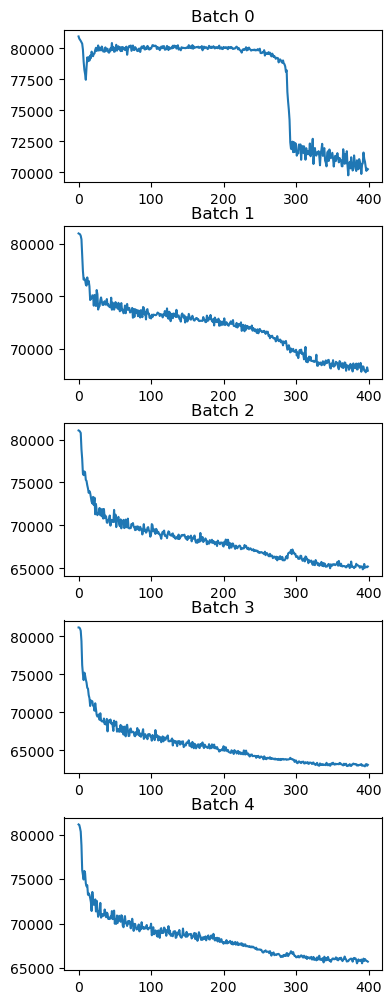

In [10]:
batch_plots(batch_loss_dict)

In [11]:
"""
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)




print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)
"""





"\nmodel.eval()\nrecon_data_train = model(dataset_msa.prot_space, deepseq)\n\n\n\n\nprint('Done')\n\nfrom pyfiglet import Figlet\nf = Figlet(font='puffy' ) #slant\n\nprint(recon_data_train[5])\nalignment = recon_data_train[5]\n\n\n\nplot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)\n"

In [12]:
#plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(8,17), show_axis=False)